
# **Xenopus Tail — Regeneration-Organizing Cell (ROC) Identification (Colab)**
This notebook repeats the study's pipeline on the full tail dataset to identify the ROC, then visualizes a Skin-like panel akin to Fig. 1B. It uses: HVG selection (Fano rule), UMAP (cosine), Walktrap on the UMAP fuzzy graph (k=10), Leiden, clustering metrics, ROC identification, marker selection (logreg & Wilcoxon), comparison to Supplementary Table 3, denoising ×2, and batch integration ×2.


In [85]:

#@title Install dependencies
!pip -q install scanpy anndata umap-learn python-igraph leidenalg harmonypy bbknn openpyxl scikit-learn matplotlib-venn

#TODO: See if I can make this a requirements.txt


In [86]:

#@title Imports
import os, json, math, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.neighbors import NearestNeighbors
from umap.umap_ import fuzzy_simplicial_set
import igraph as ig
import harmonypy as hm
import bbknn
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import drive
from scipy.sparse import issparse


In [3]:

#@title Mount Google Drive
drive.mount("/content/drive")


Mounted at /content/drive


In [87]:

#@title Paths and figure settings
sc.set_figure_params(dpi=120, figsize=(5,4))
H5AD_PATH = "/content/drive/MyDrive/STAT4243/cleaned_processed_frogtail.h5ad"
TABLE_S3_XLSX = "/content/drive/MyDrive/STAT4243/aav9996_tables3.xlsx"
OUTPUT_DIR = "/content/drive/MyDrive/STAT4243/roc_outputs_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("H5AD:", H5AD_PATH, "| Table S3:", TABLE_S3_XLSX)


H5AD: /content/drive/MyDrive/STAT4243/cleaned_processed_frogtail.h5ad | Table S3: /content/drive/MyDrive/STAT4243/aav9996_tables3.xlsx


In [88]:

#@title Load .h5ad (clean baseline; do not mutate source)
ad0 = sc.read_h5ad(H5AD_PATH)
ad0.var_names_make_unique()
print("Loaded:", ad0.shape, "| layers:", list(ad0.layers.keys()))
print("obs columns:", list(ad0.obs.columns))


Loaded: (13199, 31535) | layers: []
obs columns: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch']



## HVGs (Fano rule) and set `.raw` (all genes)
We follow the methods: CP10K normalize for stats, compute Fano, keep genes with mean in 5–80th percentiles and Fano > 65th percentile. We set the working matrix to **log2(1+CP10K)** for **HVGs** (for embedding/clustering) and store **all genes** in `.raw` for DE/marker comparisons.


In [89]:

#@title HVGs by Fano + `.raw`

counts = ad0.layers["counts"] if "counts" in ad0.layers else ad0.X
X = counts.toarray() if issparse(counts) else counts
X = X.astype(np.float32, copy=False)

lib = X.sum(axis=1, keepdims=True) + 1e-12
Xnorm = (X / lib) * 1e4
log2_all = np.log2(1.0 + Xnorm).astype(np.float32, copy=False)

gmean = Xnorm.mean(axis=0)
gvar  = Xnorm.var(axis=0, ddof=1)
fano  = np.divide(gvar, gmean, out=np.zeros_like(gvar), where=gmean>0)

p5, p80 = np.percentile(gmean, [5, 80])
mask_mean = (gmean >= p5) & (gmean <= p80)
thr = np.percentile(fano[mask_mean], 65)
hvg_mask = mask_mean & (fano > thr)

print(f"Cells: {ad0.n_obs} | Genes: {ad0.n_vars} | HVGs: {int(hvg_mask.sum())}")

adata = ad.AnnData(log2_all[:, hvg_mask], obs=ad0.obs.copy(), var=ad0.var.iloc[hvg_mask].copy())
adata.layers["log2"] = adata.X.copy()
adata.raw = ad.AnnData(log2_all, obs=ad0.obs.copy(), var=ad0.var.copy())

sc.pp.scale(adata, zero_center=True, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)

print("Working shapes:", adata.shape, "| raw:", adata.raw.shape)


Cells: 13199 | Genes: 31535 | HVGs: 8830
Working shapes: (13199, 8830) | raw: (13199, 31535)


In [90]:
my_map = {
    # --- Skin ---
    "Alpha ionocyte": "Skin",
    "Beta ionocyte": "Skin",
    "Epidermis": "Skin",
    "Goblet cell": "Skin",
    "laminin-rich epidermis": "Skin",
    "Melanocyte": "Skin",
    "Melanocyte precursor": "Skin",
    "Melanocyte stem cell": "Skin",
    "ROCs": "Skin",
    "Small secretory cell": "Skin",

    # --- Neural ---
    "Differentiating neuron": "Neural",
    "Dopaminergic neurons": "Neural",
    "Floor plate": "Neural",
    "Interneuron 1": "Neural",
    "Interneuron 2": "Neural",
    "Interneuron 3": "Neural",
    "Interneuron 4": "Neural",
    "Motor neuron": "Neural",
    "Motor neuron (leptin+)": "Neural",
    "Oligodendrocyte": "Neural",
    "Spinal cord progenitor": "Neural",
    "Vulnerable Motor Neuron": "Neural",

    # --- Somites ---
    "Anterior notochord": "Somites",
    "Dermomyotome": "Somites",
    "Differentiating myocyte": "Somites",
    "Mesenchyme": "Somites",
    "Myotome": "Somites",
    "Posterior notochord": "Somites",
    "Satellite cell": "Somites",
    "Sclerotome": "Somites",
    "Skeletal muscle": "Somites",
    "Smooth muscle": "Somites",
    "Syndetome": "Somites",
    "Vascular endothelial cell": "Somites",

    # --- Immune system ---
    "Lymphoid 1 (Gata2-, Gata3+)": "Immune system",
    "Lymphoid 2 (Cxcr6+)": "Immune system",
    "Lymphoid 3": "Immune system",
    "Lymphoid 4 (Gata2+, Gata3-)": "Immune system",
    "Lymphoid 5 (CD19+)": "Immune system",
    "Lymphoid endothelial cells": "Immune system",
    "Myeloid 1": "Immune system",
    "Myeloid 2": "Immune system",

    # --- Red blood cells ---
    "Erythrocyte 1": "Red blood cells",
    "Erythrocyte 2": "Red blood cells",
    "Erythrocyte 3": "Red blood cells",
    "Erythrocyte 4": "Red blood cells",
}


adata.obs['category'] = adata.obs['cluster'].map(my_map)
adata.obs['category'].value_counts()

category
Red blood cells    4737
Skin               4212
Somites            1716
Neural             1539
Immune system       995
Name: count, dtype: int64

In [91]:
cluster_color_map = {
    "Goblet cell": "salmon",
    "ROCs": "red",
    "Epidermis": "moccasin",
    "laminin-rich epidermis": "gold",
    "Small secretory cell": "darksalmon",
    "Alpha ionocyte": "indianred3",
    "Beta ionocyte": "indianred4",
    "Melanocyte": "goldenrod",
    "Melanocyte precursor": "tan1",
    "Melanocyte stem cell": "sandybrown",
    "Lymphoid 1 (Gata2-, Gata3+)": "hotpink",
    "Lymphoid 2 (Cxcr6+)": "pink",
    "Lymphoid 3": "plum1",
    "Lymphoid 4 (Gata2+, Gata3-)": "orchid1",
    "Lymphoid 5 (CD19+)": "darkorchid1",
    "Myeloid 2": "magenta",
    "Myeloid 1": "violet",
    "Erythrocyte 1": "grey30",
    "Erythrocyte 2": "grey50",
    "Erythrocyte 3": "grey70",
    "Erythrocyte 4": "grey90",
    "Skeletal muscle": "greenyellow",
    "Sclerotome": "darkolivegreen",
    "Dermomyotome": "springgreen",
    "Myotome": "seagreen",
    "Mesenchyme": "palegreen",
    "Syndetome": "aquamarine",
    "Satellite cell": "chartreuse",
    "Smooth muscle": "darkgreen",
    "Differentiating myocyte": "yellowgreen",
    "Vascular endothelial cell": "peru",
    "Lymphoid endothelial cells": "lightsalmon4",
    "Posterior notochord": "gray10",
    "Anterior notochord": "gray30",
    "Floor plate": "cadetblue1",
    "Spinal cord progenitor": "darkslateblue",
    "Differentiating neuron": "navy",
    "Interneuron 1": "midnightblue",
    "Interneuron 2": "dodgerblue",
    "Interneuron 3": "deepskyblue",
    "Interneuron 4": "darkturquoise",
    "Dopaminergic neurons": "lightskyblue",
    "Motor neuron": "steelblue2",
    "Vulnerable Motor Neuron": "slategray2",
    "Motor neuron (leptin+)": "turquoise1",
    "Oligodendrocyte": "aquamarine",
}


In [92]:
# ensure categorical
adata.obs["cluster"] = adata.obs["cluster"].astype("category")
order = list(adata.obs["cluster"].cat.categories)
adata.uns["cluster_colors"] = [cluster_color_map.get(cl, "#999999") for cl in order]

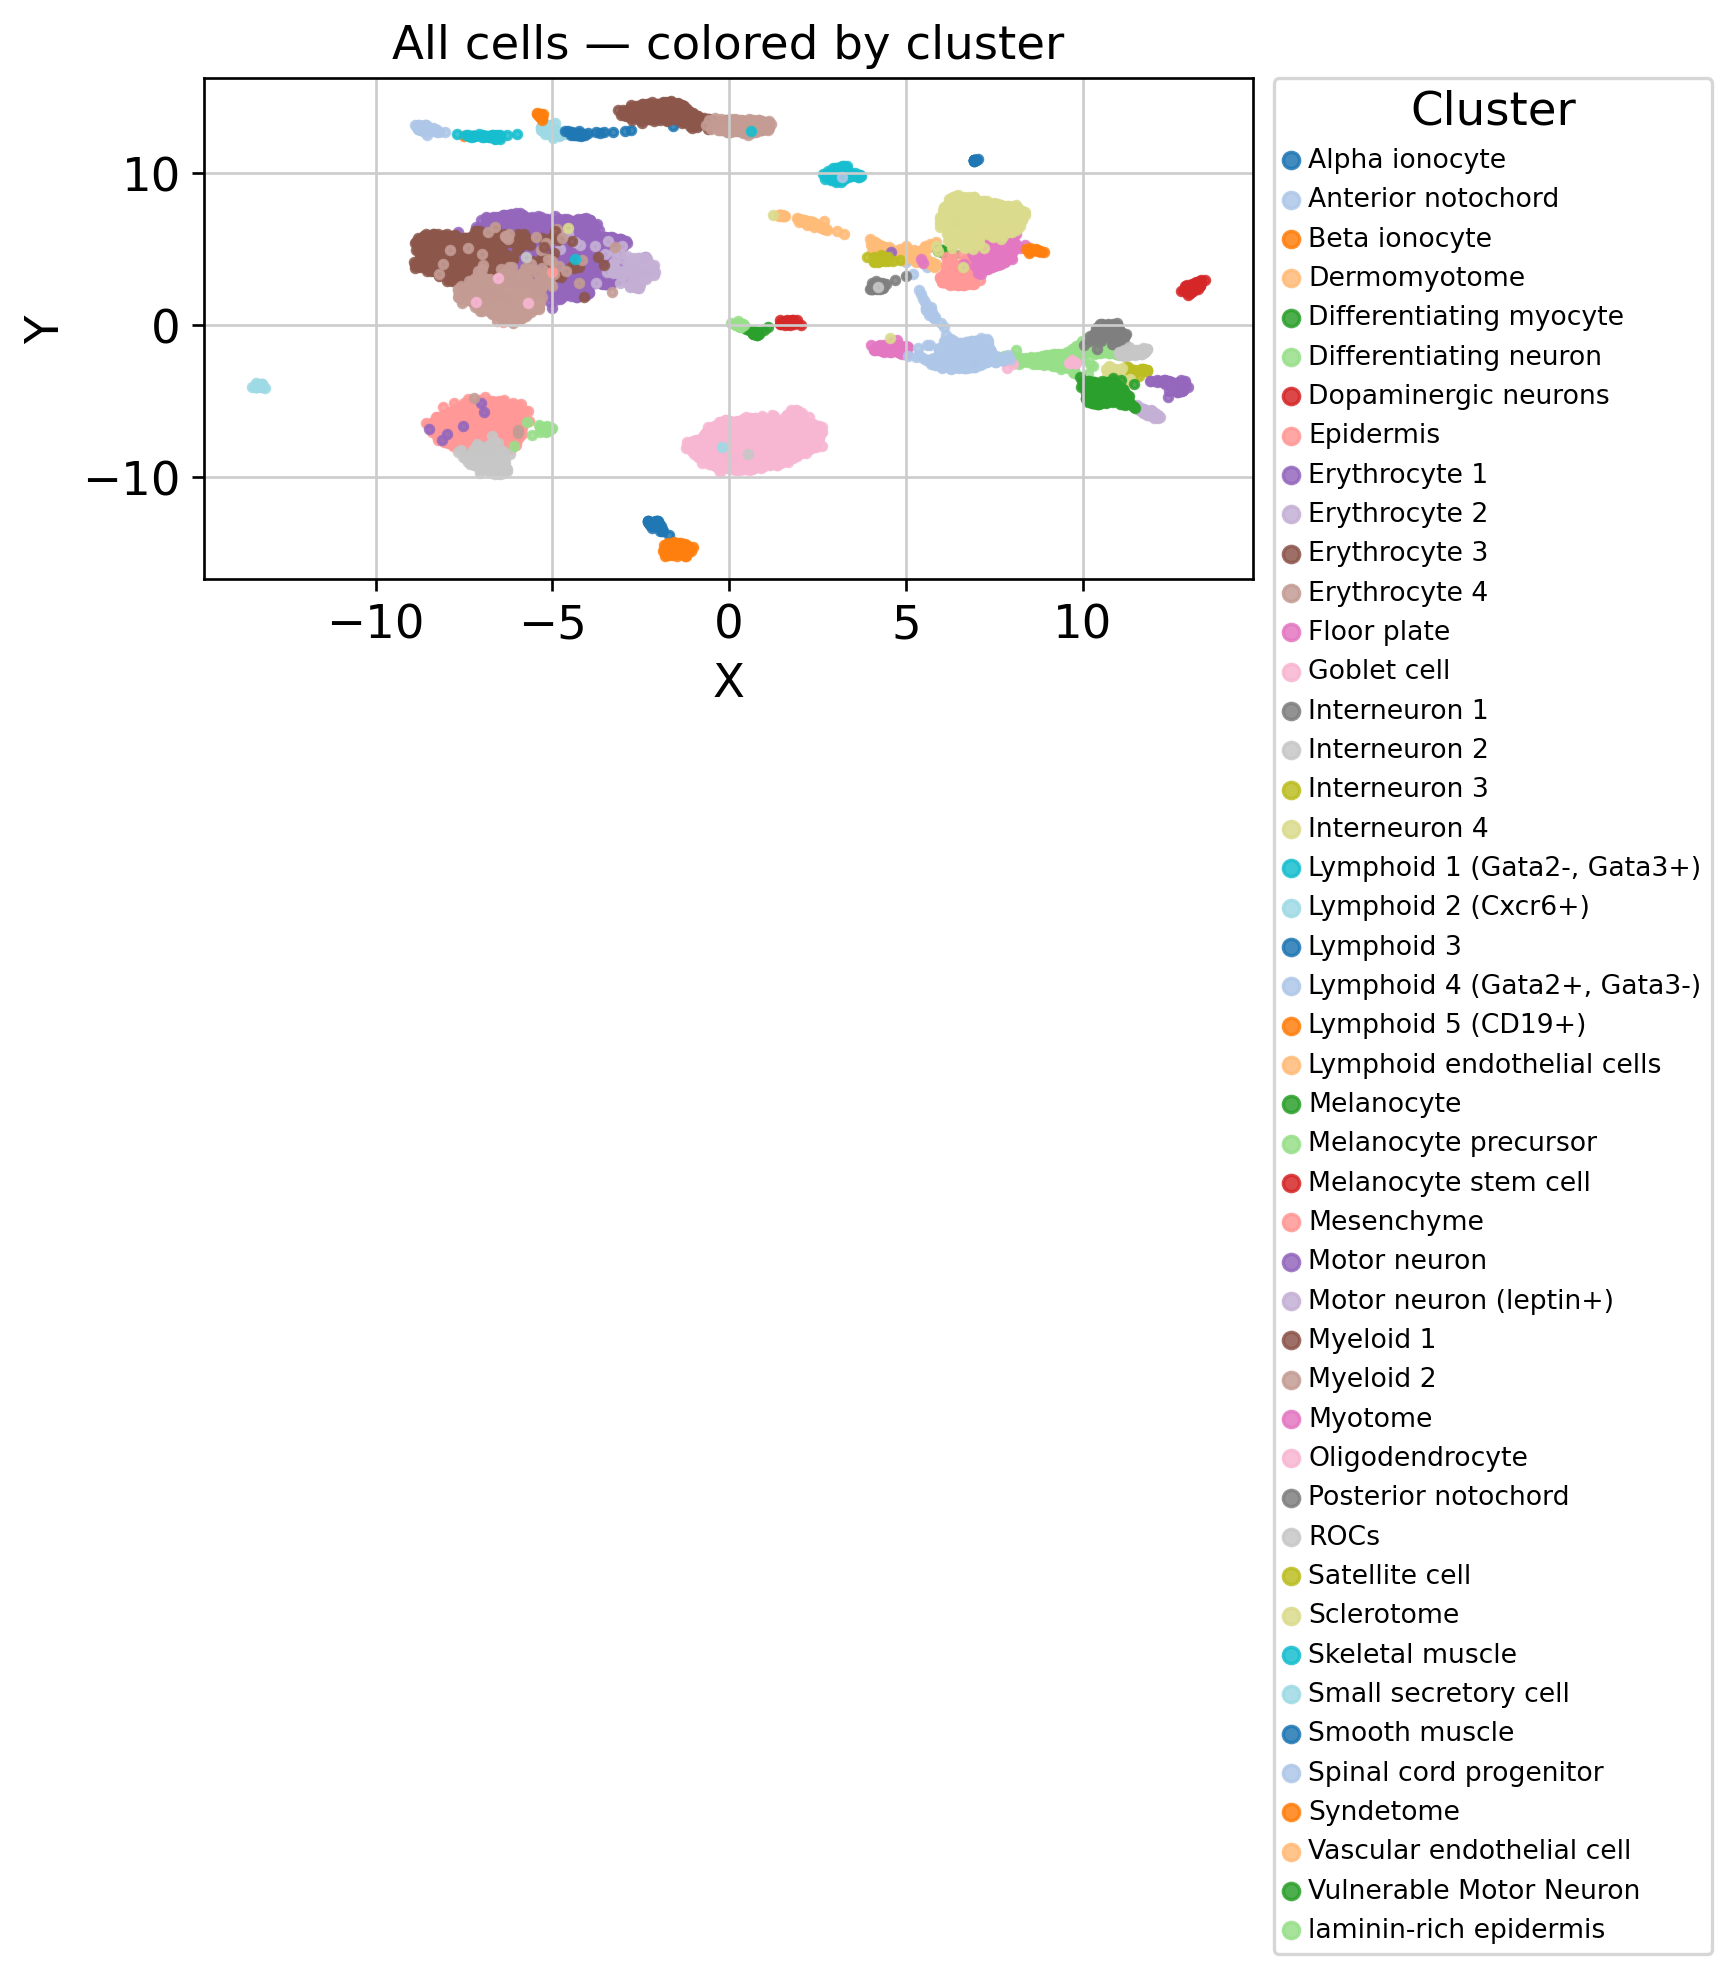

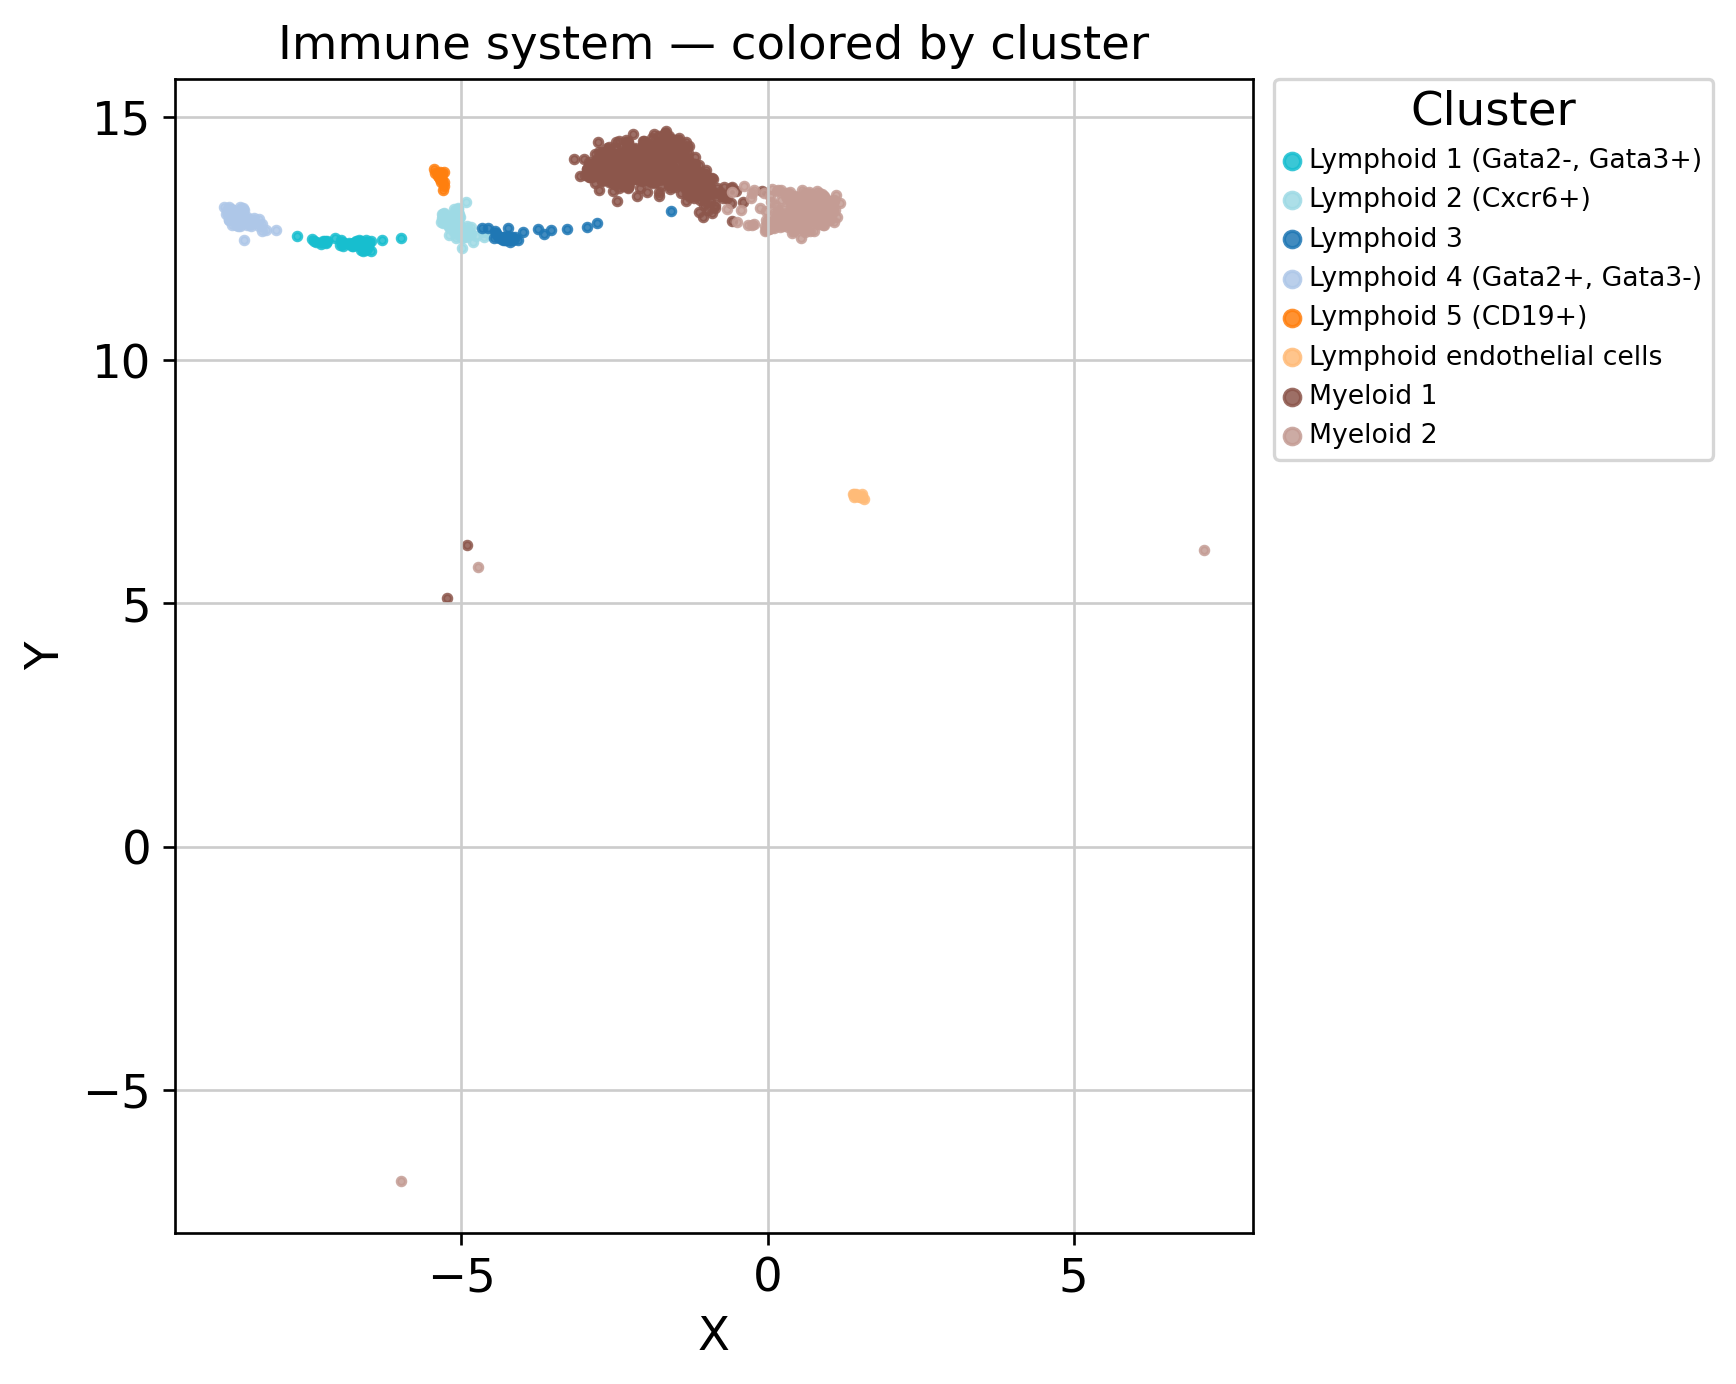

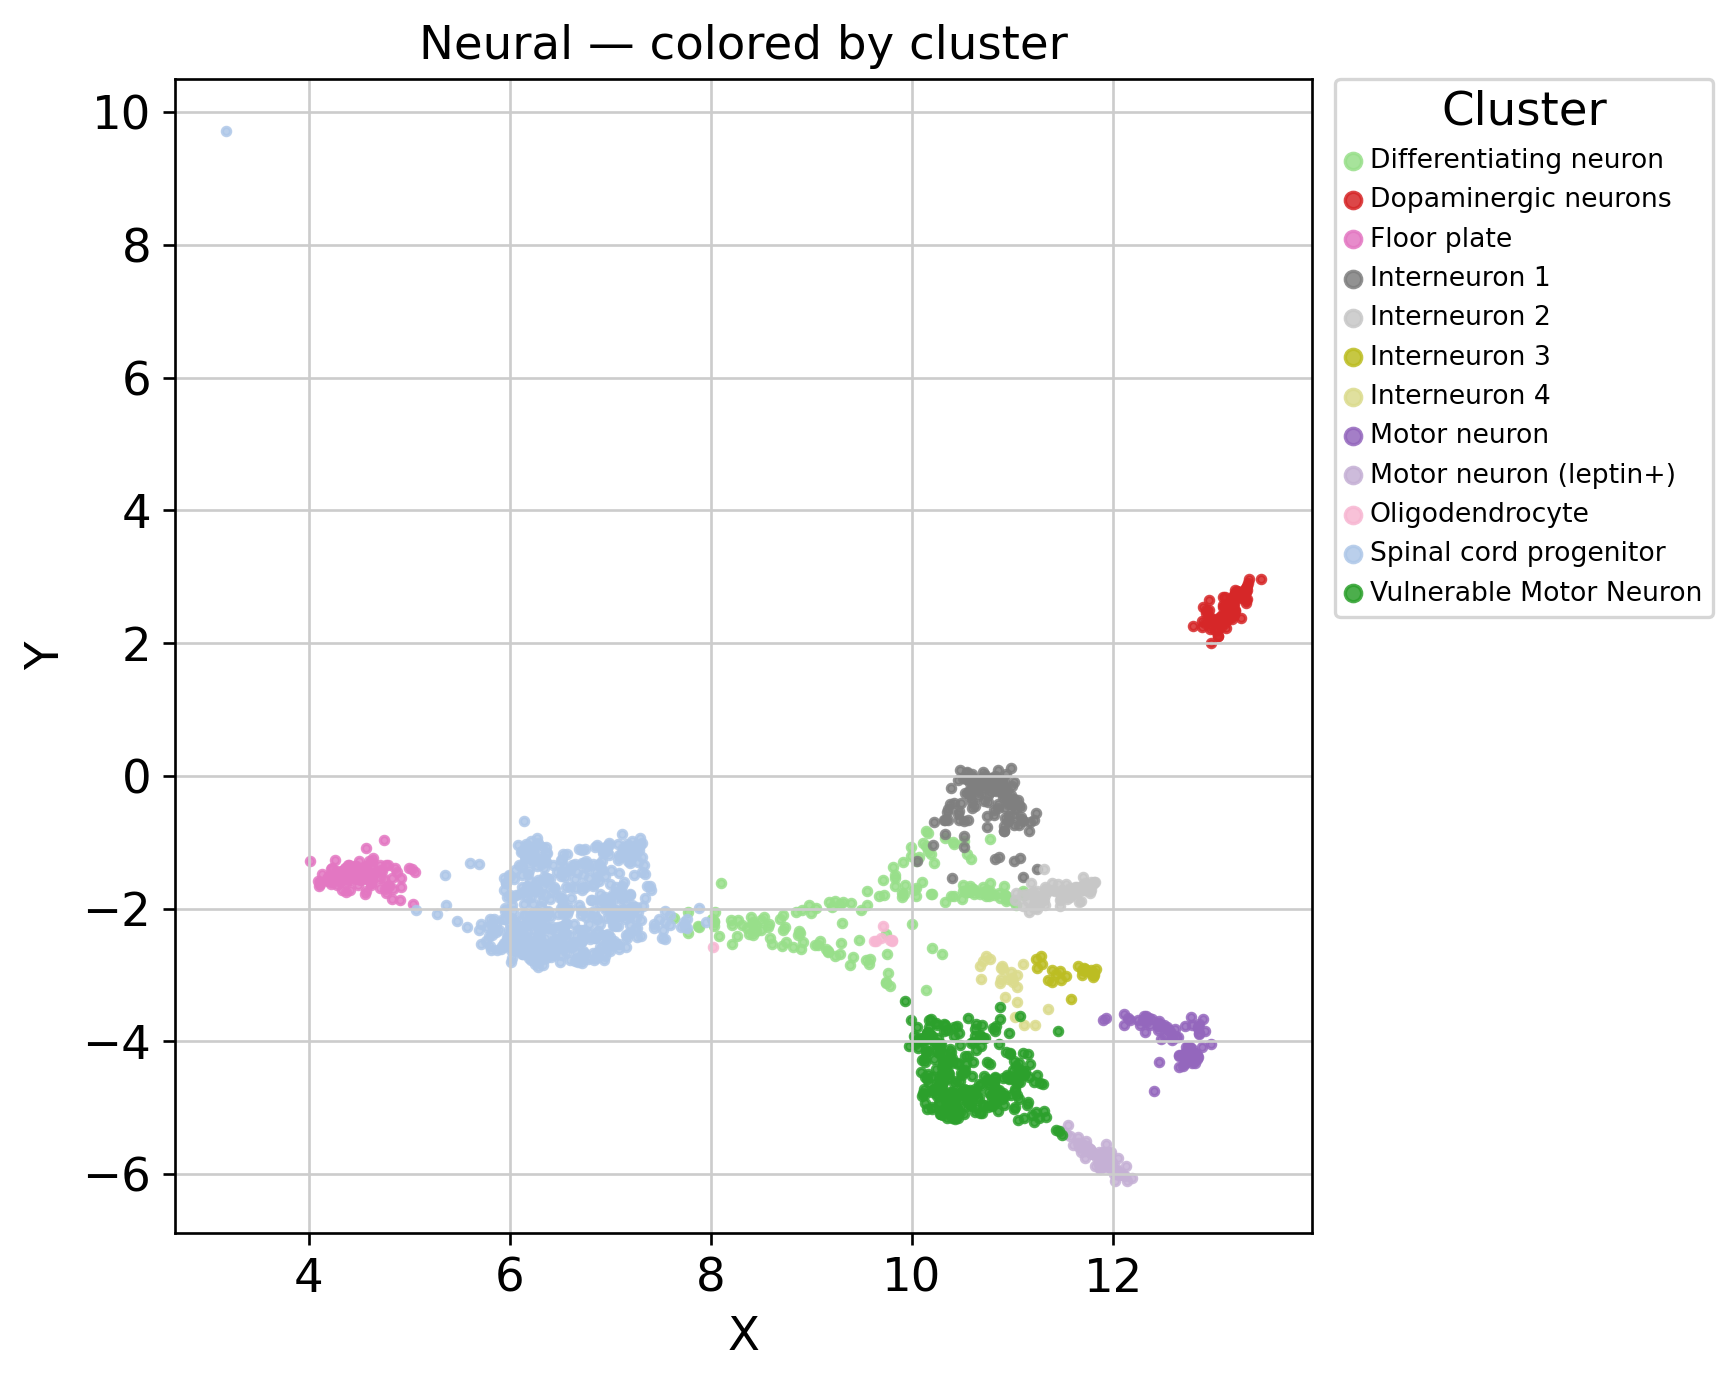

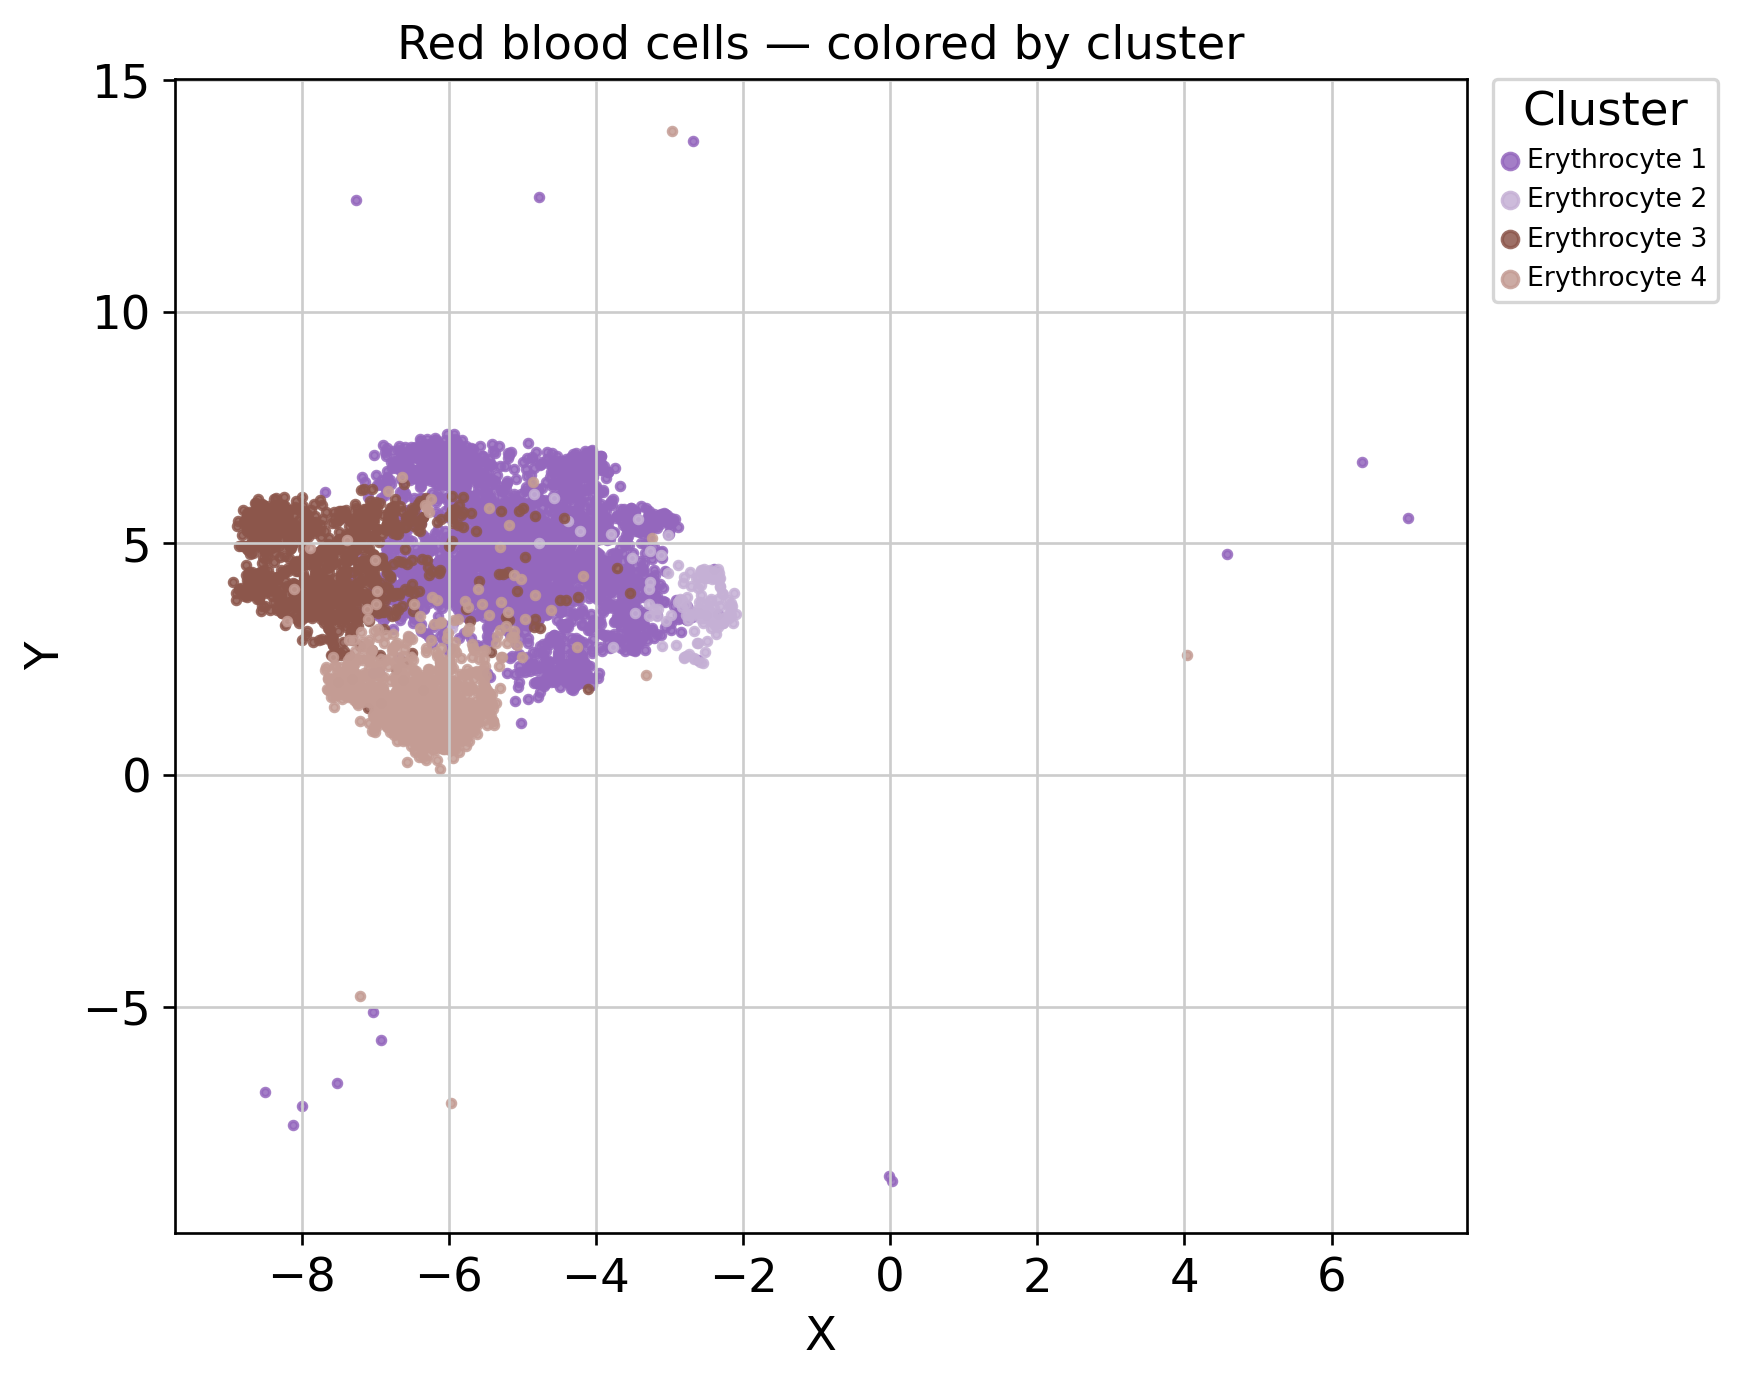

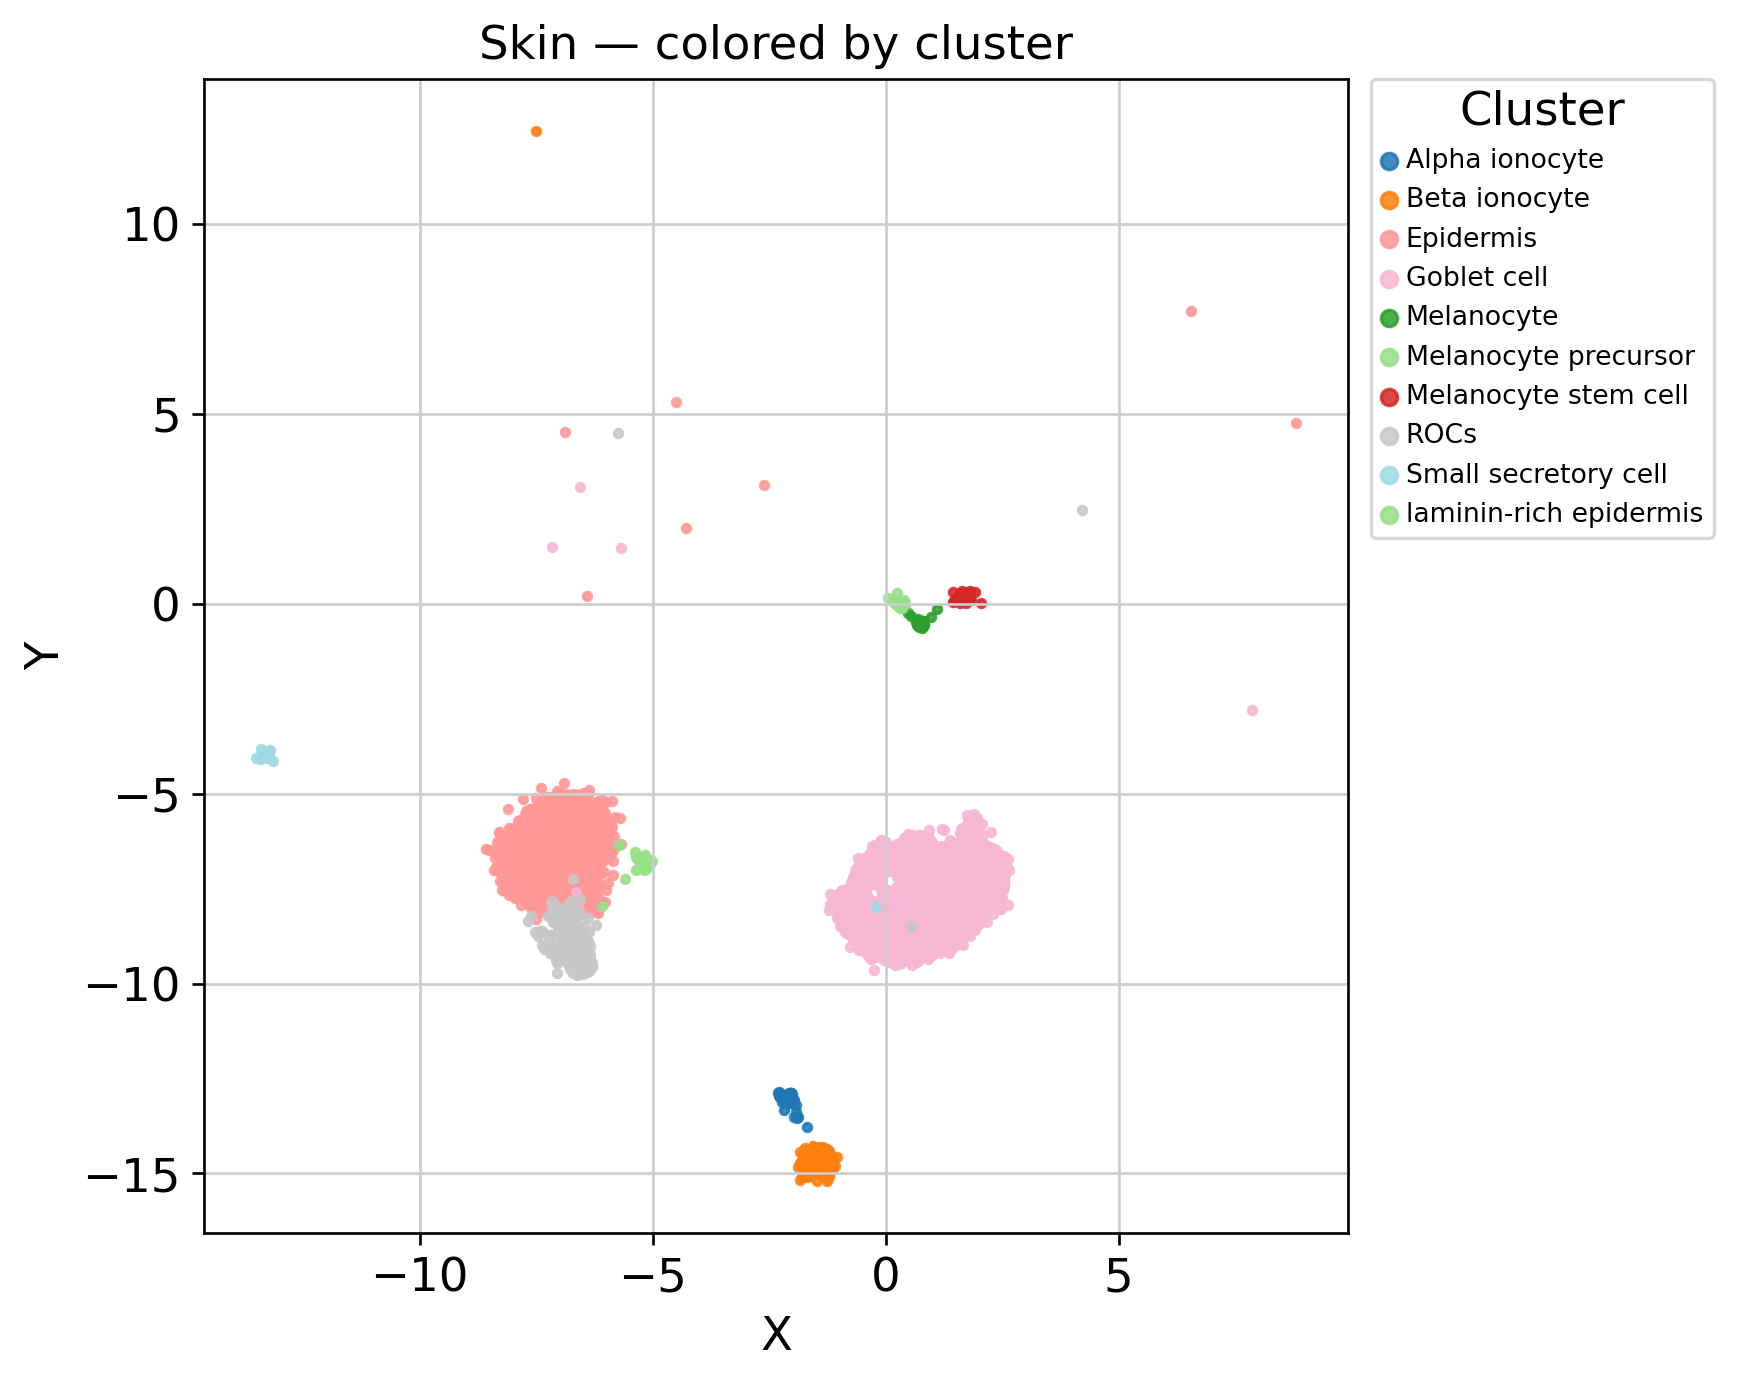

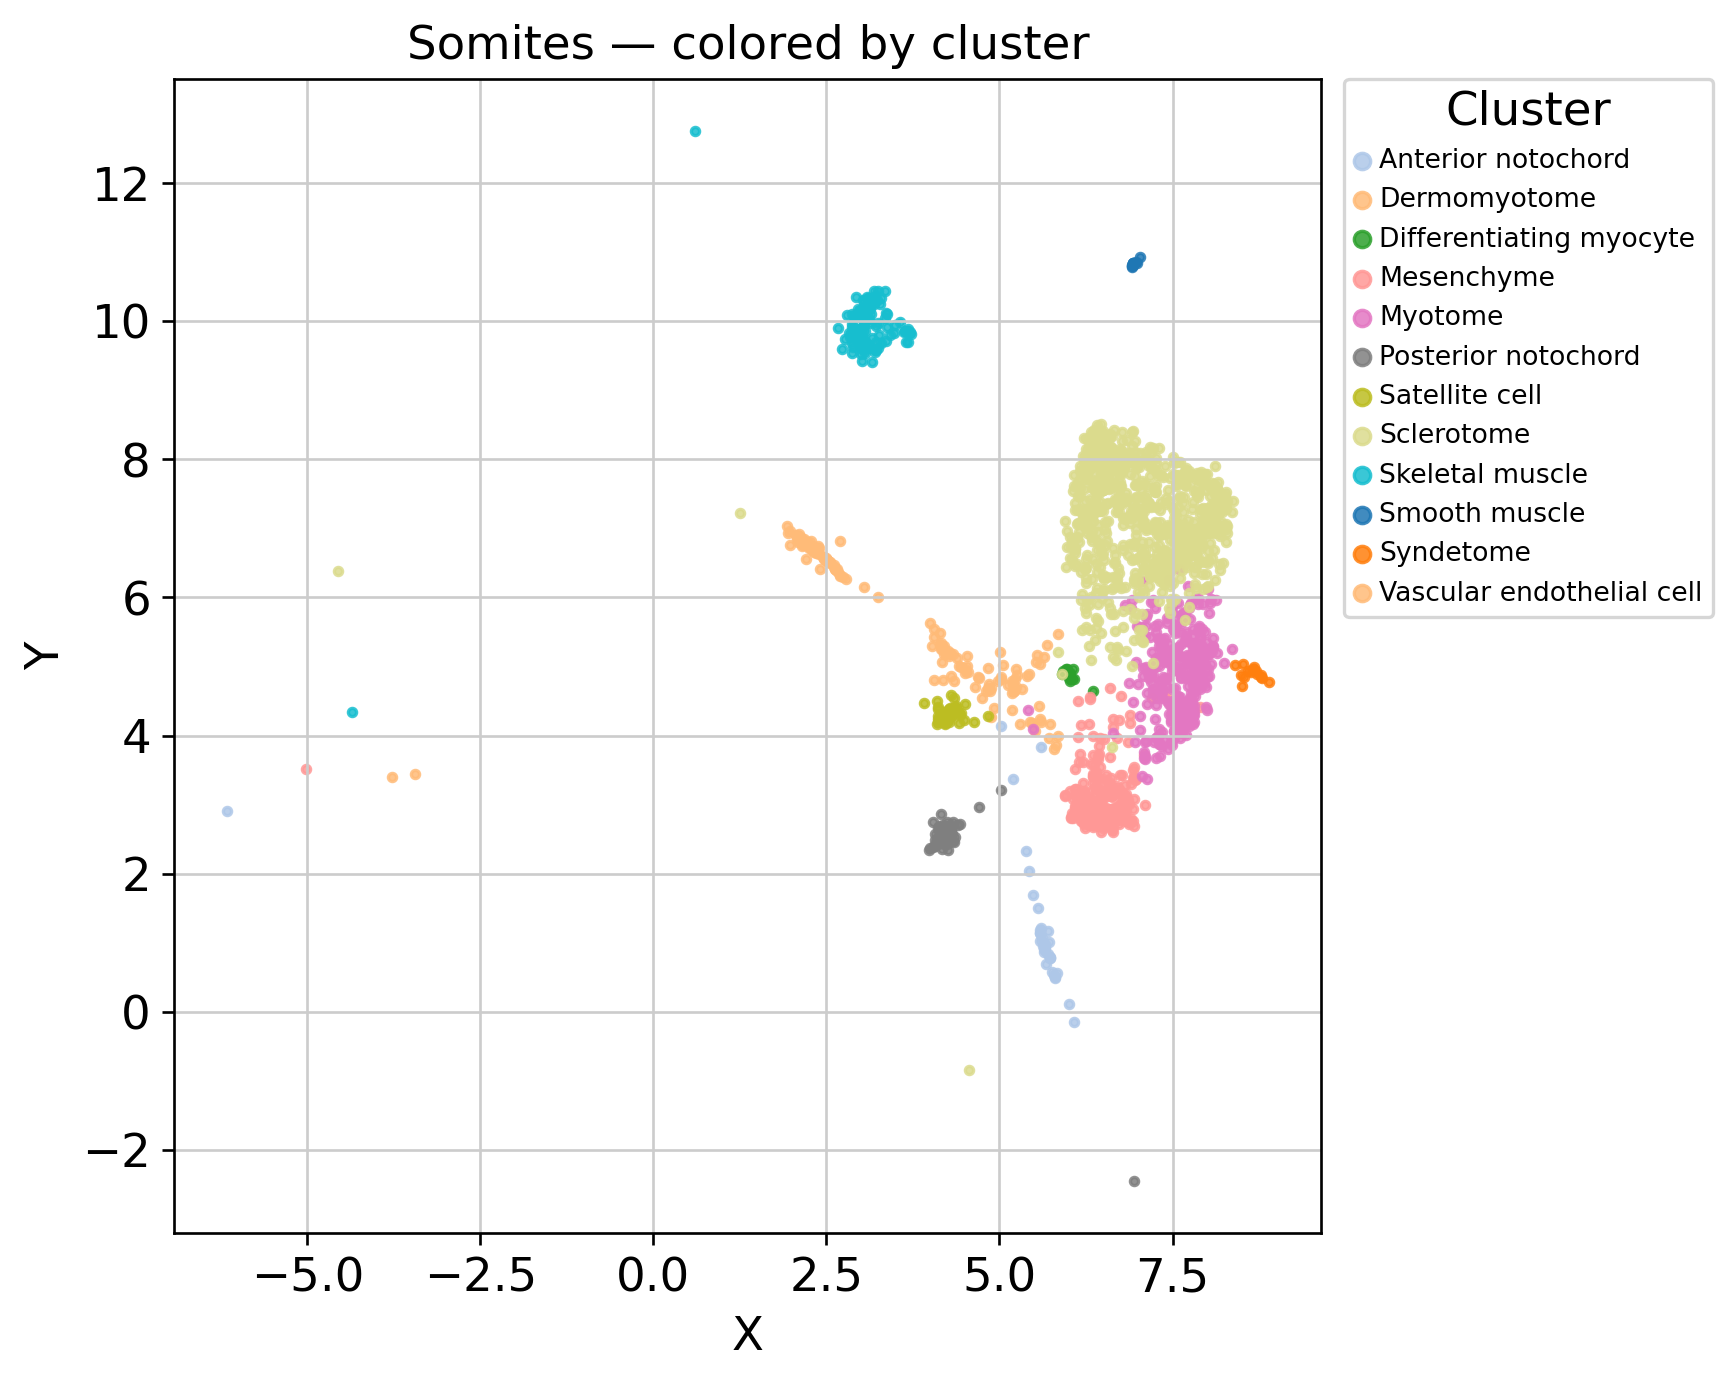

In [93]:
#@title Quick visualization
obs = adata.obs[['X','Y','cluster','category']].dropna(subset=['X','Y','cluster']).copy()
obs['cluster'] = obs['cluster'].astype(str)

clusters = sorted(obs['cluster'].unique())
base = list(plt.cm.tab20.colors)
cluster_to_color = {cl: base[i % len(base)] for i, cl in enumerate(clusters)}

def scatter_by_cluster(df, title):
    plt.figure(figsize=(7.5, 6))
    for cl in clusters:
        sub = df[df['cluster'] == cl]
        if sub.empty:
            continue
        plt.scatter(sub['X'], sub['Y'], s=6, c=[cluster_to_color[cl]], label=cl, alpha=0.85)
    plt.title(title)
    plt.xlabel('X'); plt.ylabel('Y')
    leg = plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1.0), loc="upper left",
                     borderaxespad=0., fontsize=8, markerscale=2)
    for h in getattr(leg, "legendHandles", []):
        try: h.set_sizes([20])
        except Exception: pass
    plt.tight_layout()
    plt.show()

scatter_by_cluster(obs, "All cells — colored by cluster") #TODO: Fix the legend

for cat in sorted(obs['category'].dropna().unique()):
    scatter_by_cluster(obs[obs['category'] == cat], f"{cat} — colored by cluster")



## Clustering 1 — Walktrap on UMAP fuzzy graph (k=10, cosine)
Build UMAP's fuzzy graph on **unscaled log2 HVGs** and run Walktrap with a small steps sweep.


In [114]:

#@title Walktrap (UMAP fuzzy graph on log2 HVGs - as in the study)
X_log2 = adata.layers["log2"]
if hasattr(X_log2, "A"):
    X_log2 = X_log2.A

fs = fuzzy_simplicial_set(
    X=X_log2, n_neighbors=10, metric="cosine",
    random_state=np.random.RandomState(42), return_dists=False
)
fg = fs[0] if isinstance(fs, tuple) else fs

coo = fg.tocoo()
g = ig.Graph(n=adata.n_obs, edges=list(zip(coo.row, coo.col)), directed=False)
g.es["weight"] = coo.data.tolist()
g.simplify(combine_edges="sum", loops=False)

best_sil, best_steps, best_labels = -1.0, None, None
for steps in [10]: # Paper hard set 10 - TODO: Remove?
    wt = g.community_walktrap(weights="weight", steps=steps).as_clustering()
    labels = np.array(wt.membership).astype(str)
    sil = float(silhouette_score(X_log2, labels, metric="cosine"))
    print(f"Walktrap steps={steps} → silhouette_native={sil:.3f}")
    if sil > best_sil:
        best_sil, best_steps, best_labels = sil, steps, labels

adata.obs["walktrap"] = best_labels

print(f"Chosen Walktrap: steps={best_steps}, silhouette_native={best_sil:.3f}")
Q = g.modularity(pd.Categorical(adata.obs["walktrap"]).codes, weights="weight")
print(f"Walktrap modularity on fuzzy graph: {Q:.3f}")

sc.pl.umap(adata, color="walktrap", legend_loc="on data", frameon=False, show=False)
plt.savefig(f"{OUTPUT_DIR}/umap_walktrap.png", bbox_inches="tight"); plt.close()


Walktrap steps=10 → silhouette_native=0.046
Chosen Walktrap: steps=10, silhouette_native=0.046
Walktrap modularity on fuzzy graph: 0.841


In [115]:
adata.obs['walktrap']

0        0
1        1
2        2
3        0
4        3
        ..
13194    0
13195    6
13196    6
13197    4
13198    6
Name: walktrap, Length: 13199, dtype: category
Categories (48, object): ['0', '1', '2', '3', ..., '44', '45', '46', '47']

Saved: /content/drive/MyDrive/STAT4243/roc_outputs_final/walktrap_cluster_quality.csv
Head(10):   cluster  n_cells    e_internal    a_strength  Q_contrib  count      mean  \
0       4     2598  14237.666554  31113.720352   0.135603   2598 -0.014993   
1       5     1844  11795.105809  24019.106603   0.120378   1844  0.008760   
2      10     1147   6541.275646  15164.687065   0.069972   1147  0.030388   
3       6      948   5554.603398  12371.221976   0.060926    948  0.018777   
4       0      873   5205.801260  11692.005103   0.057341    873  0.068394   
5       3      806   4599.335435  10441.163233   0.051081    806  0.029662   
6       7      700   4290.003914   8963.840706   0.048407    700  0.073694   
7       9      505   3207.763824   6537.890940   0.036815    505  0.041502   
8       1      489   3055.058730   6215.179295   0.035137    489  0.089432   
9       8      351   1860.340347   4255.996456   0.021589    351  0.022270   

     median       min       max  
0 -0.012205

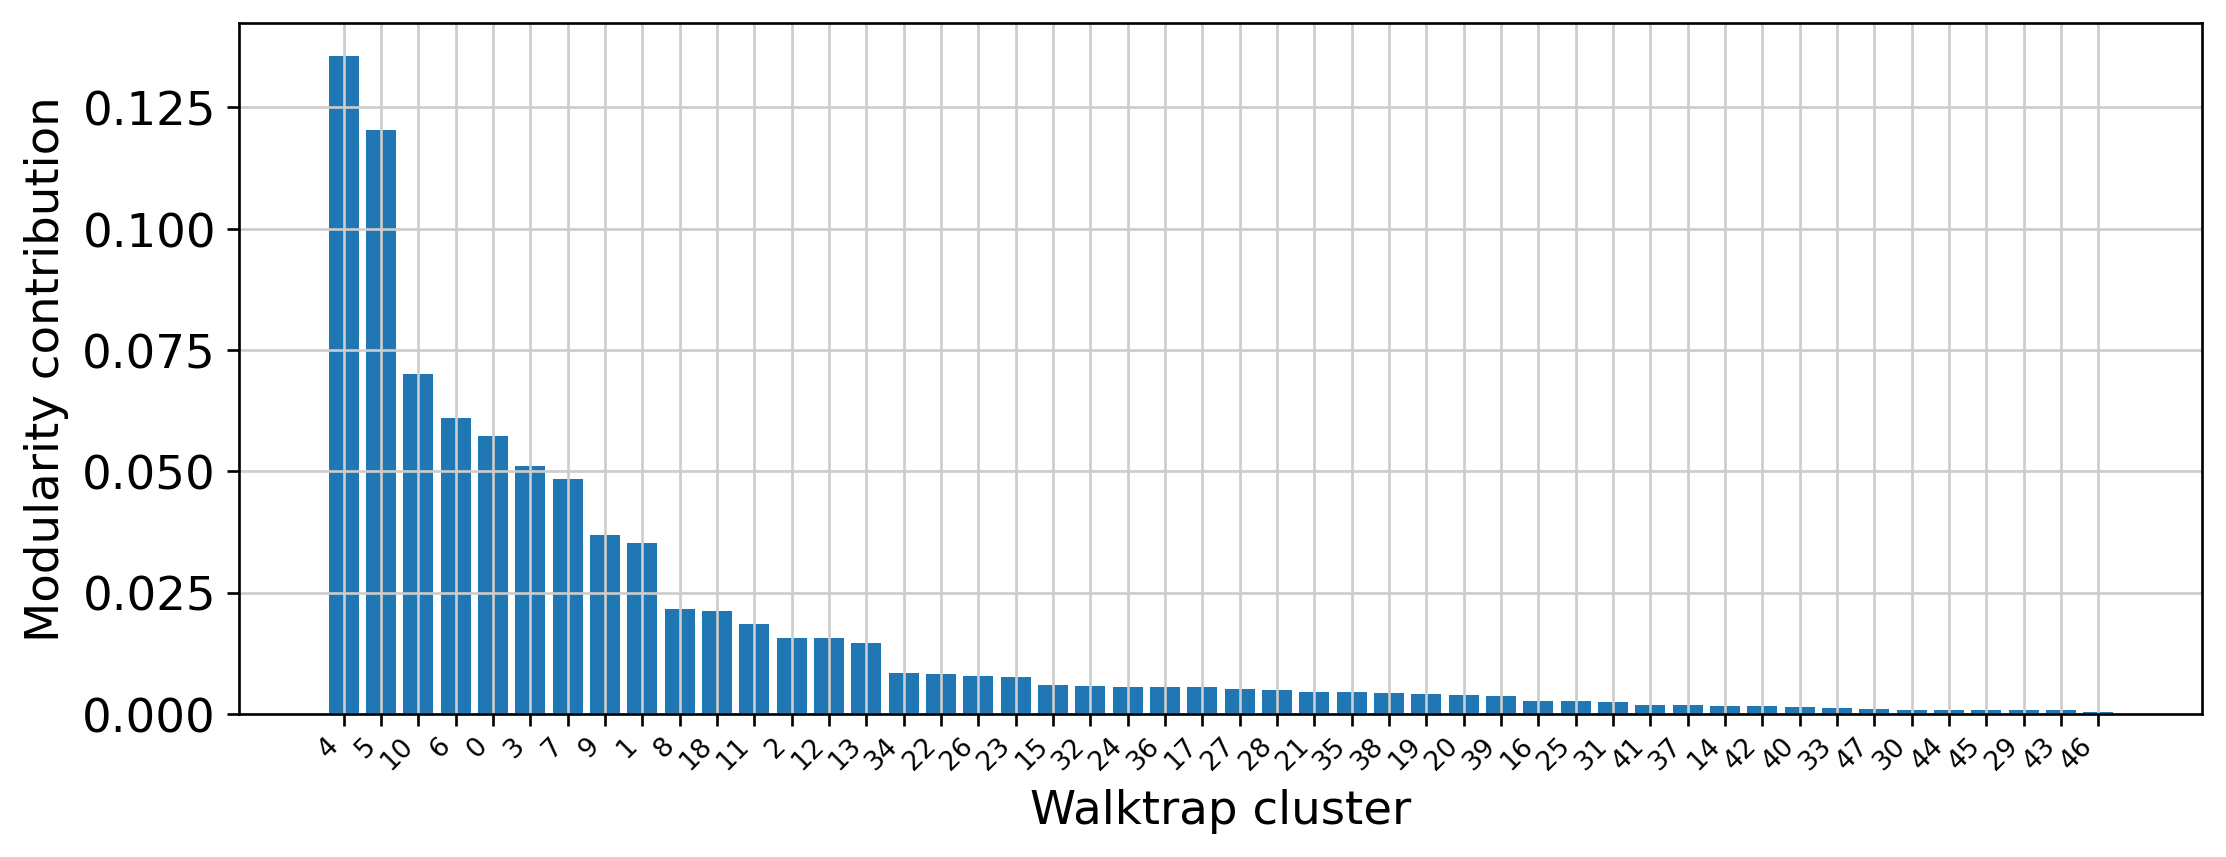

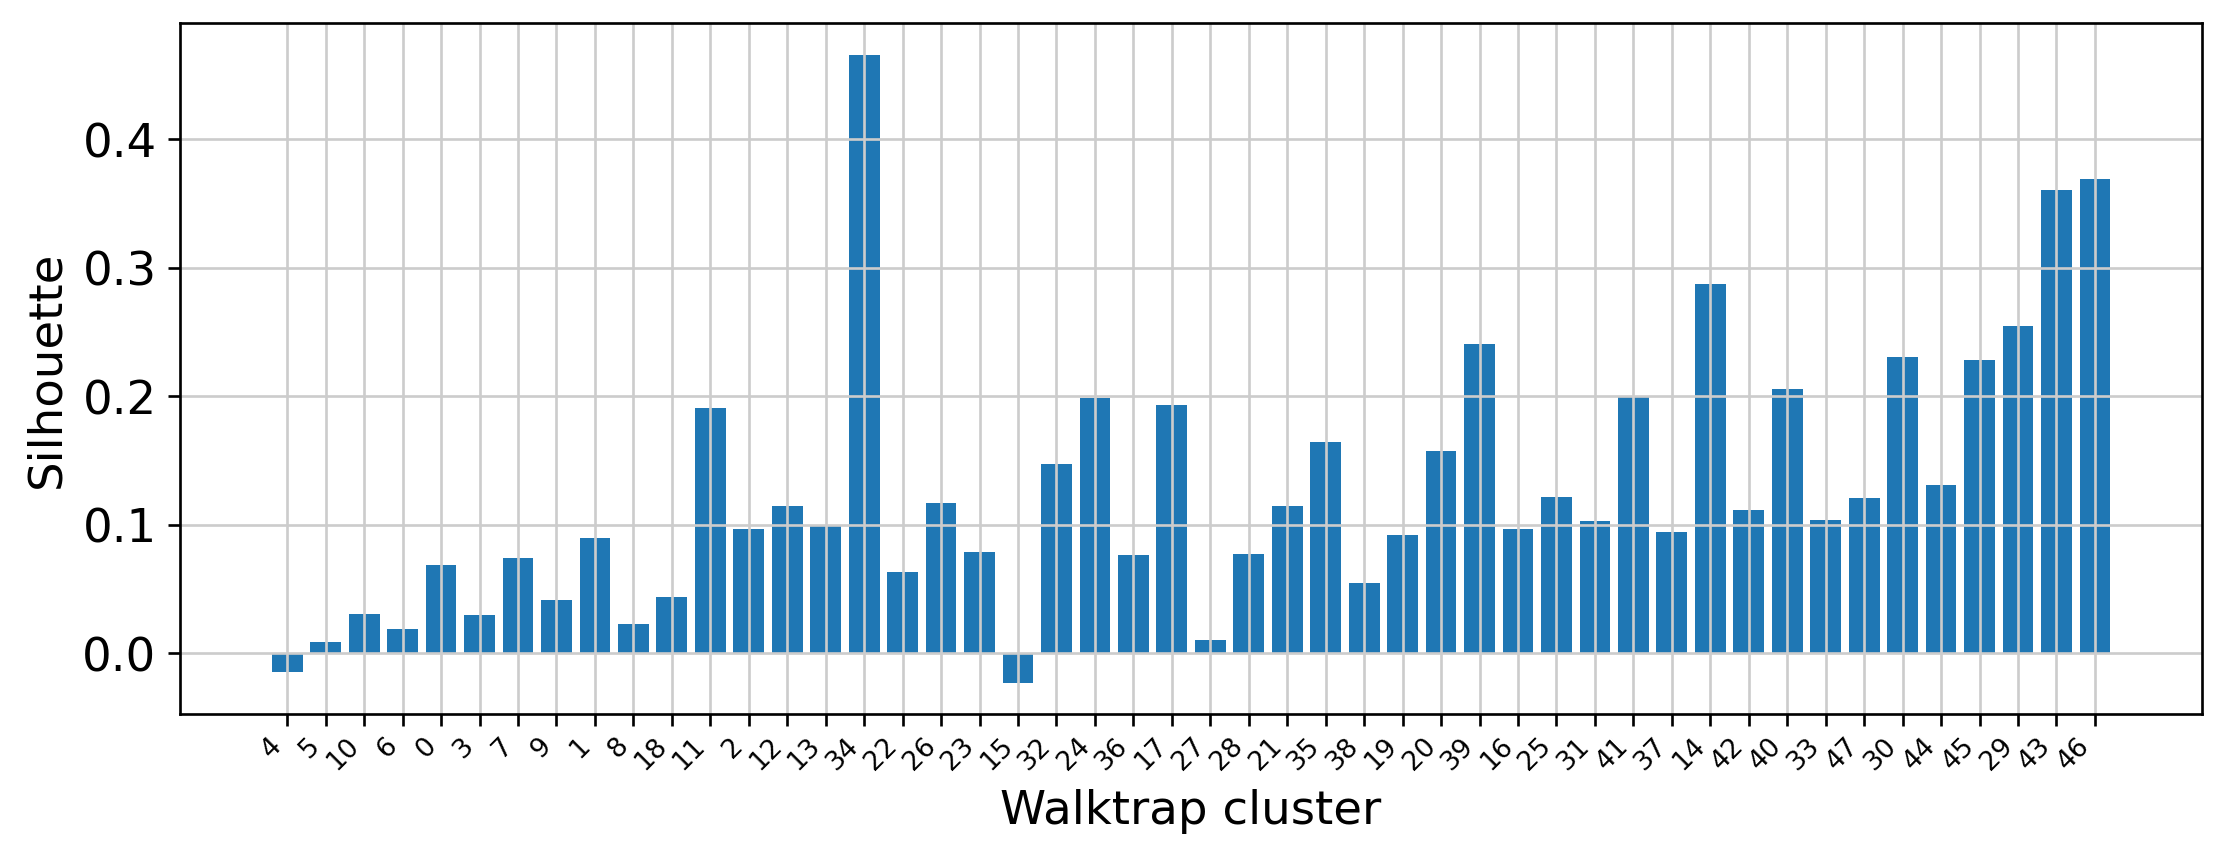

In [116]:
#@title Walktrap per-cluster quality: native-space silhouette + modularity contribution
#TODO: Clean up these imports
import numpy as np, pandas as pd, scipy.sparse as sp, matplotlib.pyplot as plt, os
from sklearn.metrics import silhouette_samples
from umap.umap_ import fuzzy_simplicial_set
import igraph as ig

#TODO: Can probably remove this
assert "walktrap" in adata.obs.columns, "You didn't set adata.obs['walktrap'])."
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Native feature space (unscaled log2 HVGs) and labels
X_log2 = adata.layers["log2"]
if hasattr(X_log2, "A"):  # sparse -> dense
    X_log2 = X_log2.A
labels = adata.obs["walktrap"].astype(str).to_numpy()

# 2) Per-cell silhouette (native space), then aggregate by cluster
sil_cell = silhouette_samples(X_log2, labels, metric="cosine")
df_sil = pd.DataFrame({"cluster": labels, "silhouette": sil_cell})
sil_per = df_sil.groupby("cluster")["silhouette"].agg(["count","mean","median","min","max"]).reset_index()

# 3) Build the UMAP fuzzy graph (k=10, cosine) and igraph
fs = fuzzy_simplicial_set(
    X=X_log2, n_neighbors=10, metric="cosine",
    random_state=np.random.RandomState(42), return_dists=False # ensure repeatability
)
fg = fs[0] if isinstance(fs, tuple) else fs
coo = fg.tocoo()
g = ig.Graph(n=adata.n_obs, edges=list(zip(coo.row, coo.col)), directed=False)
g.es["weight"] = coo.data.tolist()
g.simplify(combine_edges="sum", loops=False)

# 4) Modularity contribution per cluster
#    Q_c = (e_c / m) - (a_c / (2m))^2
#    where m = total edge weight, e_c = internal edge weight within cluster c,
#          a_c = sum of strengths (weighted degrees) of nodes in c.
ew = np.array(g.es["weight"], dtype=float)
ends = np.array(g.get_edgelist(), dtype=int)
m_total = ew.sum()  # total weight (each undirected edge counted once)
strength = np.array(g.strength(weights="weight"), dtype=float)

labs_unique = pd.Index(pd.unique(labels))
lab_to_int = {lab:i for i, lab in enumerate(labs_unique)}
c_ids = np.array([lab_to_int[x] for x in labels], dtype=int)

# internal weights per cluster
int_weight = {lab:0.0 for lab in labs_unique}
for (u,v), w in zip(ends, ew):
    if c_ids[u] == c_ids[v]:
        int_weight[labs_unique[c_ids[u]]] += w

# total strength per cluster
sum_strength = {lab: float(st) for lab, st in
                zip(labs_unique, np.bincount(c_ids, weights=strength, minlength=len(labs_unique)))}

rows = []
for lab in labs_unique:
    e_c = int_weight[lab]
    a_c = sum_strength[lab]
    Q_c = (e_c / m_total) - (a_c / (2*m_total))**2
    n_c = int((labels == lab).sum())
    rows.append({"cluster": str(lab), "n_cells": n_c, "e_internal": e_c, "a_strength": a_c, "Q_contrib": Q_c})

mod_per = pd.DataFrame(rows).sort_values("Q_contrib", ascending=False).reset_index(drop=True)


# 5) Merge, save CSV, and show in notebook + save plots
qual = pd.merge(mod_per, sil_per, on="cluster", how="left")

csv_path = os.path.join(OUTPUT_DIR, "walktrap_cluster_quality.csv")
qual.to_csv(csv_path, index=False)
print("Saved:", csv_path)

print("Head(10):", qual.head(10))

# Bar: modularity contribution
fig, ax = plt.subplots(figsize=(9.5, 3.8))  # a touch wider/taller
ax.bar(qual["cluster"].astype(str), qual["Q_contrib"].values)
ax.set_xlabel("Walktrap cluster"); ax.set_ylabel("Modularity contribution")
plt.xticks(rotation=45, ha="right", fontsize=8)  # smaller font
ax.tick_params(axis="x", pad=2)                 # less gap
fig.subplots_adjust(bottom=0.28, right=0.95)    # extra bottom margin
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(OUTPUT_DIR, "walktrap_modularity_by_cluster.png"),
            dpi=200, bbox_inches="tight")
plt.close(fig)

# Bar: silhouette mean
fig, ax = plt.subplots(figsize=(9.5, 3.8))
ax.bar(qual["cluster"].astype(str), qual["mean"].values)
ax.set_xlabel("Walktrap cluster"); ax.set_ylabel("Silhouette")
plt.xticks(rotation=45, ha="right", fontsize=8)
ax.tick_params(axis="x", pad=2)
fig.subplots_adjust(bottom=0.28, right=0.95)
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(OUTPUT_DIR, "walktrap_silhouette_by_cluster.png"),
            dpi=200, bbox_inches="tight")
plt.close(fig)



## Clustering 2 — Leiden (kNN on PCA) + metrics
Compute silhouettes in the appropriate space for each method, plus ARI/Rand.


{
  "walktrap": {
    "silhouette_native_log2HVG_cosine": 0.045835334807634354
  },
  "leiden": {
    "silhouette_PCA_cosine": 0.31916072964668274
  },
  "walktrap~leiden": {
    "ARI": 0.6367084877420396,
    "Rand": 0.9435578799640199
  }
}


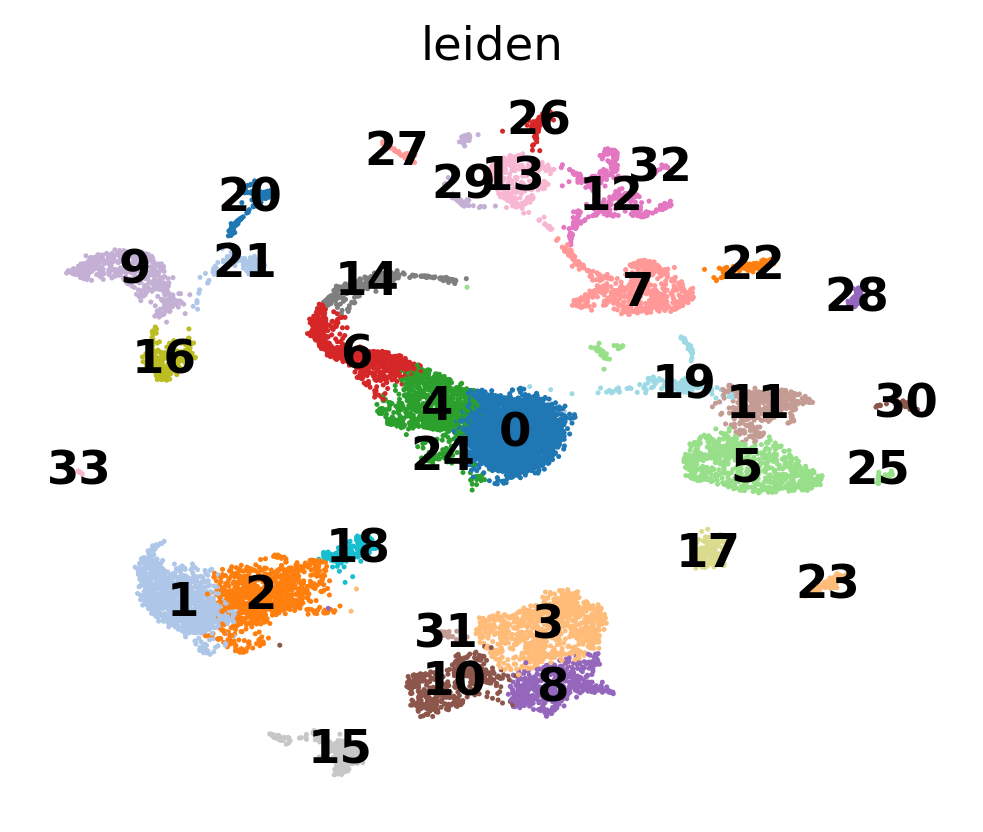

In [117]:

#@title Leiden + metrics
sc.tl.leiden(adata, key_added="leiden", resolution=1.0)

X_pca = adata.obsm["X_pca"][:, :20]
sil_walktrap_native = float(silhouette_score(adata.layers["log2"].A if hasattr(adata.layers["log2"], "A") else adata.layers["log2"],
                                             adata.obs["walktrap"], metric="cosine"))
sil_leiden_pca     = float(silhouette_score(X_pca, adata.obs["leiden"], metric="cosine"))
ARI   = float(adjusted_rand_score(adata.obs["walktrap"], adata.obs["leiden"]))
RAND  = float(rand_score(adata.obs["walktrap"], adata.obs["leiden"]))

metrics = {
    "walktrap": {"silhouette_native_log2HVG_cosine": sil_walktrap_native},
    "leiden":   {"silhouette_PCA_cosine": sil_leiden_pca},
    "walktrap~leiden": {"ARI": ARI, "Rand": RAND}
}
print(json.dumps(metrics, indent=2))
open(f"{OUTPUT_DIR}/metrics_baseline.json","w").write(json.dumps(metrics, indent=2))

sc.pl.umap(adata, color="leiden", legend_loc="on data", frameon=False, show=False)
plt.show()
plt.savefig(f"{OUTPUT_DIR}/umap_leiden.png", bbox_inches="tight"); plt.close()


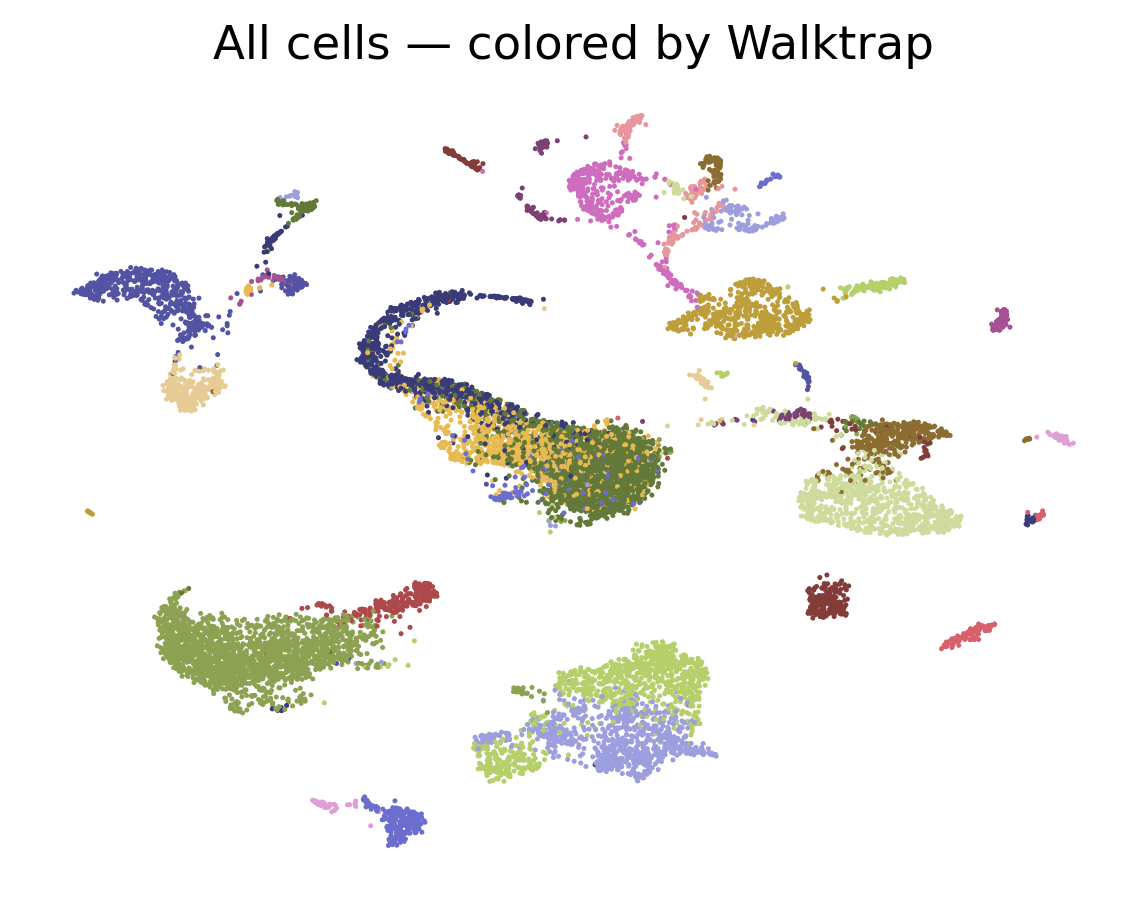

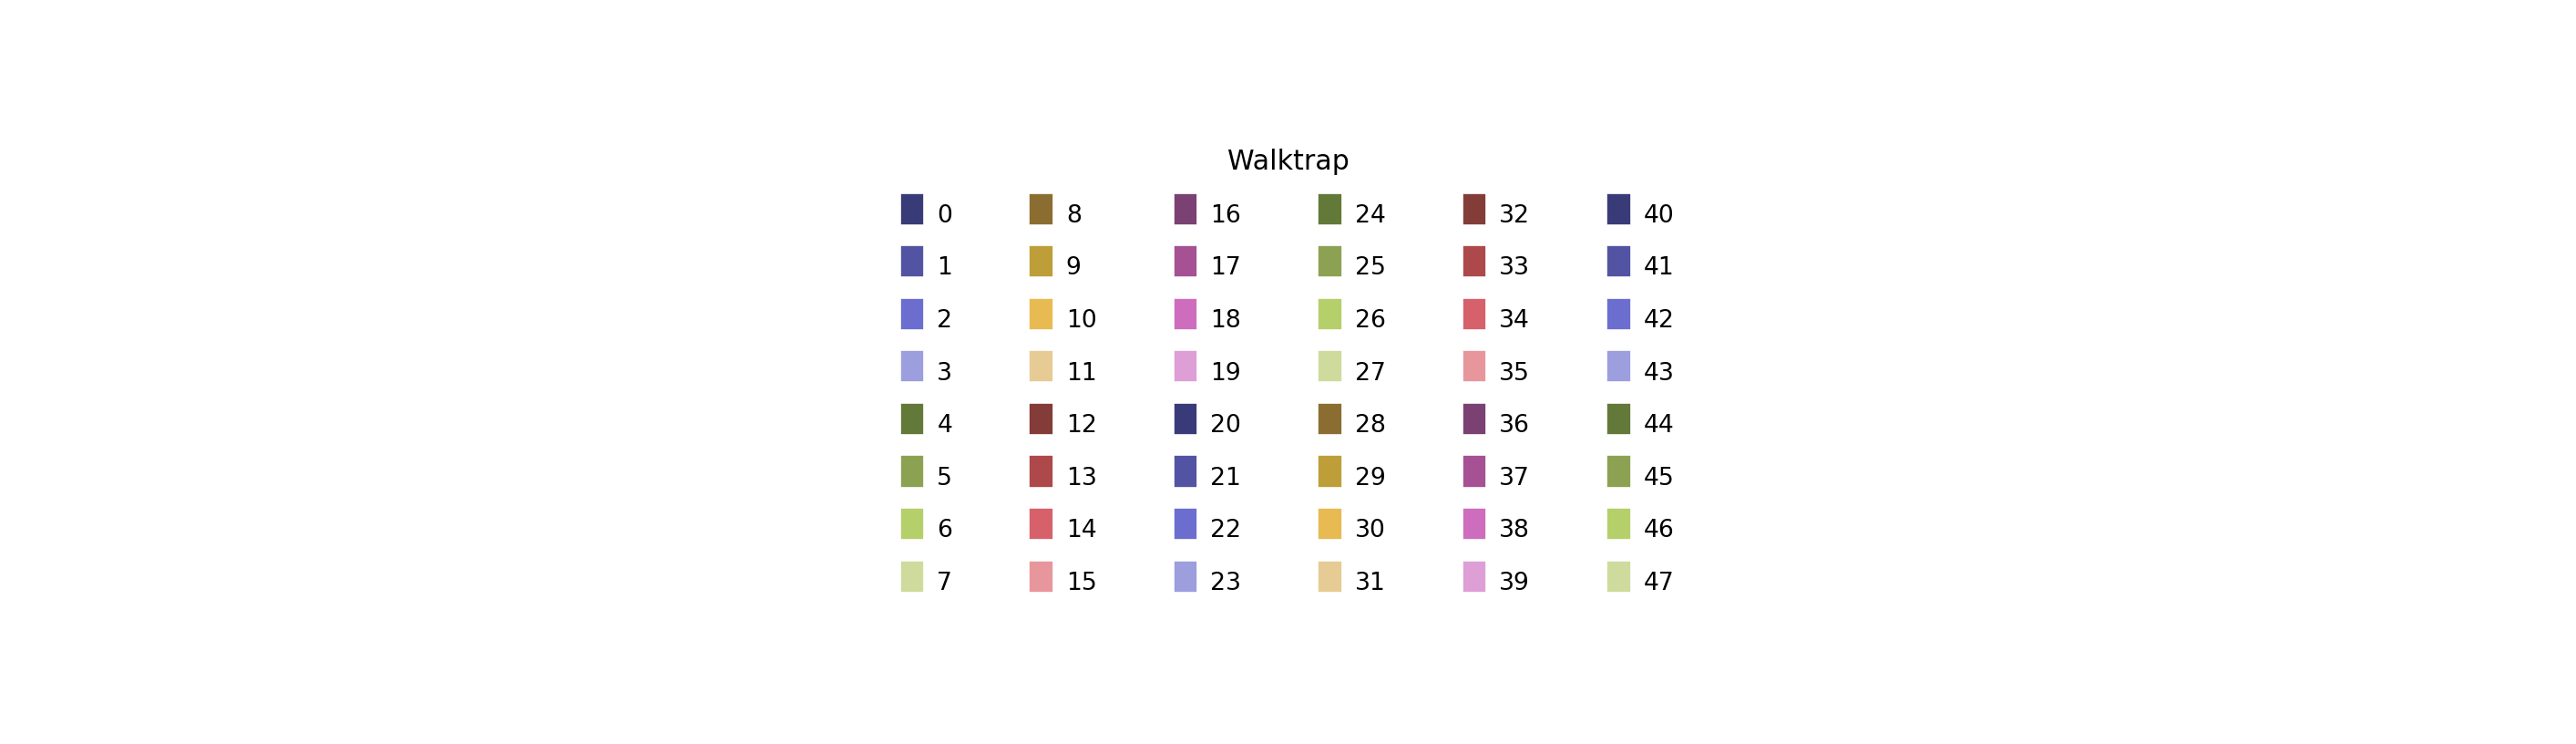

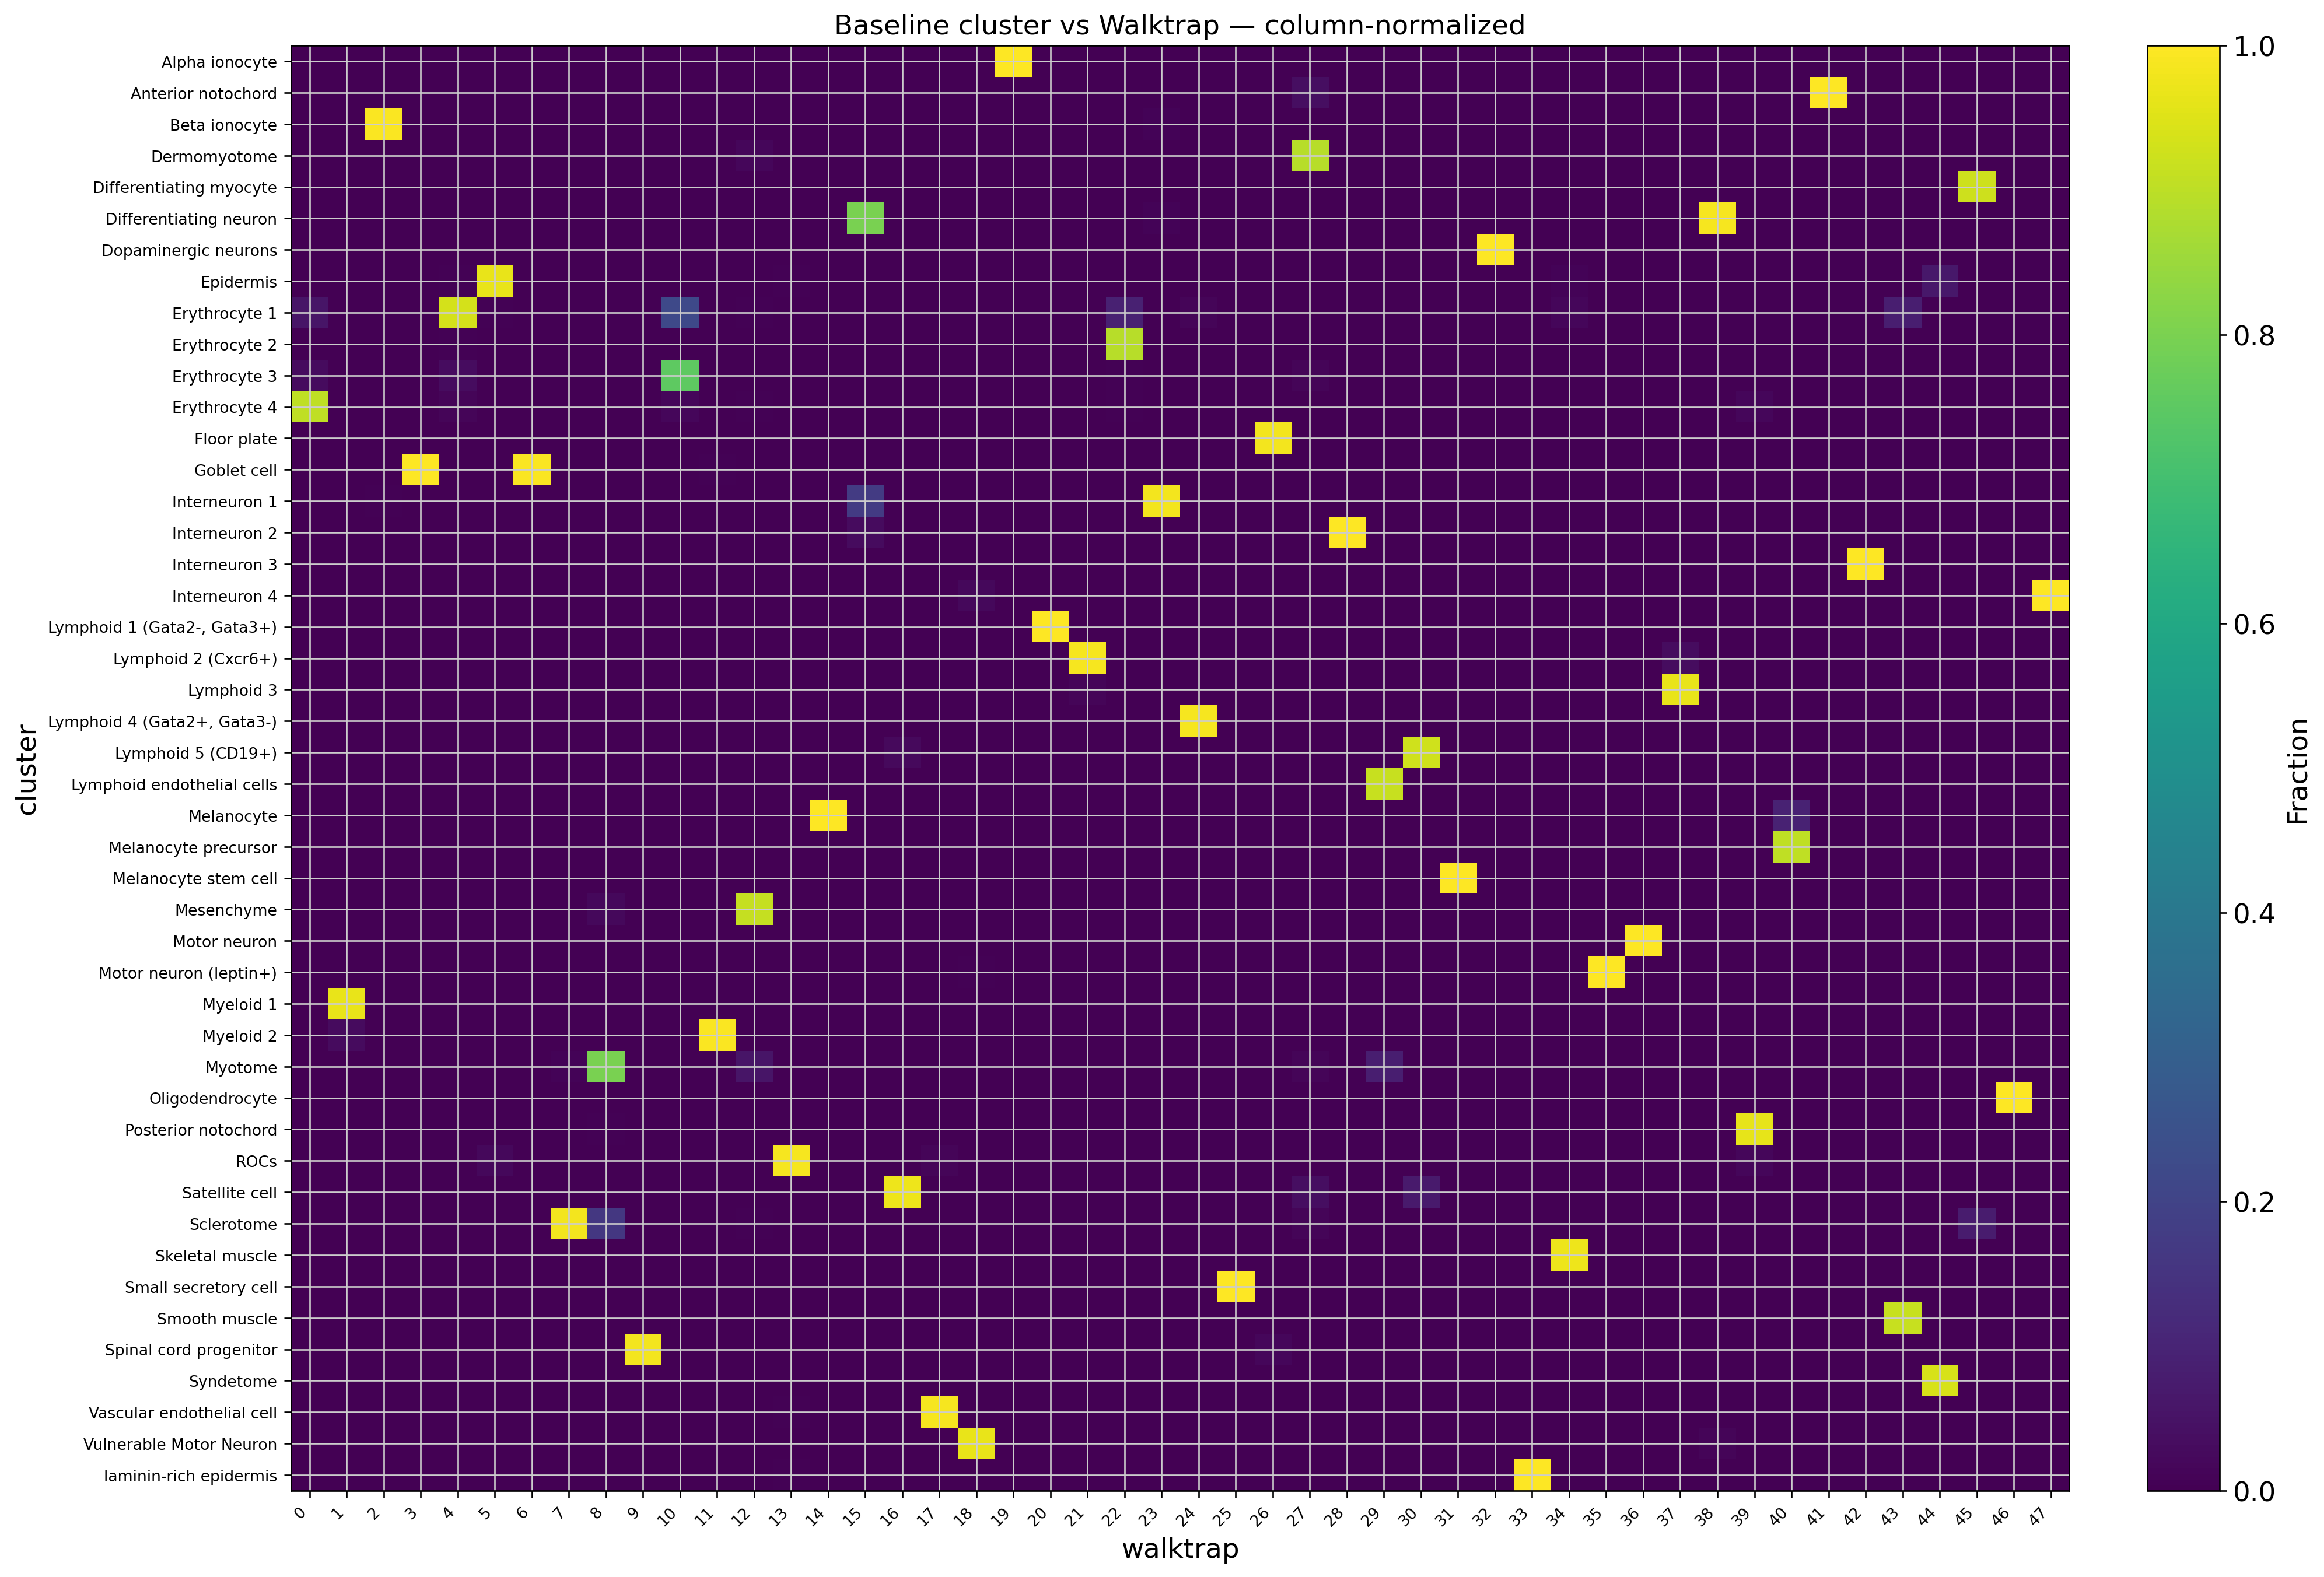

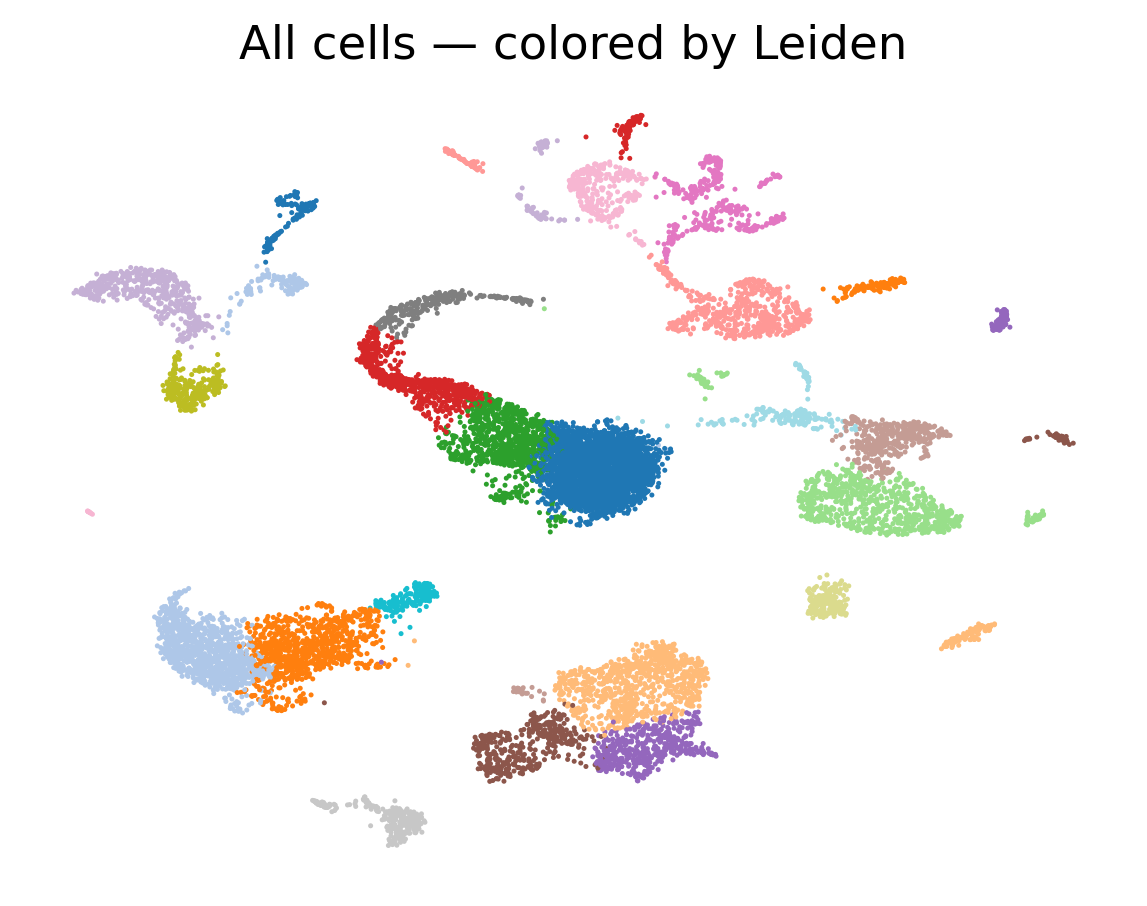

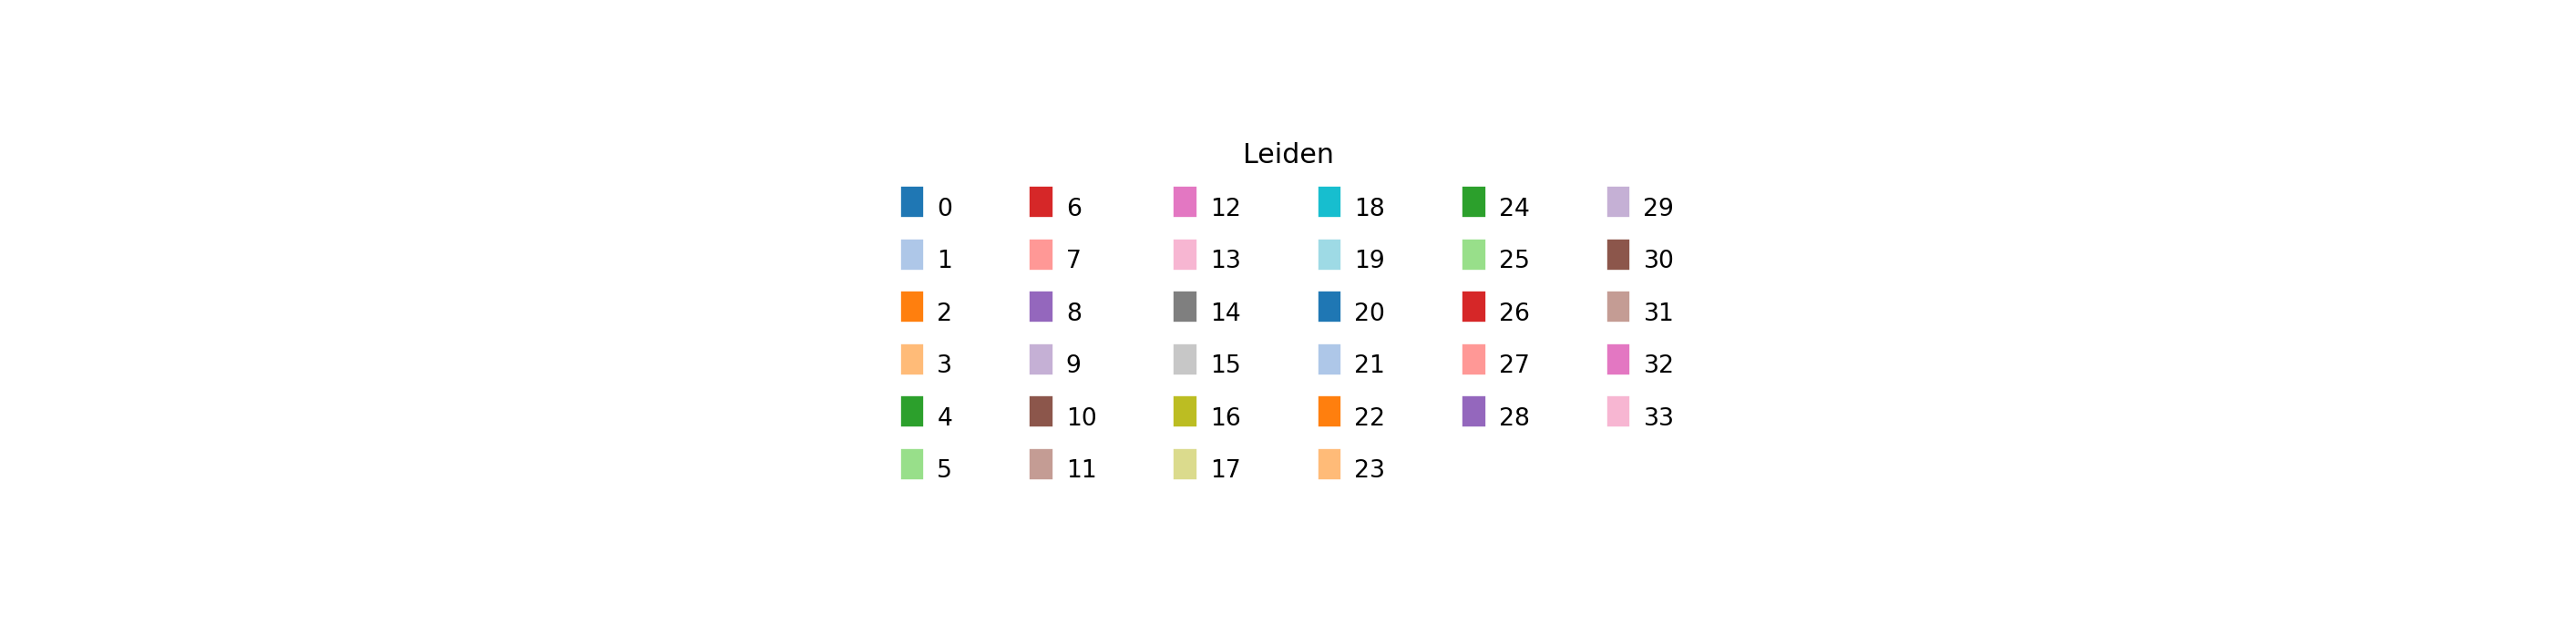

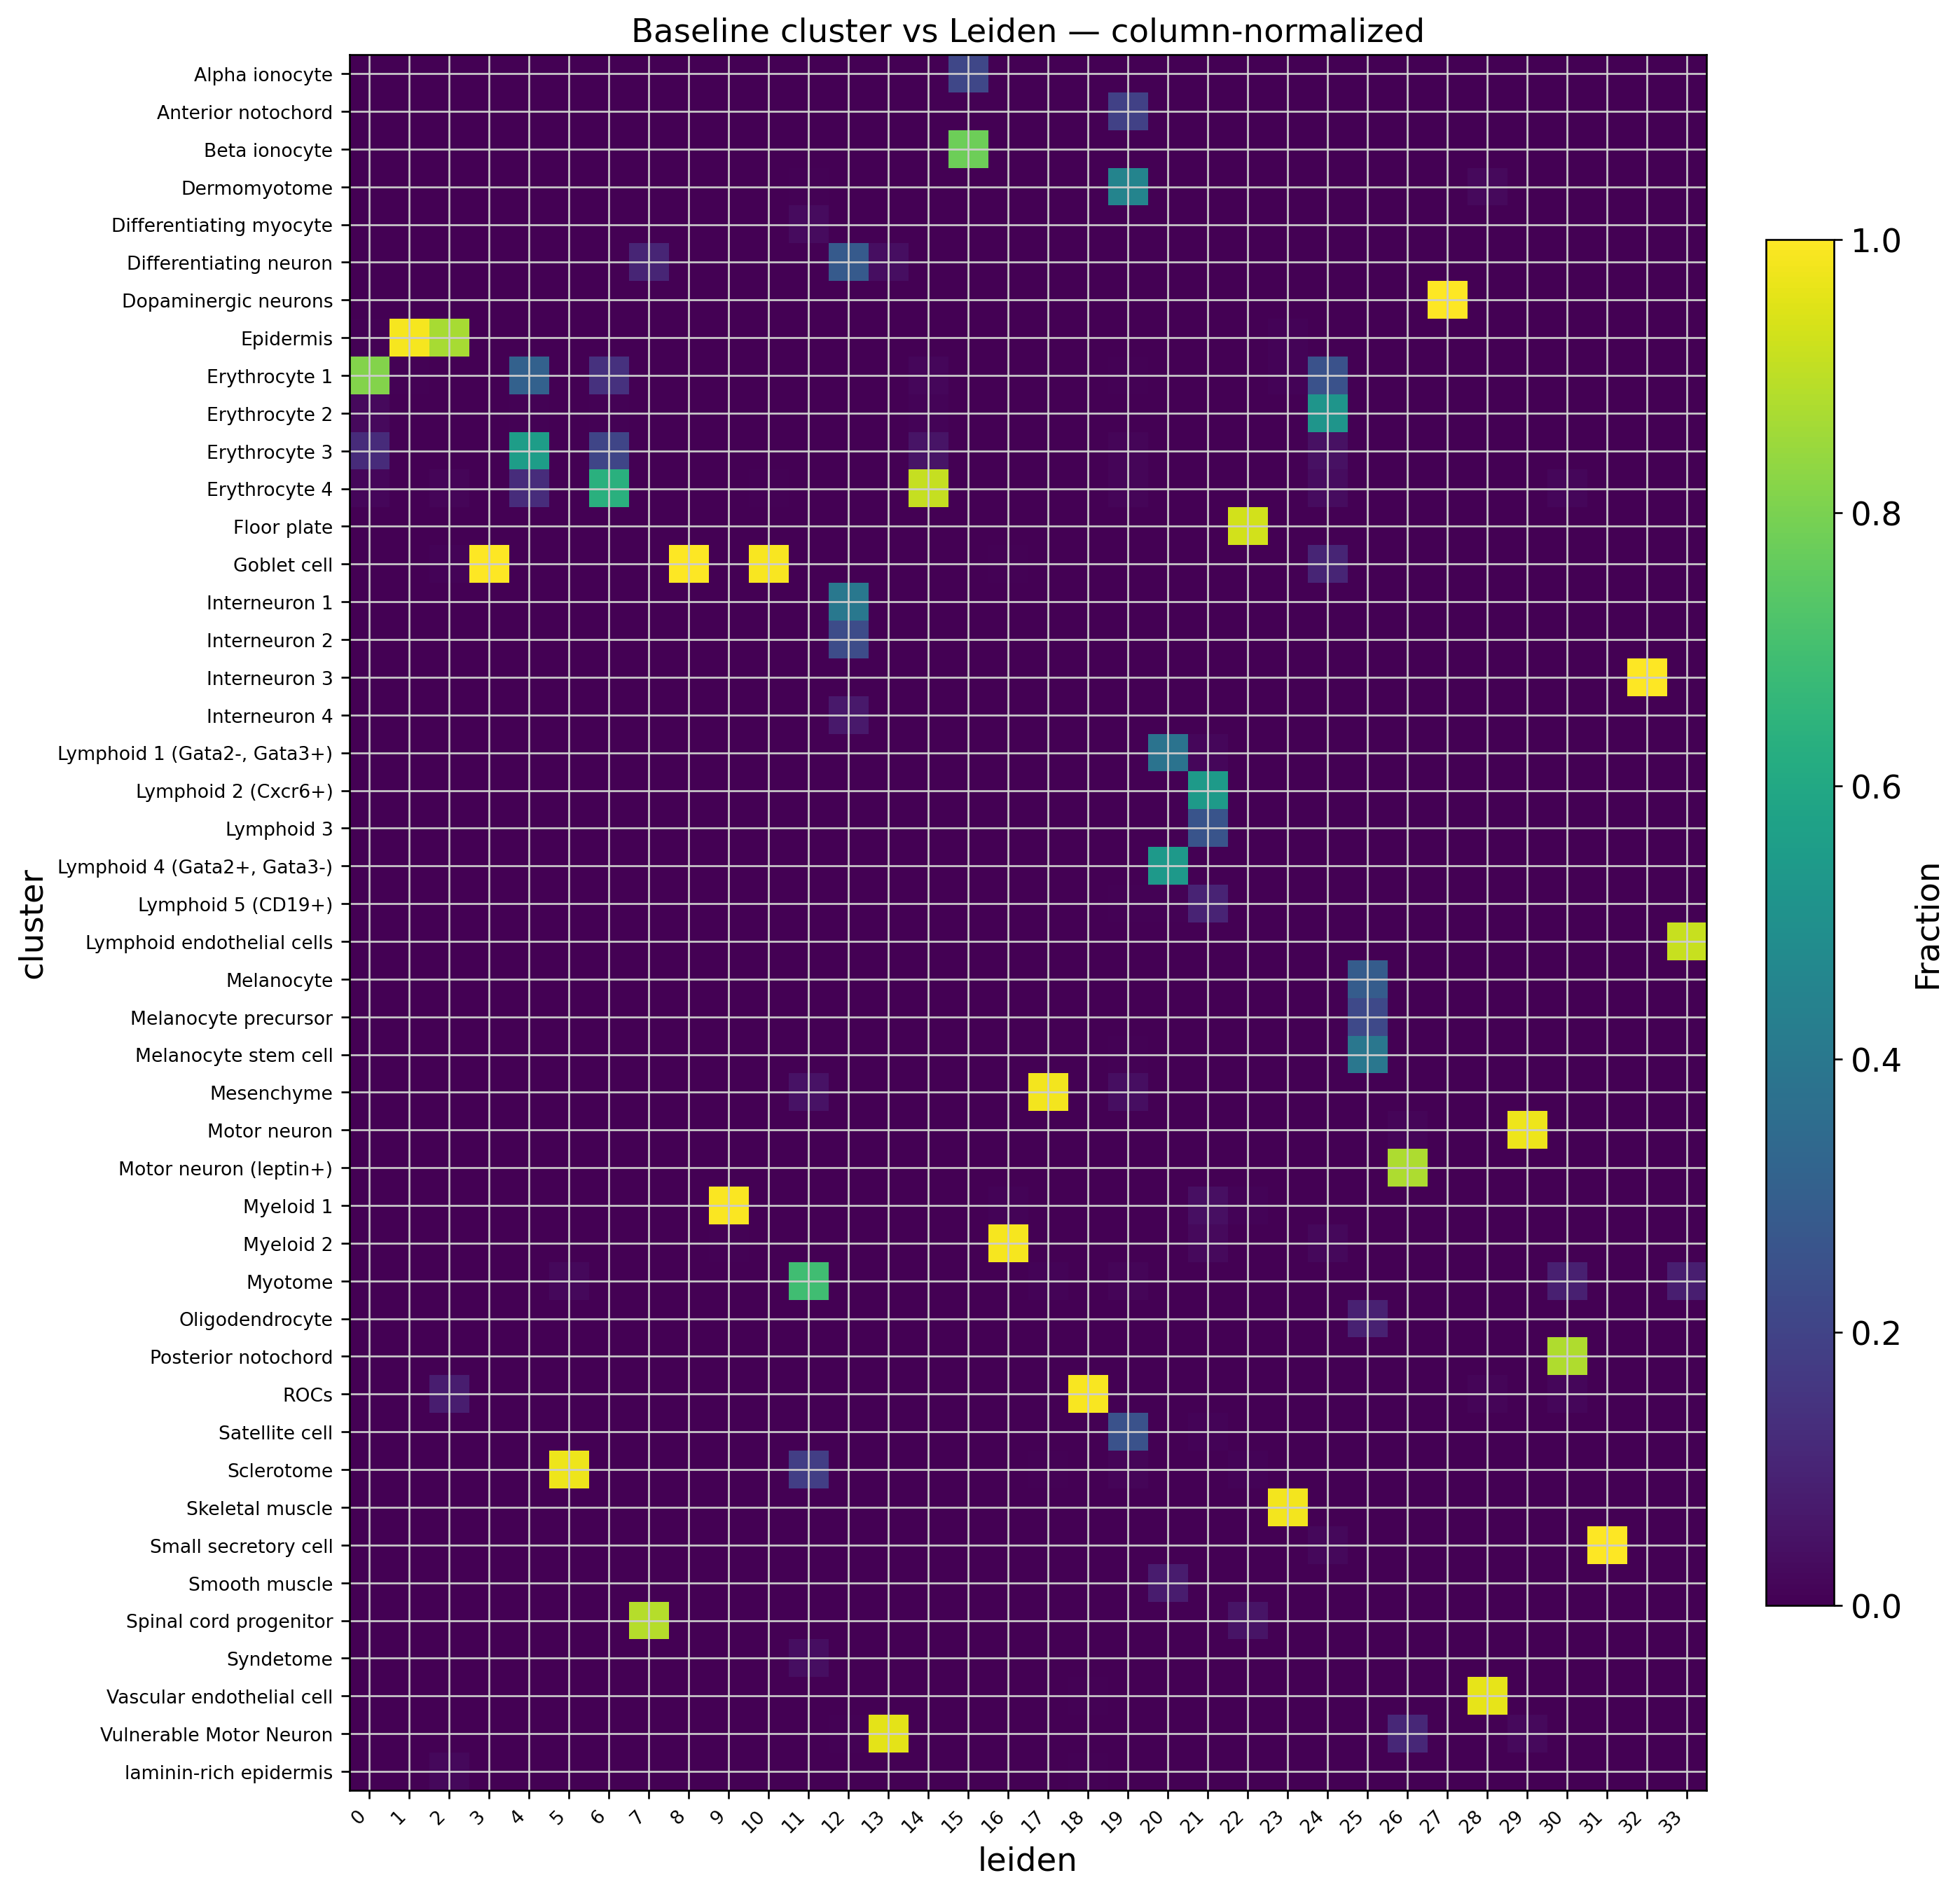

Walktrap vs Leiden — ARI: 0.637, Rand: 0.944


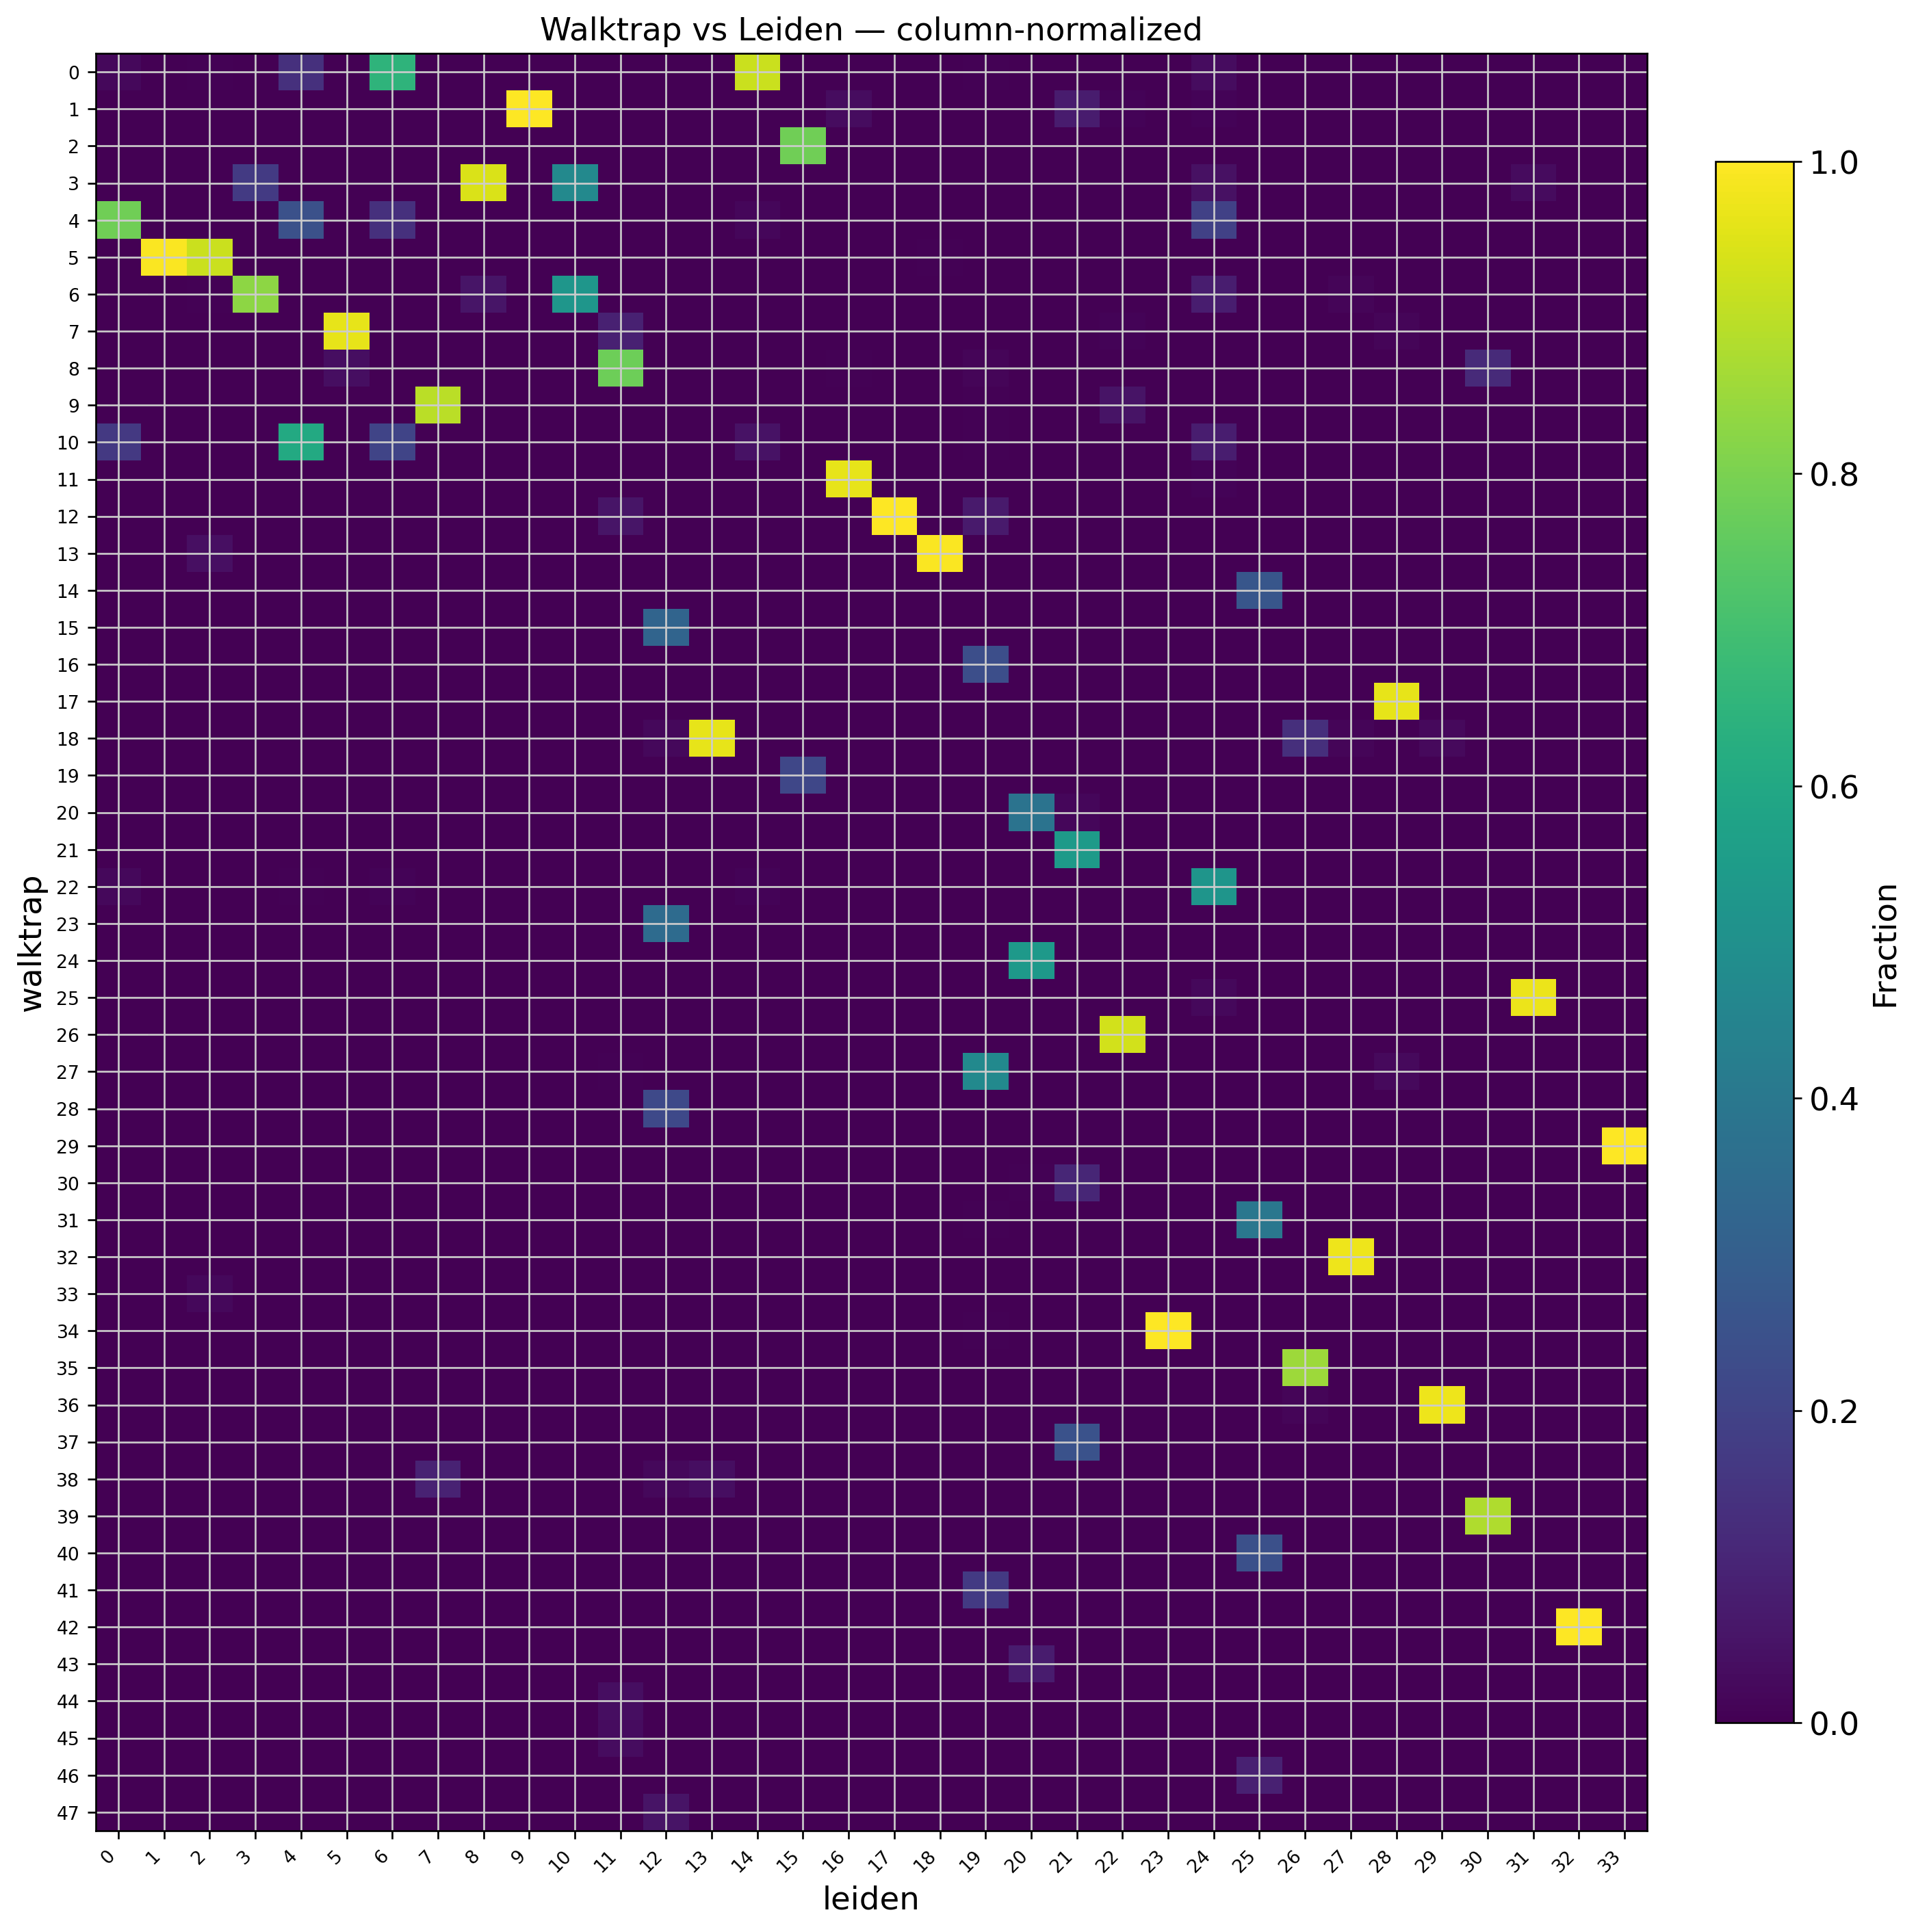

Updated: /content/drive/MyDrive/STAT4243/roc_outputs_final/metrics_baseline.json


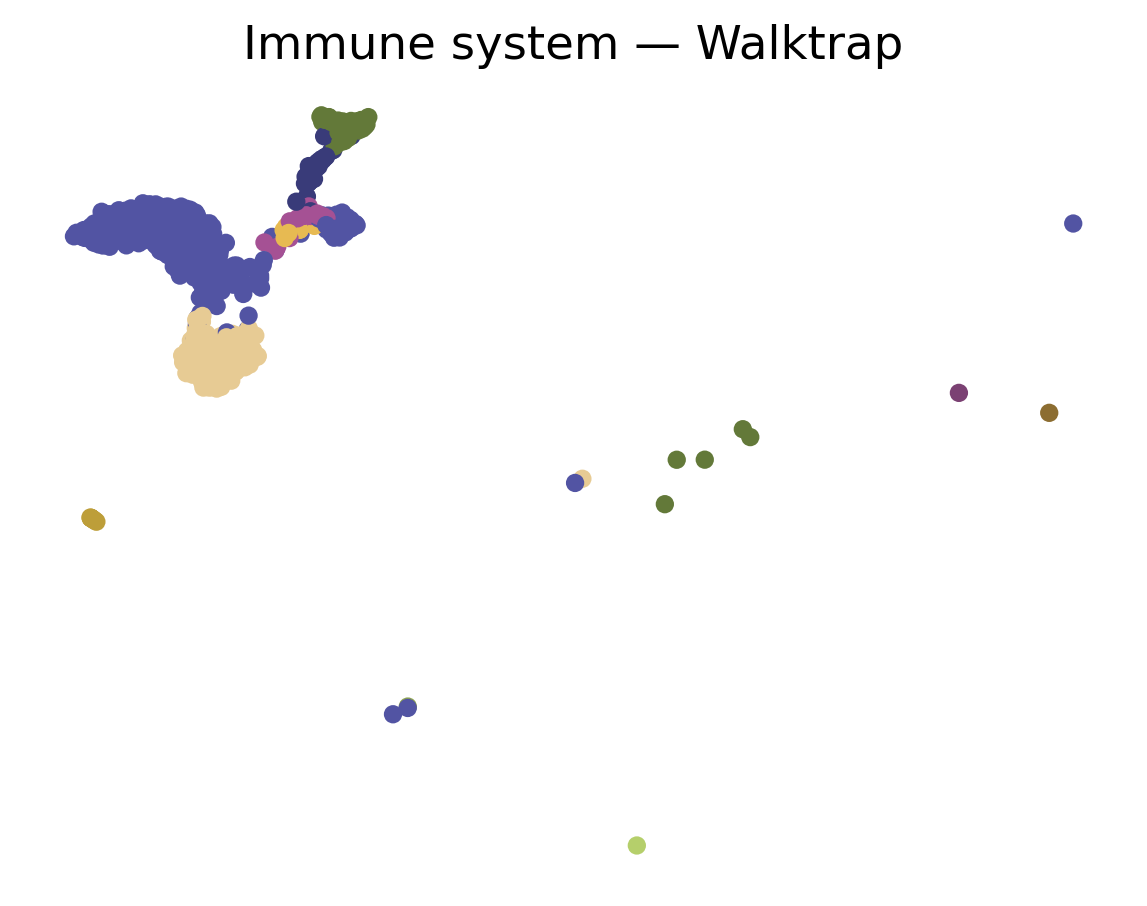

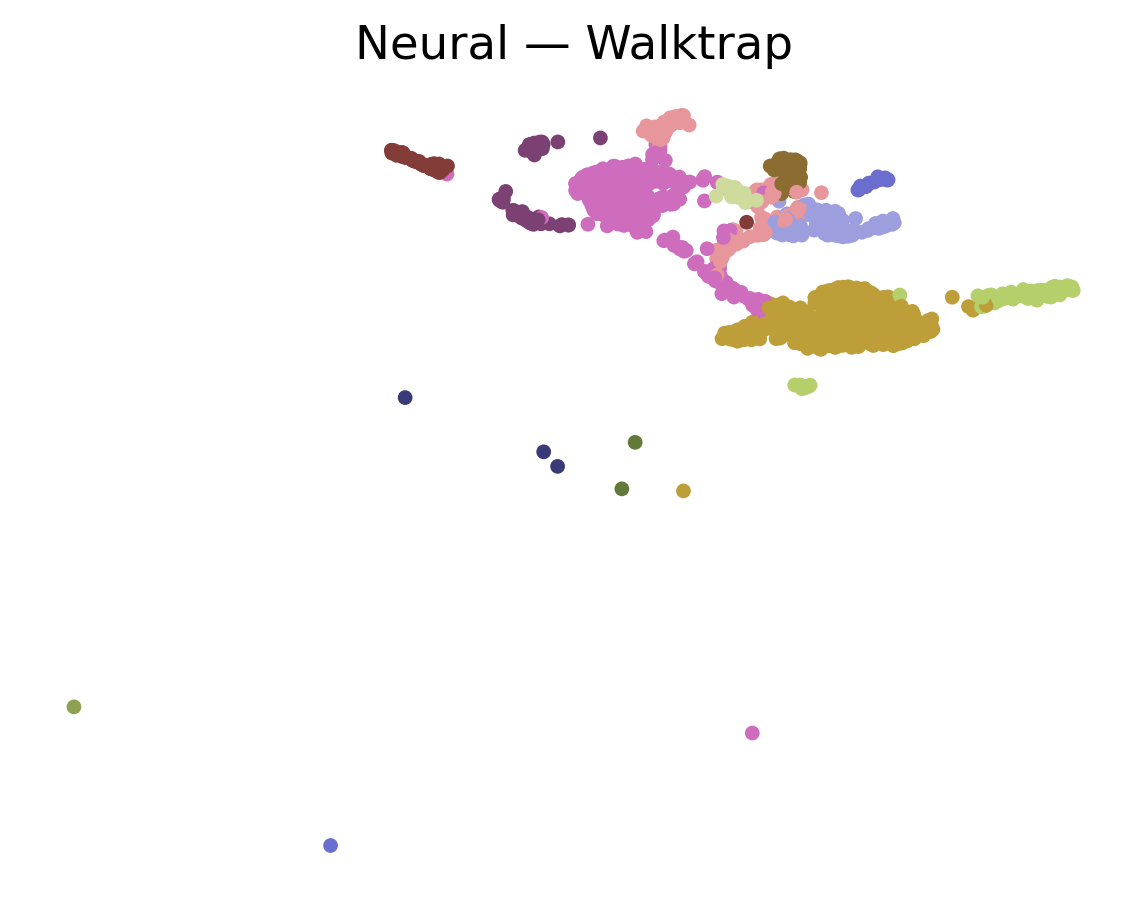

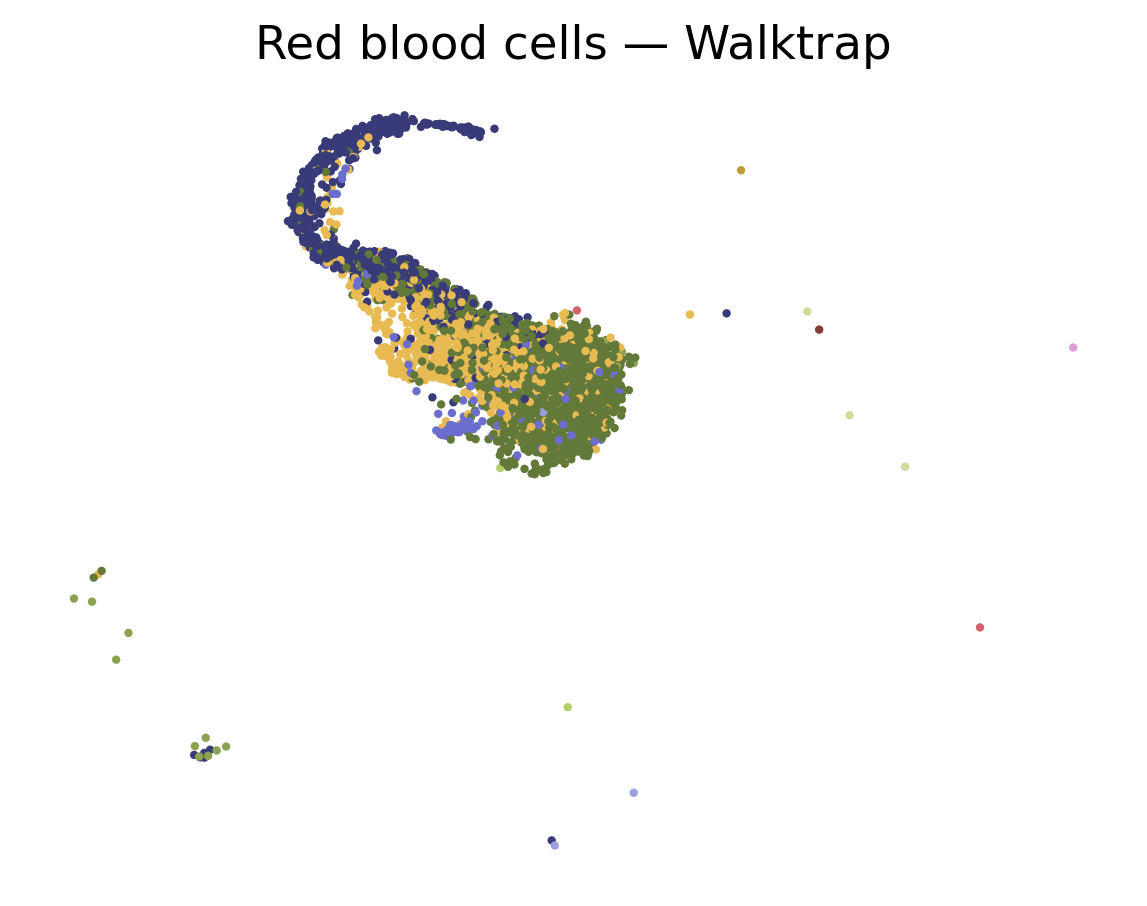

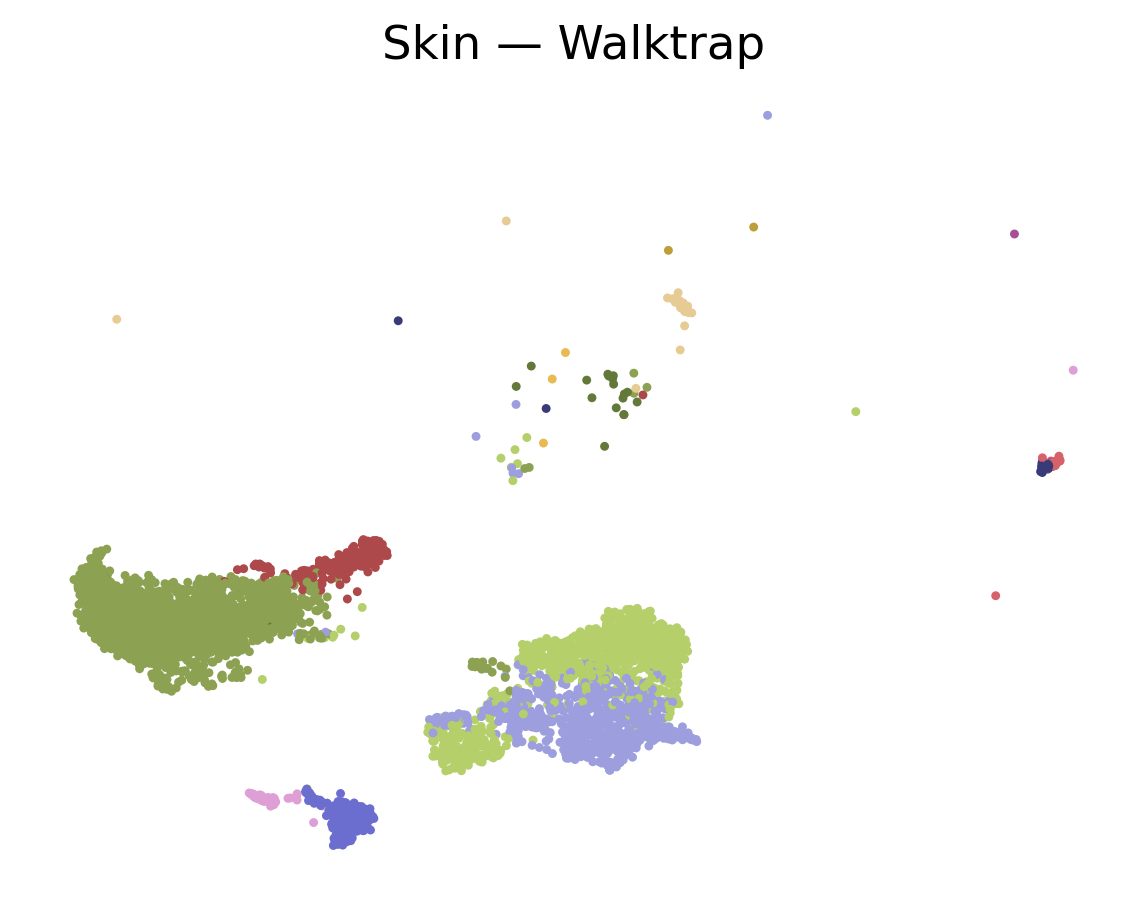

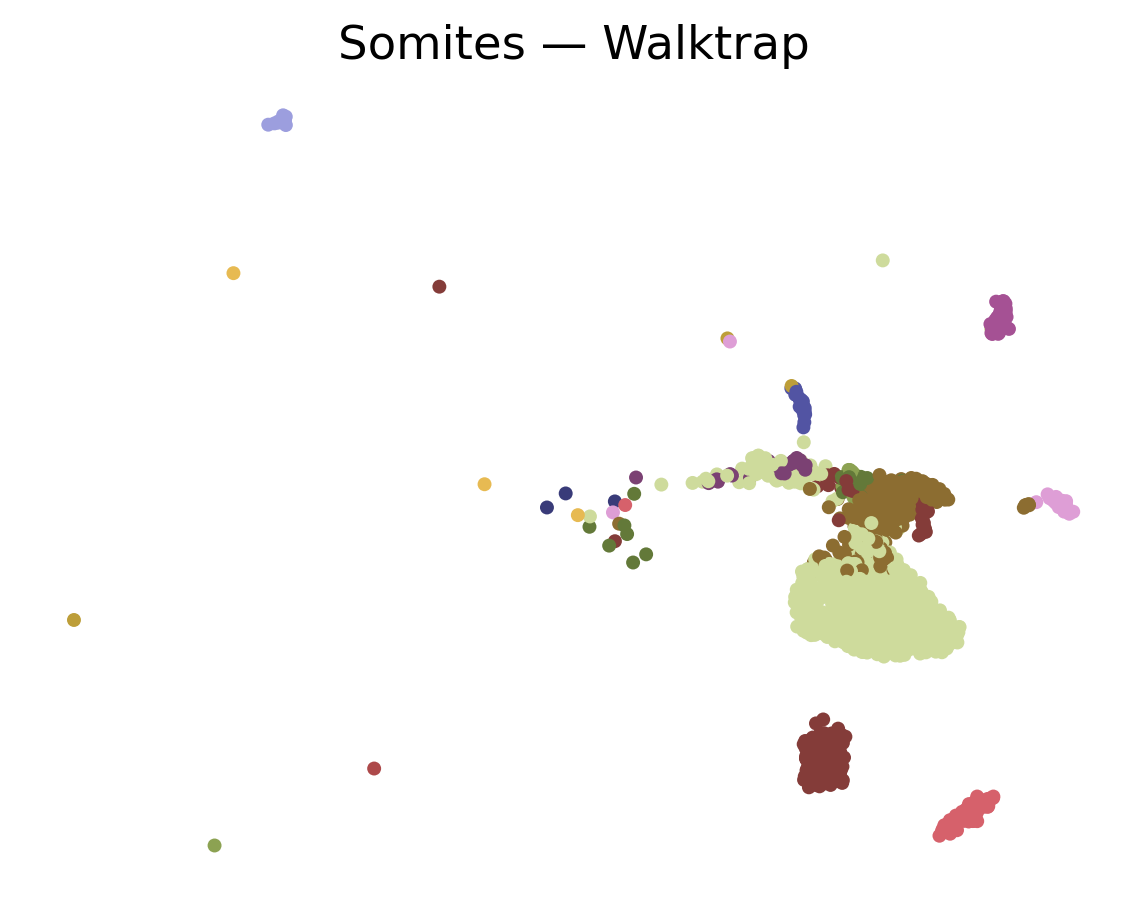

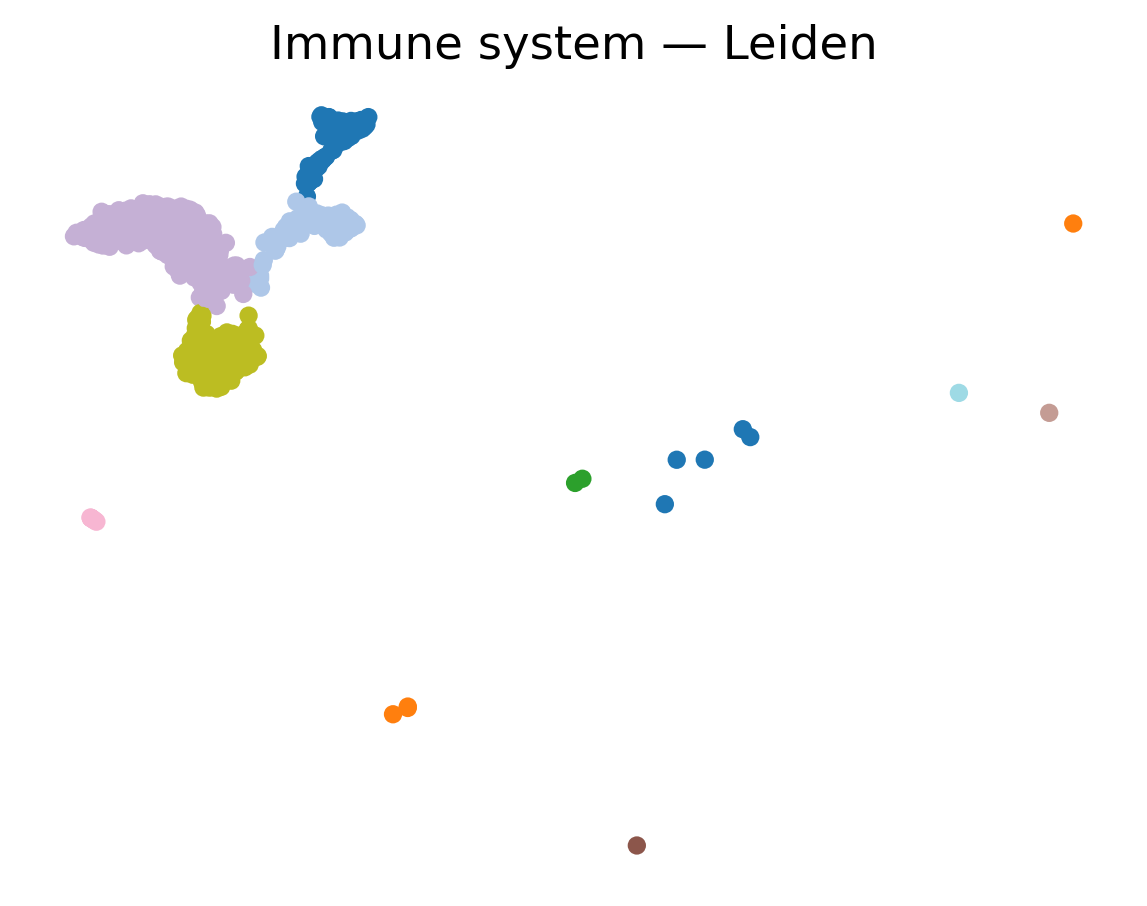

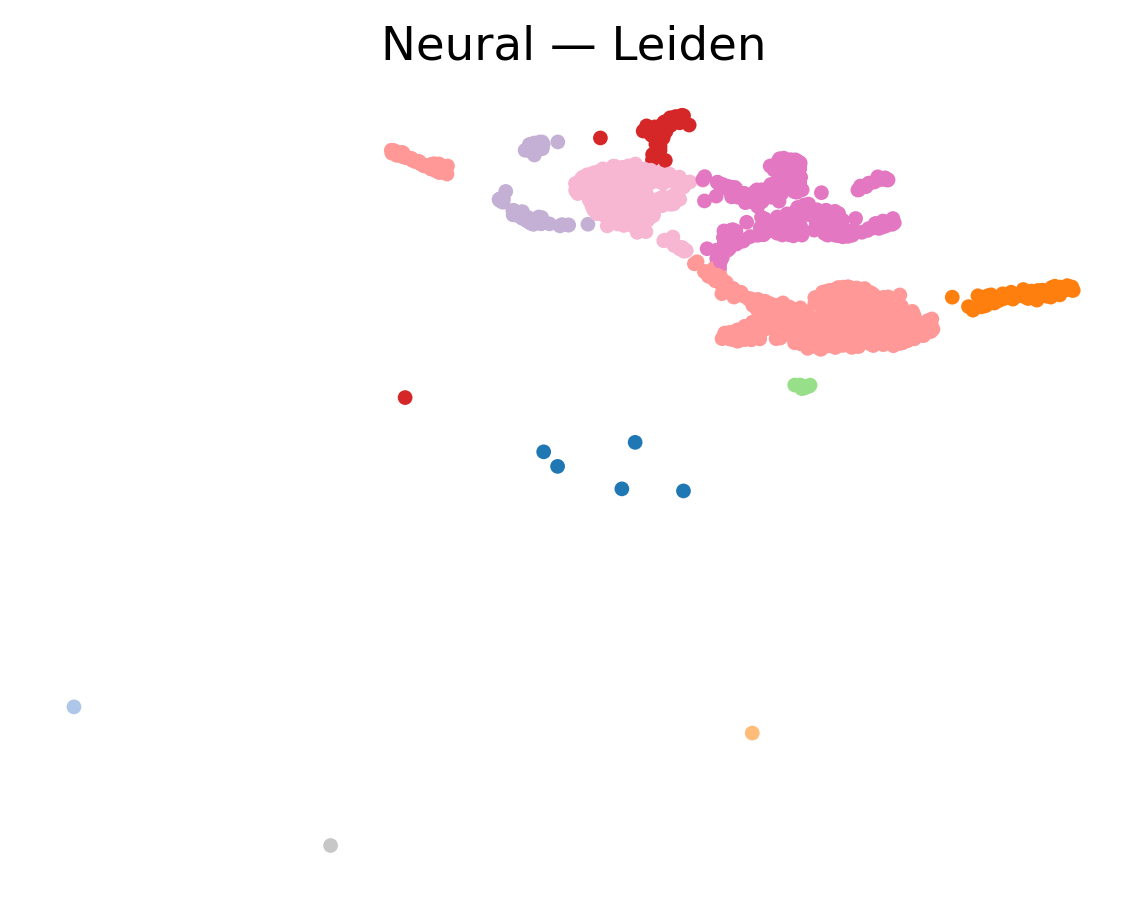

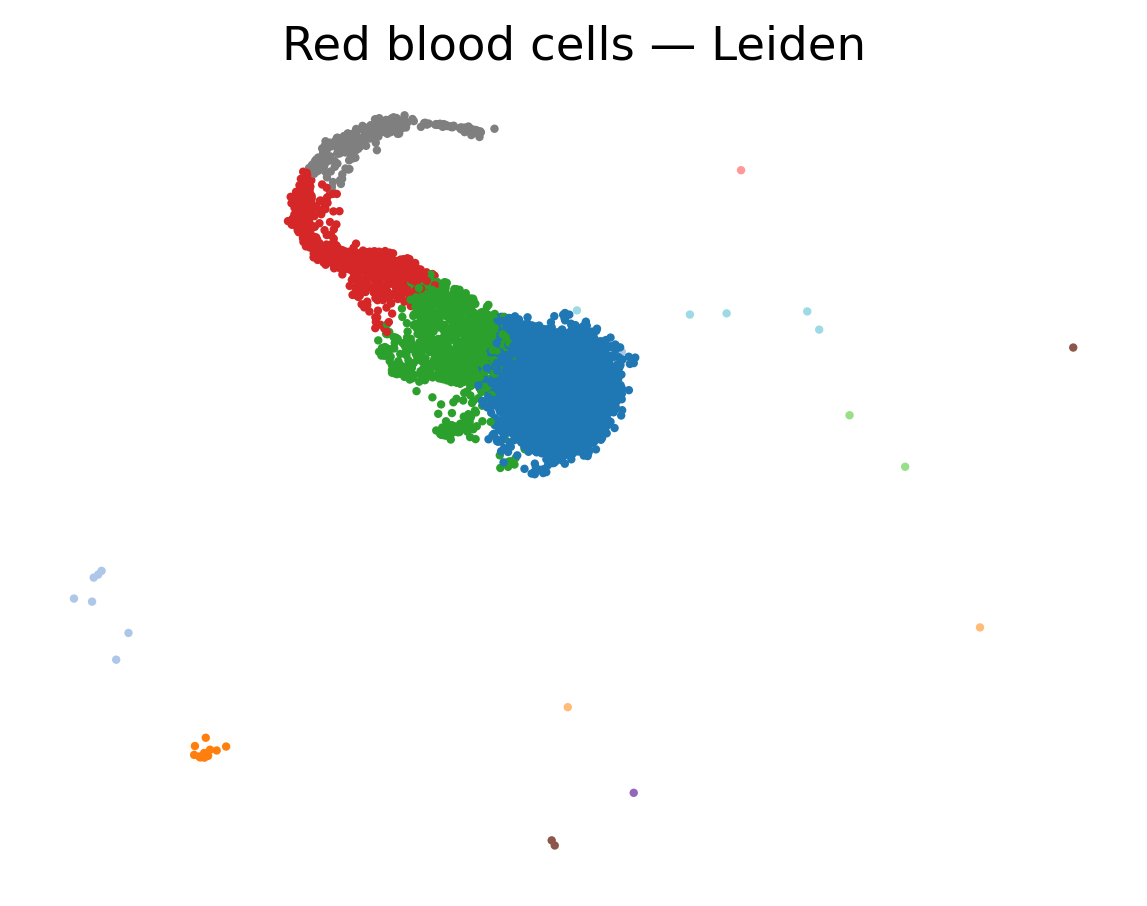

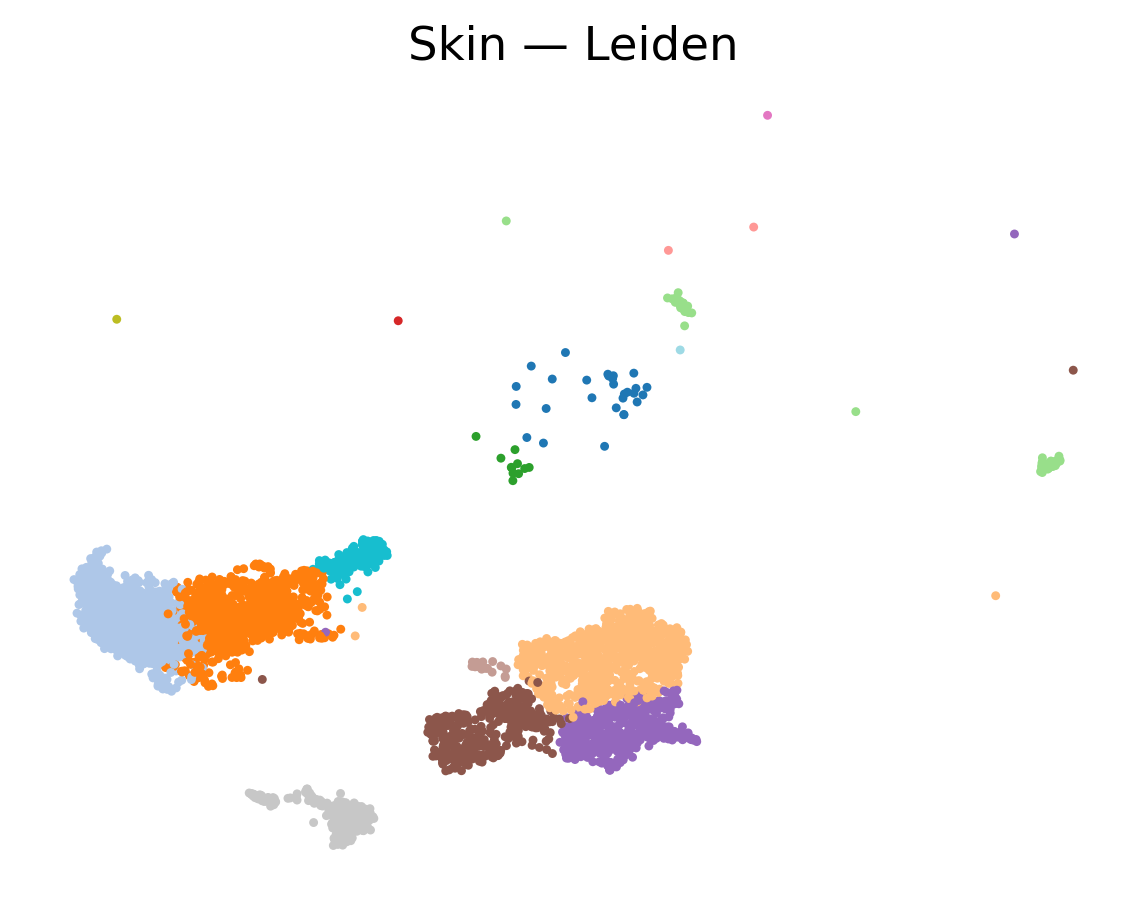

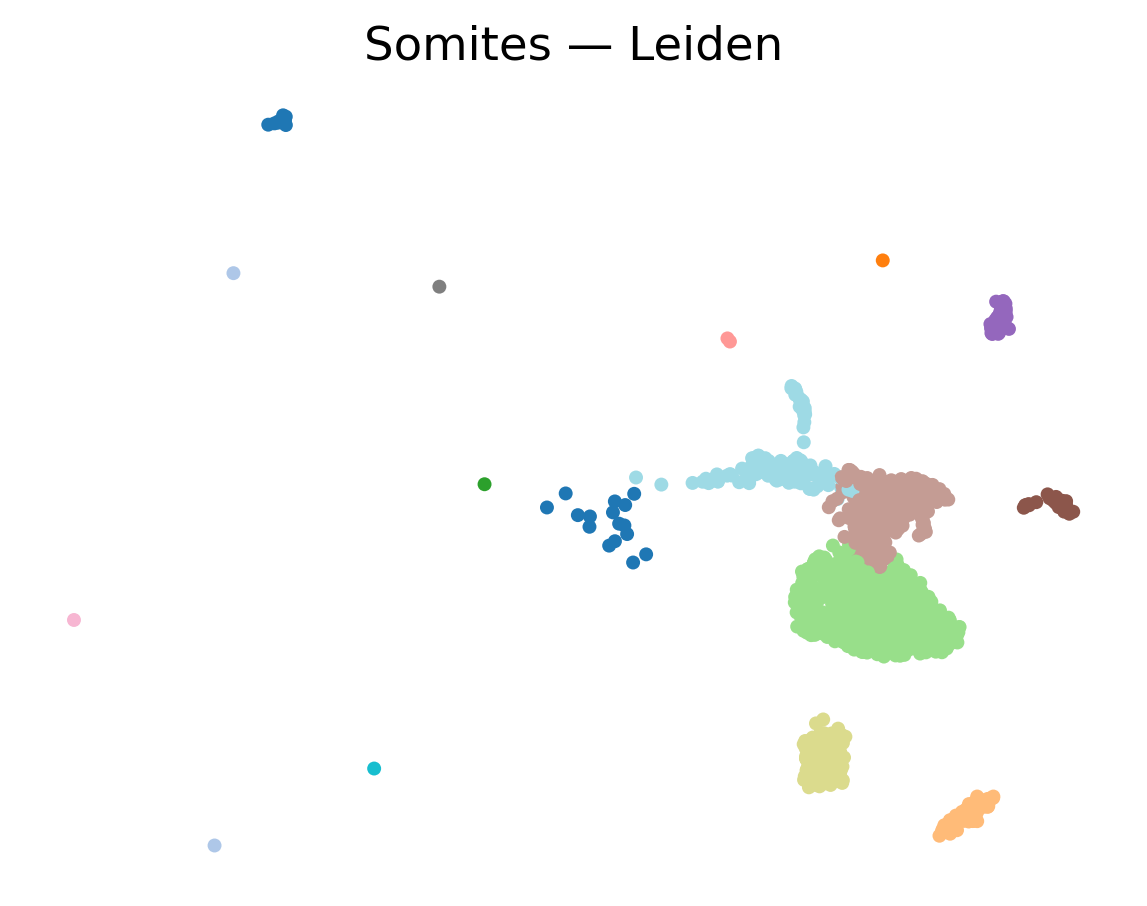

In [118]:
# === Figures B, B′, C, C′, and Walktrap↔Leiden agreement ===
#TODO: Clean up these imports
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score
import scanpy as sc

def ensure_cat(ser):
    if not pd.api.types.is_categorical_dtype(ser):
        return ser.astype("category")
    return ser

def save_legend(handles, title, outpath, ncols=None):
    n = len(handles)
    if ncols is None:
        ncols = 4 if n <= 32 else 6 if n <= 72 else 8
    fig = plt.figure(figsize=(min(16, 2 * ncols), 2 + 0.18 * (n // ncols + 1)))
    leg = fig.legend(handles=handles, loc="center", ncol=ncols, frameon=False, title=title)
    for txt in leg.get_texts(): txt.set_fontsize(8)
    if leg.get_title() is not None: leg.get_title().set_fontsize(9)
    plt.axis("off")
    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def make_palette(labels, cmap):
    """Return a list of RGBA colors matching the order of 'labels' using a matplotlib ListedColormap."""
    return [cmap(i % cmap.N) for i in range(len(labels))]

def plot_umap_color(adata, key, title, out_png, palette_key):
    ax = sc.pl.umap(adata, color=key, legend_loc=None, frameon=False, show=False, palette=adata.uns.get(palette_key, None))
    plt.title(title)
    plt.tight_layout()
    plt.gcf().savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(plt.gcf())

def confusion_heatmap(rows, cols, title, out_png, normalize="col"):
    """rows vs cols crosstab; normalize='col' scales each column to 1; 'row' scales rows."""
    ct = pd.crosstab(rows, cols)
    if normalize == "col":
        denom = ct.sum(axis=0).replace(0, np.nan)
        mat = ct.div(denom, axis=1).fillna(0.0).values
    elif normalize == "row":
        denom = ct.sum(axis=1).replace(0, np.nan)
        mat = ct.div(denom, axis=0).fillna(0.0).values
    else:
        mat = ct.values

    fig, ax = plt.subplots(figsize=(max(6, 0.35*ct.shape[1]), max(5, 0.25*ct.shape[0])))
    im = ax.imshow(mat, aspect="auto")
    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Fraction" if normalize else "Count")

    ax.set_xticks(range(ct.shape[1])); ax.set_xticklabels(ct.columns.astype(str), rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(ct.shape[0])); ax.set_yticklabels(ct.index.astype(str), fontsize=8)
    ax.set_xlabel(cols.name if hasattr(cols, "name") else "Cols")
    ax.set_ylabel(rows.name if hasattr(rows, "name") else "Rows")
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return ct

adata.obs["cluster"]  = ensure_cat(adata.obs["cluster"])
adata.obs["walktrap"] = ensure_cat(adata.obs["walktrap"])
adata.obs["leiden"]   = ensure_cat(adata.obs["leiden"])
if "category" in adata.obs:
    adata.obs["category"] = ensure_cat(adata.obs["category"])

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Figure B: Walktrap UMAP (distinct palette), + legend ---
wt_order = list(adata.obs["walktrap"].cat.categories)
# Use a distinct palette from baseline to avoid implying 1:1; e.g., tab20b or tab20
wt_cmap = plt.cm.tab20b
adata.uns["walktrap_colors"] = make_palette(wt_order, wt_cmap)

plot_umap_color(
    adata, key="walktrap",
    title="All cells — colored by Walktrap",
    out_png=os.path.join(OUTPUT_DIR, "figB_walktrap_umap.png"),
    palette_key="walktrap_colors"
)

wt_handles = [mpatches.Patch(color=adata.uns["walktrap_colors"][i], label=str(wt_order[i])) for i in range(len(wt_order))]
save_legend(wt_handles, "Walktrap", os.path.join(OUTPUT_DIR, "figB_walktrap_legend.png"))

# --- Figure B′: Confusion heatmap Baseline cluster vs Walktrap ---
ct_bw = confusion_heatmap(
    adata.obs["cluster"], adata.obs["walktrap"],
    title="Baseline cluster vs Walktrap — column-normalized",
    out_png=os.path.join(OUTPUT_DIR, "figBprime_confusion_cluster_vs_walktrap.png"),
    normalize="col"
)

# --- Figure C: Leiden UMAP (distinct palette), + legend ---
ld_order = list(adata.obs["leiden"].cat.categories)
ld_cmap = plt.cm.tab20  # a different tab palette (or any other colorblind-safe list)
adata.uns["leiden_colors"] = make_palette(ld_order, ld_cmap)

plot_umap_color(
    adata, key="leiden",
    title="All cells — colored by Leiden",
    out_png=os.path.join(OUTPUT_DIR, "figC_leiden_umap.png"),
    palette_key="leiden_colors"
)

ld_handles = [mpatches.Patch(color=adata.uns["leiden_colors"][i], label=str(ld_order[i])) for i in range(len(ld_order))]
save_legend(ld_handles, "Leiden", os.path.join(OUTPUT_DIR, "figC_leiden_legend.png"))

# --- Figure C′: Confusion heatmap Baseline cluster vs Leiden ---
ct_bl = confusion_heatmap(
    adata.obs["cluster"], adata.obs["leiden"],
    title="Baseline cluster vs Leiden — column-normalized",
    out_png=os.path.join(OUTPUT_DIR, "figCprime_confusion_cluster_vs_leiden.png"),
    normalize="col"
)

# --- Walktrap vs Leiden agreement (heatmap + ARI/Rand; update metrics file) ---
ARI_wt_ld  = float(adjusted_rand_score(adata.obs["walktrap"], adata.obs["leiden"]))
RAND_wt_ld = float(rand_score(adata.obs["walktrap"], adata.obs["leiden"]))
print(f"Walktrap vs Leiden — ARI: {ARI_wt_ld:.3f}, Rand: {RAND_wt_ld:.3f}")

ct_wl = confusion_heatmap(
    adata.obs["walktrap"], adata.obs["leiden"],
    title="Walktrap vs Leiden — column-normalized",
    out_png=os.path.join(OUTPUT_DIR, "figWL_confusion_walktrap_vs_leiden.png"),
    normalize="col"
)

# append to metrics_baseline.json if present
metrics_path = os.path.join(OUTPUT_DIR, "metrics_baseline.json")
try:
    metrics = {}
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
    metrics.setdefault("walktrap~leiden", {})
    metrics["walktrap~leiden"].update({"ARI": ARI_wt_ld, "Rand": RAND_wt_ld})
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Updated:", metrics_path)
except Exception as e:
    print("[warn] could not update metrics file:", e)

 #--- per-category UMAPs for Walktrap and Leiden ---
if "category" in adata.obs:
    # Walktrap per category
    color_lookup_wt = {wt_order[i]: adata.uns["walktrap_colors"][i] for i in range(len(wt_order))}
    for cat in adata.obs["category"].cat.categories:
        ad_sub = adata[adata.obs["category"] == cat].copy()
        ad_sub.obs["walktrap"] = ad_sub.obs["walktrap"].astype("category")
        wt_order_sub = list(ad_sub.obs["walktrap"].cat.categories)
        ad_sub.uns["walktrap_colors"] = [color_lookup_wt[w] for w in wt_order_sub]
        sc.pl.umap(ad_sub, color="walktrap", legend_loc=None, frameon=False,
                    title=f"{cat} — Walktrap", show=False)
        plt.tight_layout()
        plt.gcf().savefig(os.path.join(OUTPUT_DIR, f"figB_{cat}_walktrap_umap.png"), dpi=300, bbox_inches="tight")
        plt.show(); plt.close(plt.gcf())

    # Leiden per category
    color_lookup_ld = {ld_order[i]: adata.uns["leiden_colors"][i] for i in range(len(ld_order))}
    for cat in adata.obs["category"].cat.categories:
        ad_sub = adata[adata.obs["category"] == cat].copy()
        ad_sub.obs["leiden"] = ad_sub.obs["leiden"].astype("category")
        ld_order_sub = list(ad_sub.obs["leiden"].cat.categories)
        ad_sub.uns["leiden_colors"] = [color_lookup_ld[l] for l in ld_order_sub]
        sc.pl.umap(ad_sub, color="leiden", legend_loc=None, frameon=False,
                    title=f"{cat} — Leiden", show=False)
        plt.tight_layout()
        plt.gcf().savefig(os.path.join(OUTPUT_DIR, f"figC_{cat}_leiden_umap.png"), dpi=300, bbox_inches="tight")
        plt.show(); plt.close(plt.gcf())


## Clustering performance.

Add notes here



In [119]:
# === Show metrics inline for write-up + save tidy CSV ===
import os, json
import pandas as pd
from IPython.display import display

metrics_path = os.path.join(OUTPUT_DIR, "metrics_baseline.json")

# Load metrics dict (fall back to in-memory 'metrics' if present)
if os.path.exists(metrics_path):
    with open(metrics_path, "r") as f:
        m = json.load(f)
else:
    try:
        m = dict(metrics)  # from earlier cell
        print("[info] metrics_baseline.json not found; using in-memory 'metrics'")
    except NameError:
        raise FileNotFoundError("No metrics found on disk or in memory. Run the metrics cell first.")

# Flatten nested dict -> tidy dataframe: method | metric | value
rows = []
for method, kv in m.items():
    for metric_name, value in kv.items():
        rows.append({"method": method, "metric": metric_name, "value": float(value)})
tidy = pd.DataFrame(rows).sort_values(["method", "metric"]).reset_index(drop=True)

# Show in notebook
display(tidy)

# Save as CSV for the report appendix
out_csv = os.path.join(OUTPUT_DIR, "metrics_tidy.csv")
tidy.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# --- Optional: print a short blurb you can paste into your analysis ---
# Try to pull the usual suspects; if missing, print gracefully.
def getv(me, key, default=None):
    try:
        return float(m.get(me, {}).get(key, default))
    except Exception:
        return default

sil_wt = getv("walktrap", "silhouette_native_log2HVG_cosine")
sil_ld = getv("leiden",   "silhouette_PCA_cosine")
ari    = getv("walktrap~leiden", "ARI")
rand   = getv("walktrap~leiden", "Rand")

print("\n--- Draft write-up snippet ---")
parts = []
if sil_wt is not None:
    parts.append(f"Walktrap silhouette (native log2-HVG, cosine) = {sil_wt:.3f}")
if sil_ld is not None:
    parts.append(f"Leiden silhouette (PCA, cosine) = {sil_ld:.3f}")
if ari is not None and rand is not None:
    parts.append(f"Agreement between Walktrap and Leiden: ARI = {ari:.3f}, Rand = {rand:.3f}")
elif ari is not None:
    parts.append(f"Agreement between Walktrap and Leiden: ARI = {ari:.3f}")
elif rand is not None:
    parts.append(f"Agreement between Walktrap and Leiden: Rand = {rand:.3f}")

if parts:
    print(" • " + "\n • ".join(parts))
else:
    print("No standard metrics found; check metrics_baseline.json contents above.")


method                            metric     value
0           leiden             silhouette_PCA_cosine  0.319161
1         walktrap  silhouette_native_log2HVG_cosine  0.045835
2  walktrap~leiden                               ARI  0.636708
3  walktrap~leiden                              Rand  0.943558

Saved: /content/drive/MyDrive/STAT4243/roc_outputs_final/metrics_tidy.csv

--- Draft write-up snippet ---
 • Walktrap silhouette (native log2-HVG, cosine) = 0.046
 • Leiden silhouette (PCA, cosine) = 0.319
 • Agreement between Walktrap and Leiden: ARI = 0.637, Rand = 0.944



## Identify the ROC and key-gene overlays


In [120]:

#@title ROC scoring & flag
tbl = pd.ExcelFile(TABLE_S3_XLSX)
roc_tab = pd.read_excel(tbl, sheet_name="ROC markers")
roc_s3 = set(str(x).strip() for x in roc_tab.iloc[:,0].dropna())

cluster_key = "walktrap"
tokens = ["lef1","tp63","krt70","krt","wnt5a","wnt3a","wnt","fgf7","fgf9","fgf10","fgf20","sp8","sp9"]

def match_signature(var_names, tokens):
    out=[]; vlow=[v.lower() for v in var_names]
    for i,vl in enumerate(vlow):
        for t in tokens:
            if vl==t or vl.startswith(t+".") or (t in vl):
                out.append(var_names[i]); break
    return sorted(set(out))

genes = match_signature(adata.var_names, tokens)
if not genes and adata.raw is not None:
    genes = match_signature(adata.raw.var_names, tokens)
    df_all = pd.DataFrame(adata.raw.X if isinstance(adata.raw.X, np.ndarray) else adata.raw.X.toarray(),
                          index=adata.obs_names, columns=adata.raw.var_names)
else:
    df_all = adata.to_df()

labels = adata.obs[cluster_key].astype(str)
means = df_all.groupby(labels)[genes].mean()
means["sig_sum"] = means.sum(axis=1)
roc_cluster = str(means["sig_sum"].idxmax())

is_roc = labels.eq(str(roc_cluster)).to_numpy()
adata.obs["ROC_flag"] = pd.Categorical(
    np.where(is_roc, "ROC", "other"),
    categories=["other", "ROC"]
)


#print(adata.obs["ROC_flag"].dtype)
#print(adata.obs["ROC_flag"].value_counts())

print("ROC cluster:", roc_cluster, "| counts:", dict(adata.obs['ROC_flag'].value_counts()))

import re
lf = [g for g in genes if re.match("(?i)lef1(\.|$)", g)]
tp = [g for g in genes if re.match("(?i)tp63(\.|$)", g)]
sc.pl.umap(adata, color=["ROC_flag"], show=False); plt.savefig(f"{OUTPUT_DIR}/umap_ROCflag.png", bbox_inches="tight"); plt.close()
for g in lf[:1] + tp[:1]:
    sc.pl.umap(adata, color=g, show=False); plt.savefig(f"{OUTPUT_DIR}/gene_{g}.png", bbox_inches="tight"); plt.close()


ROC cluster: 13 | counts: {'other': np.int64(12985), 'ROC': np.int64(214)}


In [121]:
#@title Doing some sanity checks

if adata.raw is not None:
    X_all = adata.raw.X.A if hasattr(adata.raw.X, "A") else adata.raw.X
    var_all = adata.raw.var_names
    df_all = pd.DataFrame(X_all, index=adata.obs_names, columns=var_all)
else:
    var_all = adata.var_names
    df_all = adata.to_df()

def match_any(var_names, names, allow_generic=False):
    out = []
    vlow = [v.lower() for v in var_names]
    for i,vl in enumerate(vlow):
        for q in names:
            ql = q.lower()
            # allele-aware; optional generic substring match
            if vl == ql or vl.startswith(ql + ".") or (allow_generic and (ql in vl)):
                out.append(var_names[i]); break
    return sorted(set(out))

# Minimal ROC seed (very specific)
seed_strict = ["lef1","tp63","wnt5a","wnt3a","fgf7","fgf9","sp8","sp9","krt70"]
# Expanded seed from your previous list (can be too broad if allow_generic=True)
seed_expanded = ["lef1","tp63","krt70","krt","wnt5a","wnt3a","wnt","fgf7","fgf9","fgf10","fgf20","sp8","sp9"]

hits_strict   = match_any(var_all, seed_strict, allow_generic=False)
hits_expanded = match_any(var_all, seed_expanded, allow_generic=True)

print("STRICT hits (should be a focused set):", hits_strict[:30], f"(n={len(hits_strict)})")
print("EXPANDED hits (may include many family members):", hits_expanded[:30], f"(n={len(hits_expanded)})")

# Rank clusters by mean signature for each list
lab = adata.obs["walktrap"].astype(str)
m_strict   = df_all.groupby(lab)[hits_strict].mean().assign(sig_sum=lambda d: d.sum(axis=1)).sort_values("sig_sum", ascending=False) if hits_strict else None
m_expanded = df_all.groupby(lab)[hits_expanded].mean().assign(sig_sum=lambda d: d.sum(axis=1)).sort_values("sig_sum", ascending=False) if hits_expanded else None

print("\nTop clusters by STRICT signature:\n", (m_strict[["sig_sum"]].head(10) if m_strict is not None else "no strict hits"))
print("\nTop clusters by EXPANDED signature:\n", (m_expanded[["sig_sum"]].head(10) if m_expanded is not None else "no expanded hits"))

# Also inspect LEF1/TP63 individually (allele-aware)
def pick_first(name):
    cand = [g for g in var_all if re.match(fr"(?i)^{name}(\.|$)", g)]
    return cand[0] if cand else None

lef1 = pick_first("lef1"); tp63 = pick_first("tp63")
if lef1 or tp63:
    cols = [g for g in [lef1, tp63] if g is not None]
    m_core = df_all.groupby(lab)[cols].mean().sort_values(cols, ascending=False)
    print("\nClusters ranked by LEF1/TP63 means:\n", m_core.head(10))
else:
    print("\nLEF1/TP63 not found (check gene naming / alleles).")

STRICT hits (should be a focused set): ['fgf7.L', 'fgf7.S', 'fgf9.L', 'fgf9.S', 'lef1.L', 'lef1.S', 'sp8.L', 'sp8.S', 'sp9.L', 'sp9.S', 'tp63.L', 'tp63.S', 'wnt3a.L', 'wnt3a.S', 'wnt5a.L', 'wnt5a.S'] (n=16)
EXPANDED hits (may include many family members): ['casp8ap2.L', 'casp9.S', 'dusp9.L', 'fgf10.L', 'fgf10.S', 'fgf20.L', 'fgf20.S', 'fgf7.L', 'fgf7.S', 'fgf9.L', 'fgf9.S', 'hsp90aa1.1.L', 'hsp90ab1.S', 'hsp90b1.L', 'krt.L', 'krt.S', 'krt12.L', 'krt12.S', 'krt14.L', 'krt15.L', 'krt16.L', 'krt16.S', 'krt17.L', 'krt17.S', 'krt18.L', 'krt18.S', 'krt19.L', 'krt222.L', 'krt222.S', 'krt24.like.1.L'] (n=96)

Top clusters by STRICT signature:
             sig_sum
walktrap           
13        13.270974
33         3.755122
41         3.390788
6          3.163773
38         3.021147
5          2.910263
36         2.347228
12         2.335331
47         2.199695
18         1.601399

Top clusters by EXPANDED signature:
             sig_sum
walktrap           
13        54.307831
33        38.23865


## Markers (logreg & Wilcoxon) and comparison to Table S3


In [122]:

#@title Rank ROC markers & compare to Table S3

sc.tl.rank_genes_groups(adata, groupby="ROC_flag", groups=["ROC", "other"], reference="rest", method="logreg", n_genes=300)
logreg_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(method="logreg")
sc.tl.rank_genes_groups(adata, groupby="ROC_flag", groups=["ROC", "other"], reference="rest", method="wilcoxon", n_genes=300)
wilcox_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(method="wilcoxon")
logreg_top = logreg_df.copy()
wilcoxon_top = wilcox_df.copy()
markers_df = pd.concat([logreg_df, wilcox_df], ignore_index=True)
markers_df.to_csv(f"{OUTPUT_DIR}/ROC_markers_logreg_wilcoxon.csv", index=False)

def canon(s):
    import re
    s=str(s).lower()
    return re.sub(r"\.(l|s)$", "", s)

top100 = set(map(canon, logreg_df.head(100)["names"])) | set(map(canon, wilcox_df.head(100)["names"]))
roc_s3_canon = set(map(canon, roc_s3))
overlap = sorted(list(top100 & roc_s3_canon))
only_nb = sorted(list(top100 - roc_s3_canon))
only_tbl = sorted(list(roc_s3_canon - top100))

pd.DataFrame({"overlap":overlap}).to_csv(f"{OUTPUT_DIR}/overlap_ROC_vs_S3.csv", index=False)
pd.DataFrame({"only_notebook":only_nb}).to_csv(f"{OUTPUT_DIR}/only_notebook.csv", index=False)
pd.DataFrame({"only_tableS3":only_tbl}).to_csv(f"{OUTPUT_DIR}/only_tableS3.csv", index=False)
print("Overlap n:", len(overlap), "| examples:", overlap[:15])

# Volcano from Wilcoxon if fields exist
if {"logfoldchanges","pvals_adj","names"}.issubset(wilcox_df.columns):
    x = wilcox_df["logfoldchanges"].astype(float).values
    y = -np.log10(wilcox_df["pvals_adj"].astype(float).clip(1e-300)).values
    plt.figure(figsize=(5,4))
    plt.scatter(x, y, s=6, alpha=0.6)
    for tag in ["lef1","tp63","wnt5a","fgf7","fgf9","sp8","sp9"]:
        cand = [n for n in wilcox_df["names"] if n.lower().startswith(tag)]
        if cand:
            i = wilcox_df.index[wilcox_df["names"]==cand[0]][0]
            plt.text(x[i], y[i], cand[0], fontsize=8)
    plt.xlabel("log2 fold change"); plt.ylabel("-log10 adj p"); plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/figure_gene_analysis_volcano.png", dpi=200, bbox_inches="tight"); plt.close()


Overlap n: 21 | examples: ['bmp5', 'cpa6', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'frem2', 'igfbp2', 'jag1', 'krt', 'lamb1', 'lef1', 'lpar3', 'nid2', 'pltp']


In [123]:
#@title Exploring results

# assumes: logreg_df, wilcox_df, roc_s3, canon() exist
top100 = set(map(canon, logreg_df.head(100)["names"])) | set(map(canon, wilcox_df.head(100)["names"]))
roc_s3_canon = set(map(canon, roc_s3))
overlap = top100 & roc_s3_canon

# Jaccard
jacc = len(overlap) / max(1, len(top100 | roc_s3_canon))
print(f"Overlap={len(overlap)}  Jaccard={jacc:.3f}")

# Hypergeometric enrichment
from scipy.stats import hypergeom
N = (adata.raw.n_vars if adata.raw is not None else adata.n_vars)   # universe size
K = len(roc_s3_canon)                                               # S3 size
n = len(top100)                                                     # your top list size
x = len(overlap)                                                    # observed overlap
pval = hypergeom.sf(x-1, N, K, n)
print(f"Hypergeom enrichment p={pval:.2e} (N={N}, K={K}, n={n}, x={x})")


Overlap=21  Jaccard=0.144
Hypergeom enrichment p=7.99e-40 (N=31535, K=44, n=123, x=21)


In [124]:
core = ["lef1","tp63","wnt5a","wnt3a","fgf7","fgf9","sp8","sp9","krt70"]
def rank_in(df, gene):
    g = [n for n in df["names"] if canon(n)==gene]
    if not g: return None
    return int(df.index[df["names"]==g[0]][0]) + 1  # 1-based rank

print("Wilcoxon ranks:")
for g in core:
    print(g, rank_in(wilcox_df.sort_values("pvals_adj"), g))

print("\nLogReg ranks:")
for g in core:
    print(g, rank_in(logreg_df.sort_values("scores", ascending=False), g))

Wilcoxon ranks:
lef1 137
tp63 242
wnt5a 280
wnt3a None
fgf7 136
fgf9 91
sp8 206
sp9 113
krt70 None

LogReg ranks:
lef1 33
tp63 None
wnt5a 185
wnt3a None
fgf7 29
fgf9 11
sp8 117
sp9 25
krt70 None


In [125]:
def topk_set(df, k, key="names"): return set(map(canon, df.head(k)[key]))
for k in (100, 200, 500):
    top_union = topk_set(logreg_df, k) | topk_set(wilcox_df, k)
    ov = top_union & roc_s3_canon
    print(f"k={k}: overlap={len(ov)}  Jaccard={len(ov)/len(top_union|roc_s3_canon):.3f}")

k=100: overlap=21  Jaccard=0.144
k=200: overlap=26  Jaccard=0.093
k=500: overlap=32  Jaccard=0.079


In [126]:
s3_curated = {g for g in roc_s3_canon if not re.fullmatch(r"krt", g)}
ov_curated = top100 & s3_curated
print(f"Overlap (curated, no generic 'krt') = {len(ov_curated)}  vs raw {len(overlap)}")

Overlap (curated, no generic 'krt') = 20  vs raw 21


In [127]:
top_all = pd.concat([logreg_df.assign(src="logreg"), wilcox_df.assign(src="wilcox")], ignore_index=True)
top_all["canon"] = top_all["names"].map(canon)
hits = top_all[top_all["canon"].isin(roc_s3_canon)].copy()
cols = [c for c in ["names","logfoldchanges","scores","pvals_adj","src"] if c in hits.columns]
display(hits[cols].sort_values(["src","pvals_adj"]))

names  logfoldchanges     scores     pvals_adj     src
3            pltp.S             NaN   0.174340           NaN  logreg
7            nid2.L             NaN   0.131452           NaN  logreg
8           lpar3.L             NaN   0.131381           NaN  logreg
10           fgf9.L             NaN   0.118719           NaN  logreg
24            sp9.L             NaN   0.093722           NaN  logreg
..              ...             ...        ...           ...     ...
563          dlx2.L        5.248654  10.971337  5.975710e-26  wilcox
572         frem2.S        4.304312  10.839272  2.463979e-25  wilcox
573  loc100488523.L        5.332430  10.838883  2.465882e-25  wilcox
594         lamb1.S        4.121986  10.367617  3.495937e-23  wilcox
598           krt.L        7.512284  10.315751  5.912722e-23  wilcox

[69 rows x 5 columns]

In [128]:
#@title Rank ROC markers & compare to Table S3 using RAW

# --- DE on existing ROC_flag, using ALL genes (raw) ---
# 1) Logistic regression (multi-class), class-weighted to counter ROC imbalance
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC", "other"],
    method="logreg",
    n_genes=500,             # bump a bit so we can take top-150 union later
    use_raw=True,
    class_weight="balanced",
    max_iter=4000,
    solver="liblinear"
)
logreg_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(method="logreg_bal")

# 2) Wilcoxon (one-vs-rest) on raw
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC"],
    reference="rest",
    method="wilcoxon",
    n_genes=500,
    use_raw=True
)
wilcox_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(method="wilcoxon")

# 3) Third method: t-test_overestim_var
sc.tl.rank_genes_groups(
    adata,
    groupby="ROC_flag",
    groups=["ROC"],
    reference="rest",
    method="t-test_overestim_var",
    n_genes=500,
    use_raw=True
)
ttov_df = sc.get.rank_genes_groups_df(adata, group="ROC").assign(method="tt_overvar")

# ---- Save combined table (so you have one CSV) ----
markers_df = pd.concat([logreg_df, wilcox_df, ttov_df], ignore_index=True)
markers_df.to_csv(f"{OUTPUT_DIR}/ROC_markers_allmethods_raw.csv", index=False)

# ---- Overlap vs Table S3 (allele-agnostic), try a slightly larger topK union ----
def canon(s):
    import re
    return re.sub(r"\.(l|s)$","", str(s).lower())

roc_s3_canon = set(map(canon, roc_s3))

def topk(df, k):
    return set(map(canon, df.head(k)["names"]))

for K in (100, 150, 200):
    top_union = topk(logreg_df, K) | topk(wilcox_df, K) | topk(ttov_df, K)
    overlap = sorted(top_union & roc_s3_canon)
    print(f"Top{K} union overlap = {len(overlap)}  (examples: {overlap[:15]})")
    # write files for K=150 (good middle ground)
    if K == 150:
        pd.DataFrame({"overlap": overlap}).to_csv(f"{OUTPUT_DIR}/overlap_ROC_vs_S3_raw_top{K}.csv", index=False)



top100 = set(map(canon, logreg_df.head(100)["names"])) | set(map(canon, wilcox_df.head(100)["names"]))
roc_s3_canon = set(map(canon, roc_s3))
overlap = sorted(list(top100 & roc_s3_canon))
only_nb = sorted(list(top100 - roc_s3_canon))
only_tbl = sorted(list(roc_s3_canon - top100))

pd.DataFrame({"overlap":overlap}).to_csv(f"{OUTPUT_DIR}/overlap_ROC_vs_S3_raw.csv", index=False)
pd.DataFrame({"only_notebook":only_nb}).to_csv(f"{OUTPUT_DIR}/only_notebook.csv_raw", index=False)
pd.DataFrame({"only_tableS3":only_tbl}).to_csv(f"{OUTPUT_DIR}/only_tableS3.csv_raw", index=False)
print("Overlap n:", len(overlap), "| examples:", overlap[:15])

# Volcano from Wilcoxon if fields exist
if {"logfoldchanges","pvals_adj","names"}.issubset(wilcox_df.columns):
    x = wilcox_df["logfoldchanges"].astype(float).values
    y = -np.log10(wilcox_df["pvals_adj"].astype(float).clip(1e-300)).values
    plt.figure(figsize=(5,4))
    plt.scatter(x, y, s=6, alpha=0.6)
    for tag in ["lef1","tp63","wnt5a","fgf7","fgf9","sp8","sp9"]:
        cand = [n for n in wilcox_df["names"] if n.lower().startswith(tag)]
        if cand:
            i = wilcox_df.index[wilcox_df["names"]==cand[0]][0]
            plt.text(x[i], y[i], cand[0], fontsize=8)
    plt.xlabel("log2 fold change"); plt.ylabel("-log10 adj p"); plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/figure_gene_analysis_volcano_raw.png", dpi=200, bbox_inches="tight"); plt.close()

Top100 union overlap = 21  (examples: ['bmp5', 'cpa6', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'frem2', 'igfbp2', 'jag1', 'krt', 'lamb1', 'lef1', 'lpar3', 'nid2', 'pltp'])
Top150 union overlap = 25  (examples: ['bmp5', 'cpa6', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'fgfr4', 'frem2', 'igfbp2', 'jag1', 'krt', 'lamb1', 'lamb2', 'lef1', 'lpar3'])
Top200 union overlap = 29  (examples: ['bmp5', 'cpa6', 'dlx2', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'fgfr4', 'frem2', 'igfbp2', 'ism2', 'jag1', 'krt', 'lamb1', 'lamb2'])
Overlap n: 21 | examples: ['bmp5', 'cpa6', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'frem2', 'igfbp2', 'jag1', 'krt', 'lamb1', 'lef1', 'lpar3', 'nid2', 'pltp']


In [129]:
from scipy.stats import hypergeom
def topk(df, k): return set(map(canon, df.head(k)["names"]))
roc_s3_canon = set(map(canon, roc_s3))
N = adata.raw.n_vars if adata.raw is not None else adata.n_vars
K = len(roc_s3_canon)

for Ktop in (100, 150, 200):
    top_union = topk(logreg_df, Ktop) | topk(wilcox_df, Ktop)
    x = len(top_union & roc_s3_canon)
    n = len(top_union)
    p = hypergeom.sf(x-1, N, K, n)
    print(f"Top{Ktop}: overlap={x}/{n}, p={p:.2e}")

Top100: overlap=21/126, p=1.38e-39
Top150: overlap=23/195, p=7.44e-40
Top200: overlap=25/267, p=6.04e-41


In [130]:
# Build a compact table for overlapped genes with per-method ranks + effect sizes
import numpy as np, pandas as pd, re
def rank_in(df, gene_canon, sort_by=None, ascending=True):
    d = df if sort_by is None else df.sort_values(sort_by, ascending=ascending)
    idx = d.index[d["names"].map(canon) == gene_canon]
    return int(idx[0] + 1) if len(idx) else None

top_union150 = (set(map(canon, logreg_df.head(150)["names"])) |
                set(map(canon, wilcox_df.head(150)["names"])))
hits = sorted(top_union150 & set(map(canon, roc_s3)))

# Pull expression from raw/all genes
var_all = adata.raw.var_names if adata.raw is not None else adata.var_names
X_all = adata.raw.X if adata.raw is not None else adata.X
X_all = X_all.A if hasattr(X_all, "A") else X_all
name_map = {g: re.sub(r"\.(l|s)$","", g.lower()) for g in var_all}
# pick first allele seen for display
canon_to_gene = {}
for g in var_all:
    c = name_map[g]
    if c not in canon_to_gene: canon_to_gene[c] = g

labs = adata.obs["ROC_flag"].astype(str).values
is_roc = (labs == "ROC")

rows=[]
for c in hits:
    g = canon_to_gene[c]
    j = np.where(var_all == g)[0][0]
    v = X_all[:, j]
    rows.append({
        "gene_display": g,
        "gene_canon": c,
        "rank_logreg":  rank_in(logreg_df, c, sort_by="scores", ascending=False),
        "rank_wilcoxon":rank_in(wilcox_df, c, sort_by="pvals_adj", ascending=True),
        "pct>0_ROC": float((v[is_roc] > 0).mean()),
        "pct>0_other": float((v[~is_roc] > 0).mean()),
        "mean_ROC": float(v[is_roc].mean()),
        "mean_other": float(v[~is_roc].mean()),
        "log2FC(ROC-other)": float(v[is_roc].mean() - v[~is_roc].mean()),
    })
overlap_tbl = pd.DataFrame(rows).sort_values(["rank_logreg","rank_wilcoxon"], na_position="last")
overlap_tbl.to_csv(f"{OUTPUT_DIR}/Table_overlap_S3_top150.csv", index=False)
overlap_tbl.head(10)


gene_display gene_canon  rank_logreg  rank_wilcoxon  pct>0_ROC  \
14       pltp.L       pltp            4             28   0.191589   
12      lpar3.L      lpar3            6             60   0.700935   
5        fgf9.L       fgf9            8             91   0.640187   
13       nid2.L       nid2           14             14   0.850467   
1        cpa6.L       cpa6           35            103   0.602804   
19    tinagl1.S    tinagl1           36            100   0.630841   
18        sp9.L        sp9           37            113   0.593458   
11       lef1.L       lef1           38            137   0.560748   
4        fgf7.L       fgf7           45            136   0.570093   
2       egfl6.L      egfl6           65             15   0.696262   

    pct>0_other  mean_ROC  mean_other  log2FC(ROC-other)  
14     0.003466  0.285051    0.003265           0.281786  
12     0.024798  1.533698    0.031145           1.502553  
5      0.016250  1.215107    0.020721           1.194386  
13     0.086561  3.057338    0.136701           2.920638  
1      0.012245  1.176995    0.012591           1.164405  
19     0.029419  1.142915    0.040263           1.102653  
18     0.010089  1.673943    0.013803           1.660140  
11     0.089719  0.963852    0.113986           0.849866  
4      0.012553  1.250260    0.017239           1.233021  
2      0.037120  1.561095    0.048194           1.512901


## Denoising ×2 and impact on clustering & markers


In [131]:

#@title Denoising and impact
def pca_reconstruct(ad_in, n_comps=20):
    X = ad_in.X.A if hasattr(ad_in.X, "A") else ad_in.X
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    S[n_comps:] = 0
    Xhat = (U*S)@Vt + mu
    return ad.AnnData(Xhat.astype(np.float32), obs=ad_in.obs.copy(), var=ad_in.var.copy())

def knn_smooth(ad_in, k=10):
    X = ad_in.X.A if hasattr(ad_in.X, "A") else ad_in.X
    nbrs = NearestNeighbors(n_neighbors=k, metric="cosine").fit(ad_in.obsm["X_pca"][:, :30])
    _, idx = nbrs.kneighbors(ad_in.obsm["X_pca"][:, :30])
    Xhat = X[idx].mean(axis=1)
    return ad.AnnData(Xhat.astype(np.float32), obs=ad_in.obs.copy(), var=ad_in.var.copy())

def markers_topN(ad_in, N=100):
    sc.tl.rank_genes_groups(ad_in, groupby="ROC_flag", groups=["ROC"], reference="rest", method="wilcoxon", n_genes=N)
    df = sc.get.rank_genes_groups_df(ad_in, group="ROC").head(N)
    return set(df["names"].str.lower().str.replace(r"\.(l|s)$","", regex=True))

def recluster_and_metrics(adx):
    sc.pp.scale(adx); sc.tl.pca(adx, n_comps=50)
    sc.pp.neighbors(adx, n_neighbors=20, n_pcs=40, metric="cosine"); sc.tl.umap(adx, min_dist=0.5)
    Xn = adx.X.A if hasattr(adx.X,"A") else adx.X
    fs2 = fuzzy_simplicial_set(X=Xn, n_neighbors=10, metric="cosine",
                               random_state=np.random.RandomState(42), return_dists=False)
    fg2 = fs2[0] if isinstance(fs2, tuple) else fs2
    coo = fg2.tocoo()
    g2 = ig.Graph(n=adx.n_obs, edges=list(zip(coo.row, coo.col)), directed=False)
    g2.es["weight"] = coo.data.tolist()
    wt = g2.community_walktrap(weights="weight", steps=10).as_clustering()
    adx.obs["walktrap"] = np.array(wt.membership).astype(str)
    sc.tl.leiden(adx, key_added="leiden", resolution=1.0)
    sil_wt = float(silhouette_score(Xn, adx.obs["walktrap"], metric="cosine"))
    sil_ld = float(silhouette_score(adx.obsm["X_pca"][:, :20], adx.obs["leiden"], metric="cosine"))
    ARI = float(adjusted_rand_score(adx.obs["walktrap"], adx.obs["leiden"]))
    RAND= float(rand_score(adx.obs["walktrap"], adx.obs["leiden"]))
    return {"silhouette_walktrap_native": sil_wt, "silhouette_leiden_pca": sil_ld, "ARI": ARI, "Rand": RAND}

baseline_top = set(sc.get.rank_genes_groups_df(adata, group="ROC").head(100)["names"].str.lower().str.replace(r"\.(l|s)$","", regex=True)) if "rank_genes_groups" in adata.uns else set()

ad_dn1 = pca_reconstruct(adata, n_comps=20)
ad_dn1.obs["ROC_flag"] = adata.obs["ROC_flag"].copy()
m_dn1  = recluster_and_metrics(ad_dn1)
top_dn1 = markers_topN(ad_dn1, N=100)
j_dn1 = len(baseline_top & top_dn1) / max(1, len(baseline_top | top_dn1))

ad_dn2 = knn_smooth(adata, k=10)
ad_dn2.obs["ROC_flag"] = adata.obs["ROC_flag"].copy()
m_dn2  = recluster_and_metrics(ad_dn2)
top_dn2 = markers_topN(ad_dn2, N=100)
j_dn2 = len(baseline_top & top_dn2) / max(1, len(baseline_top | top_dn2))

impact_dn = {
    "denoise_pca": m_dn1 | {"marker_jaccard_vs_baseline": j_dn1},
    "denoise_knn": m_dn2 | {"marker_jaccard_vs_baseline": j_dn2},
}
open(f"{OUTPUT_DIR}/impact_denoising.json","w").write(json.dumps(impact_dn, indent=2))
print(json.dumps(impact_dn, indent=2))


{
  "denoise_pca": {
    "silhouette_walktrap_native": 0.3507002890110016,
    "silhouette_leiden_pca": 0.4575938582420349,
    "ARI": 0.6847764630578583,
    "Rand": 0.9476503619090385,
    "marker_jaccard_vs_baseline": 0.05917159763313609
  },
  "denoise_knn": {
    "silhouette_walktrap_native": 0.12527932226657867,
    "silhouette_leiden_pca": 0.2930513918399811,
    "ARI": 0.5919948175308721,
    "Rand": 0.948267203195088,
    "marker_jaccard_vs_baseline": 0.0875
  }
}



## Batch integration ×2 (Harmony & BBKNN) and impact


In [132]:

#@title Batch integration + metrics
candidates = ["batch","Sample","Lane"]
use_key = None
for k in candidates:
    if k in adata.obs and adata.obs[k].nunique() > 1:
        use_key = k
        break

if use_key is None: # then I nuked something again TODO: remove this check later
    print("No batch-like key found; skipping integration.")
    batch_impact = {}
else:
    if np.issubdtype(adata.obs[use_key].dtype, np.number):
        bins = min(4, int(adata.obs[use_key].nunique()))
        adata.obs["batch_binned"] = pd.qcut(adata.obs[use_key], q=bins, duplicates="drop")
        batch_key = "batch_binned"
    else:
        batch_key = use_key
    print("Using batch key:", batch_key)

    # Harmony
    ad_h = adata.copy()
    Z = ad_h.obsm["X_pca"][:, :30]
    ho = hm.run_harmony(Z, ad_h.obs, batch_key)
    ad_h.obsm["X_pca_harmony"] = ho.Z_corr.T
    sc.pp.neighbors(ad_h, use_rep="X_pca_harmony"); sc.tl.umap(ad_h, min_dist=0.5)
    sc.tl.leiden(ad_h, key_added="leiden", resolution=1.0)
    fs = fuzzy_simplicial_set(X=ad_h.obsm["X_pca_harmony"], n_neighbors=10, metric="cosine",
                              random_state=np.random.RandomState(42), return_dists=False)
    fg = fs[0] if isinstance(fs, tuple) else fs
    coo = fg.tocoo()
    g = ig.Graph(n=ad_h.n_obs, edges=list(zip(coo.row, coo.col)), directed=False)
    g.es["weight"] = coo.data.tolist()
    wt = g.community_walktrap(weights="weight", steps=10).as_clustering()
    ad_h.obs["walktrap"] = np.array(wt.membership).astype(str)
    Xp = ad_h.obsm["X_pca_harmony"][:, :20]
    m_h = {
        "silhouette_walktrap_native": float(silhouette_score(ad_h.obsm["X_pca_harmony"], ad_h.obs["walktrap"], metric="cosine")),
        "silhouette_leiden_pca": float(silhouette_score(Xp, ad_h.obs["leiden"], metric="cosine")),
        "ARI": float(adjusted_rand_score(ad_h.obs["walktrap"], ad_h.obs["leiden"])),
        "Rand": float(rand_score(ad_h.obs["walktrap"], ad_h.obs["leiden"])),
    }

    # BBKNN
    ad_b = adata.copy()
    bbknn.bbknn(ad_b, batch_key=batch_key)
    sc.tl.umap(ad_b, min_dist=0.5); sc.tl.leiden(ad_b, key_added="leiden", resolution=1.0)
    fg2 = ad_b.obsp["connectivities"]
    coo = fg2.tocoo()
    g2 = ig.Graph(n=ad_b.n_obs, edges=list(zip(coo.row, coo.col)), directed=False)
    g2.es["weight"] = coo.data.tolist()
    wt2 = g2.community_walktrap(weights="weight", steps=10).as_clustering()
    ad_b.obs["walktrap"] = np.array(wt2.membership).astype(str)
    Xp2 = ad_b.obsm["X_pca"][:, :20]
    m_b = {
        "silhouette_walktrap_native": float(silhouette_score(ad_b.X.A if hasattr(ad_b.X,"A") else ad_b.X, ad_b.obs["walktrap"], metric="cosine")),
        "silhouette_leiden_pca": float(silhouette_score(Xp2, ad_b.obs["leiden"], metric="cosine")),
        "ARI": float(adjusted_rand_score(ad_b.obs["walktrap"], ad_b.obs["leiden"])),
        "Rand": float(rand_score(ad_b.obs["walktrap"], ad_b.obs["leiden"])),
    }

    batch_impact = {"harmony": m_h, "bbknn": m_b}

open(f"{OUTPUT_DIR}/impact_batch_integration.json","w").write(json.dumps(batch_impact, indent=2))
print(json.dumps(batch_impact, indent=2))


Using batch key: batch_binned


2025-10-06 05:30:52,110 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-10-06 05:30:55,351 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-10-06 05:30:55,452 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-10-06 05:31:00,533 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-10-06 05:31:05,626 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-10-06 05:31:08,529 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


{
  "harmony": {
    "silhouette_walktrap_native": 0.5179917216300964,
    "silhouette_leiden_pca": 0.33011794090270996,
    "ARI": 0.7631772037895779,
    "Rand": 0.9572153800196167
  },
  "bbknn": {
    "silhouette_walktrap_native": 0.009989552199840546,
    "silhouette_leiden_pca": 0.3333514928817749,
    "ARI": 0.7109776124926358,
    "Rand": 0.958073001461845
  }
}



## Figures for the write-up


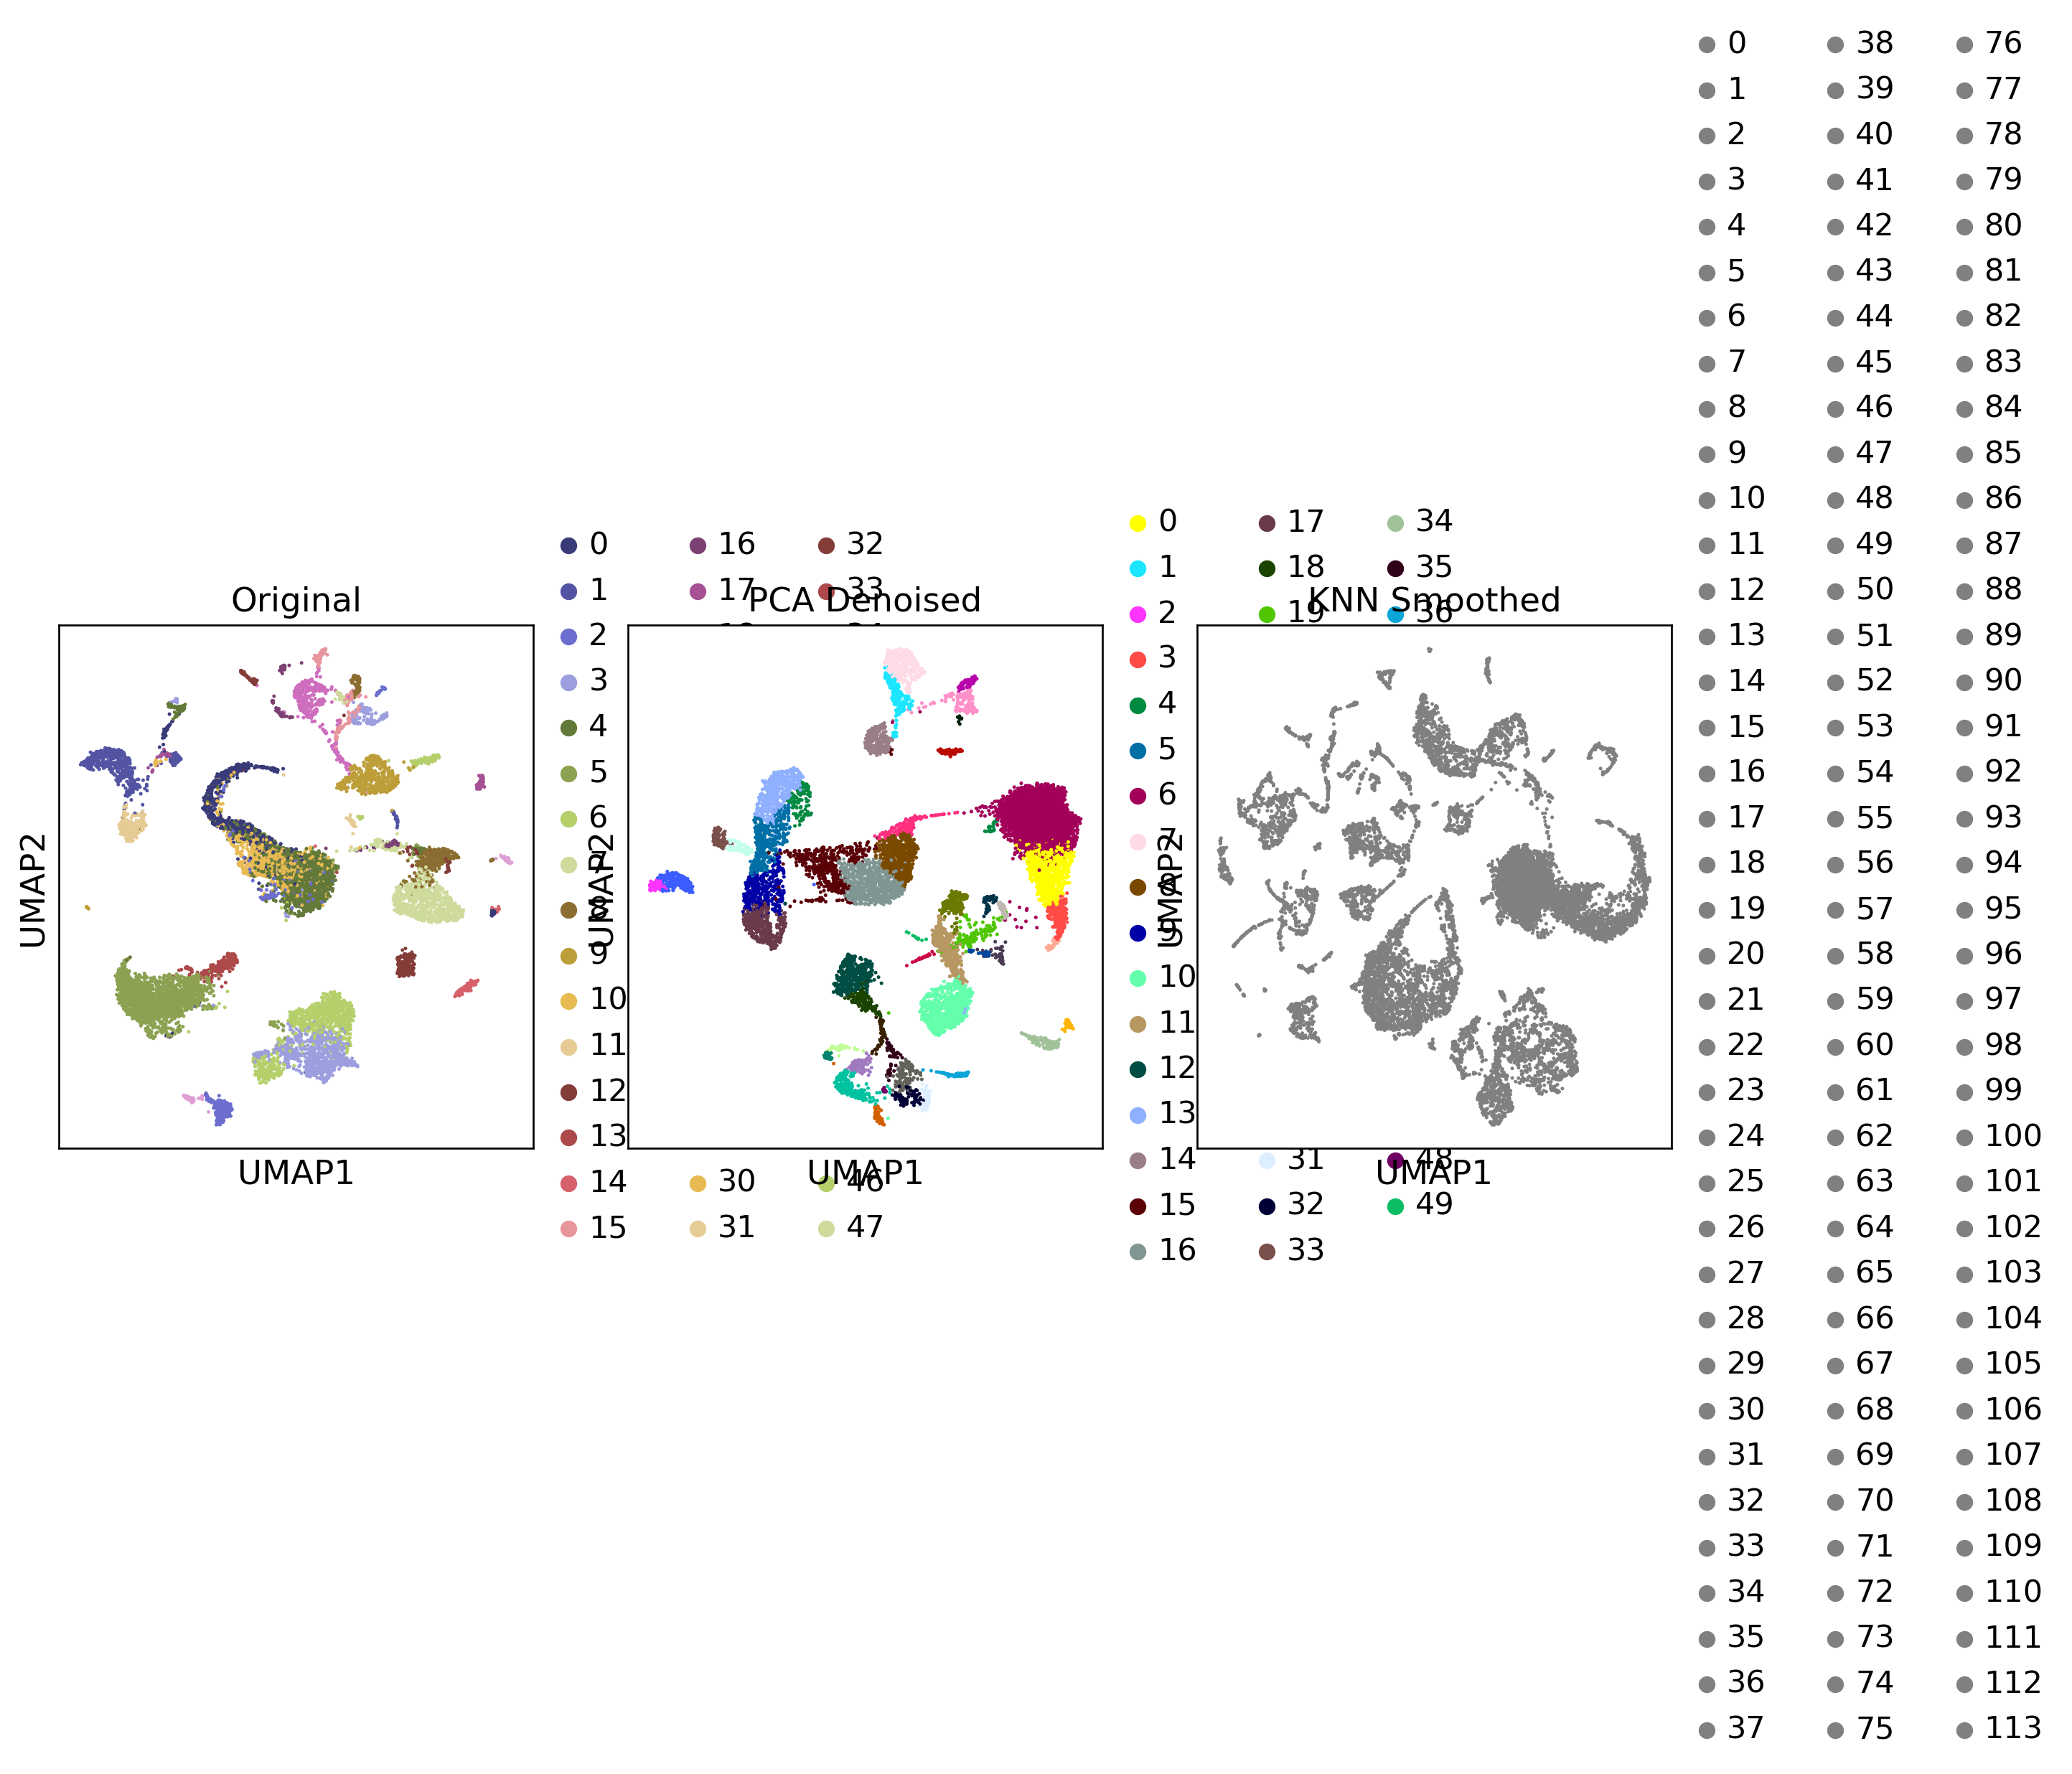

In [133]:
# TODO: keeping this as reference while I work on a better version
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
sc.pl.umap(adata, color='walktrap', ax=axes[0], show=False, title='Original')

# PCA denoised
sc.pl.umap(ad_dn1, color='walktrap', ax=axes[1], show=False, title='PCA Denoised')

# KNN denoised
sc.pl.umap(ad_dn2, color='walktrap', ax=axes[2], show=False, title='KNN Smoothed')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/denoising_comparison.png", dpi=200)

In [136]:

#@title Save figure panels
fig, axs = plt.subplots(1,2, figsize=(9,4))
sc.pl.umap(adata, color="walktrap", ax=axs[0], show=False); axs[0].set_title("Walktrap")
sc.pl.umap(adata, color="leiden",  ax=axs[1], show=False); axs[1].set_title("Leiden")
plt.tight_layout(); plt.savefig(f"{OUTPUT_DIR}/figure_cluster_panel.png", dpi=200, bbox_inches="tight"); plt.close()
print("Figures saved to", OUTPUT_DIR)


Figures saved to /content/drive/MyDrive/STAT4243/roc_outputs


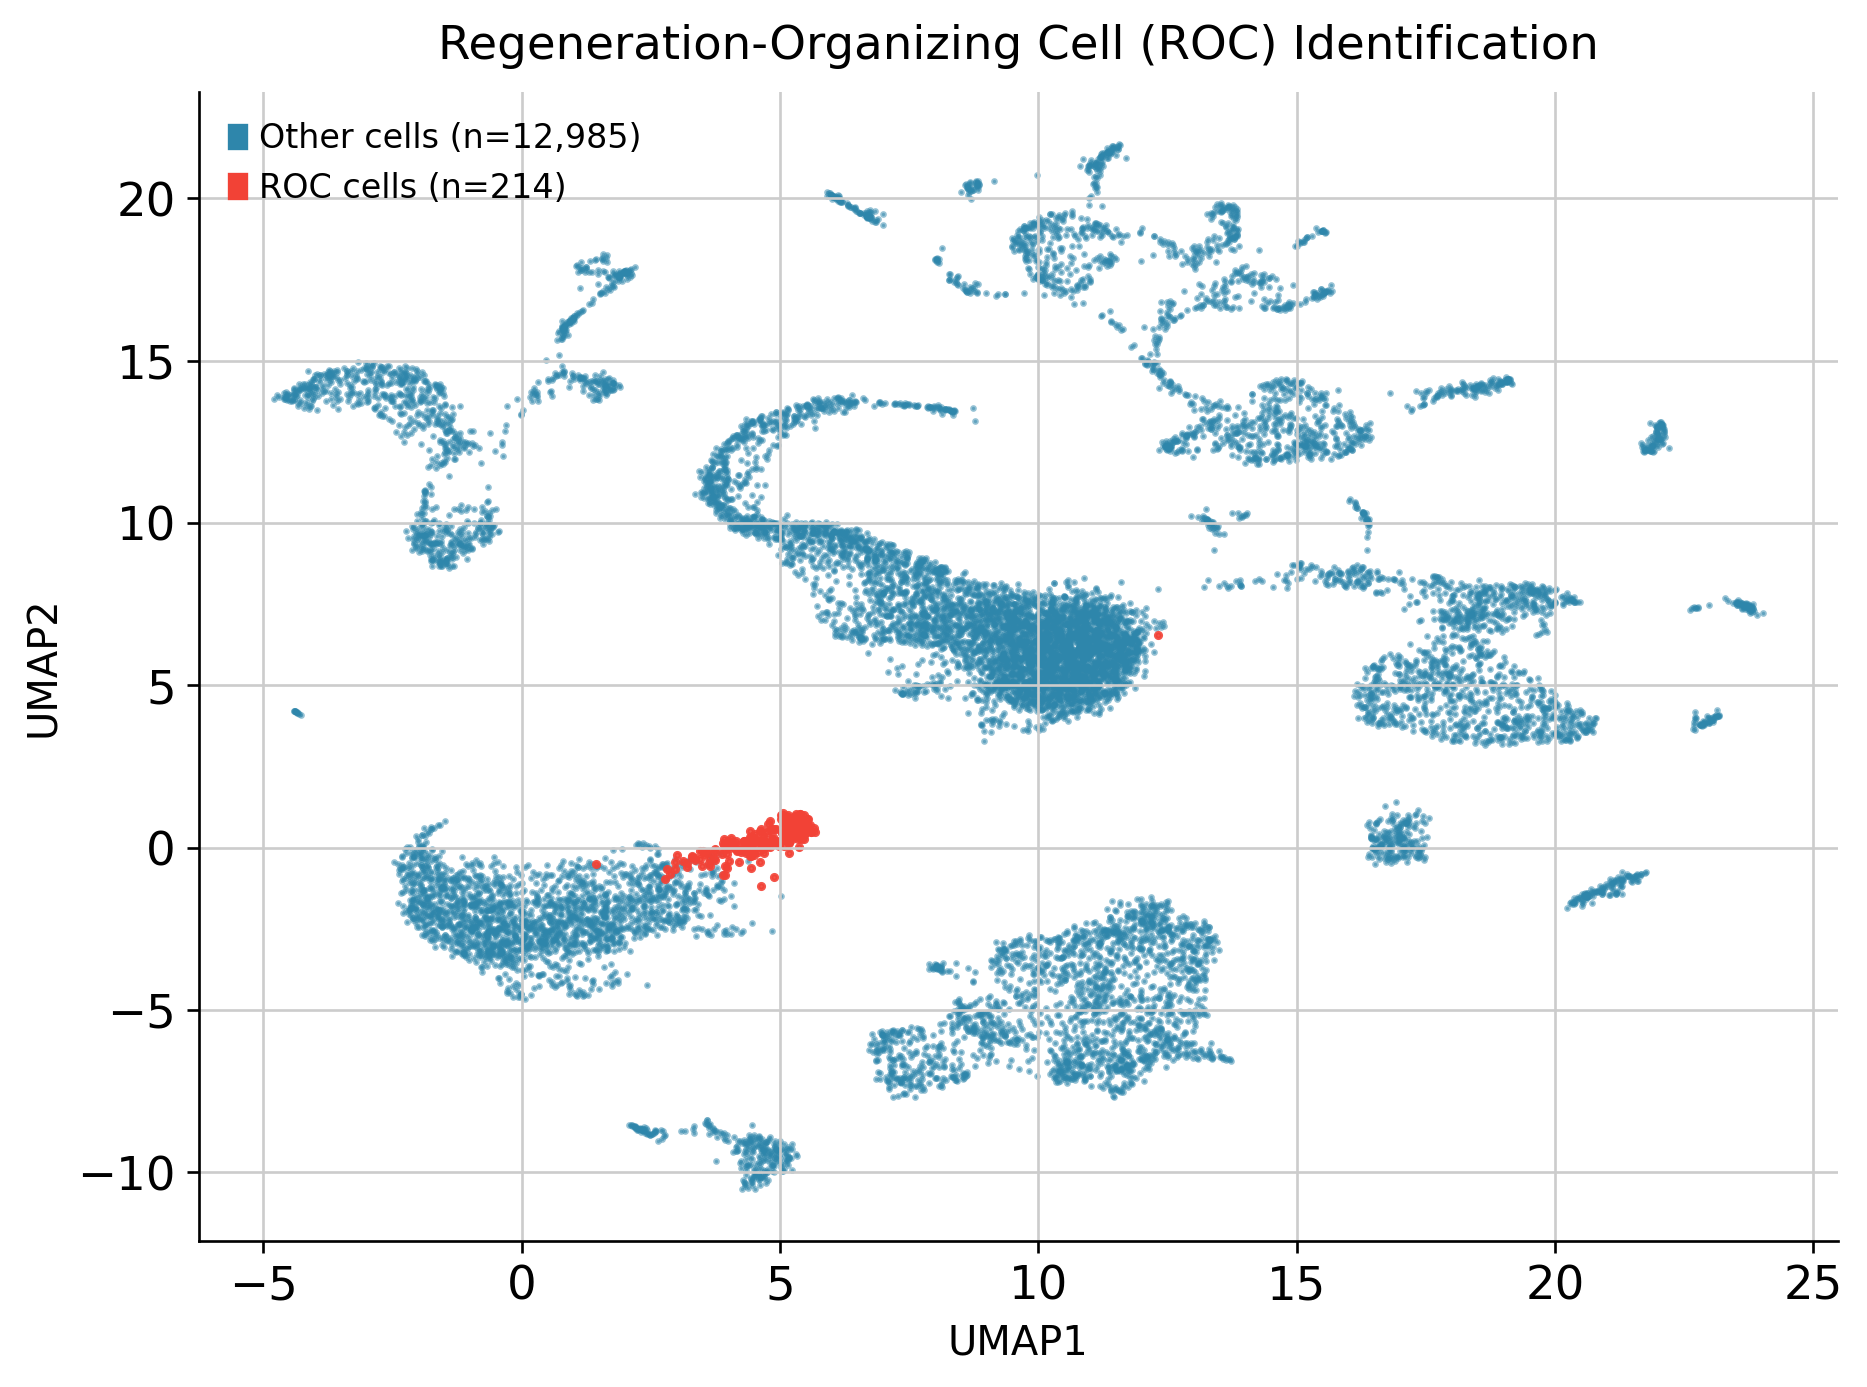

In [134]:
#@title Better Viz

#@title Figure 1: Improved ROC Identification (Fixed Legend)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure with better layout
fig, ax = plt.subplots(figsize=(8, 6))

# Plot non-ROC cells first
non_roc = adata.obs['ROC_flag'] == 'other'
ax.scatter(adata.obsm['X_umap'][non_roc, 0],
           adata.obsm['X_umap'][non_roc, 1],
           c='#2E86AB', s=1, alpha=0.5, rasterized=True)

# Plot ROC cells on top
roc = adata.obs['ROC_flag'] == 'ROC'
ax.scatter(adata.obsm['X_umap'][roc, 0],
           adata.obsm['X_umap'][roc, 1],
           c='#F24236', s=3, alpha=0.9, rasterized=True)

# Create legend manually
other_patch = mpatches.Patch(color='#2E86AB', label=f'Other cells (n={non_roc.sum():,})')
roc_patch = mpatches.Patch(color='#F24236', label=f'ROC cells (n={roc.sum():,})')
ax.legend(handles=[other_patch, roc_patch],
          loc='upper left', frameon=False, fontsize=10)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_title('Regeneration-Organizing Cell (ROC) Identification', fontsize=14, pad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/figure1_roc_identification_improved.png", dpi=300, bbox_inches='tight')
plt.show()

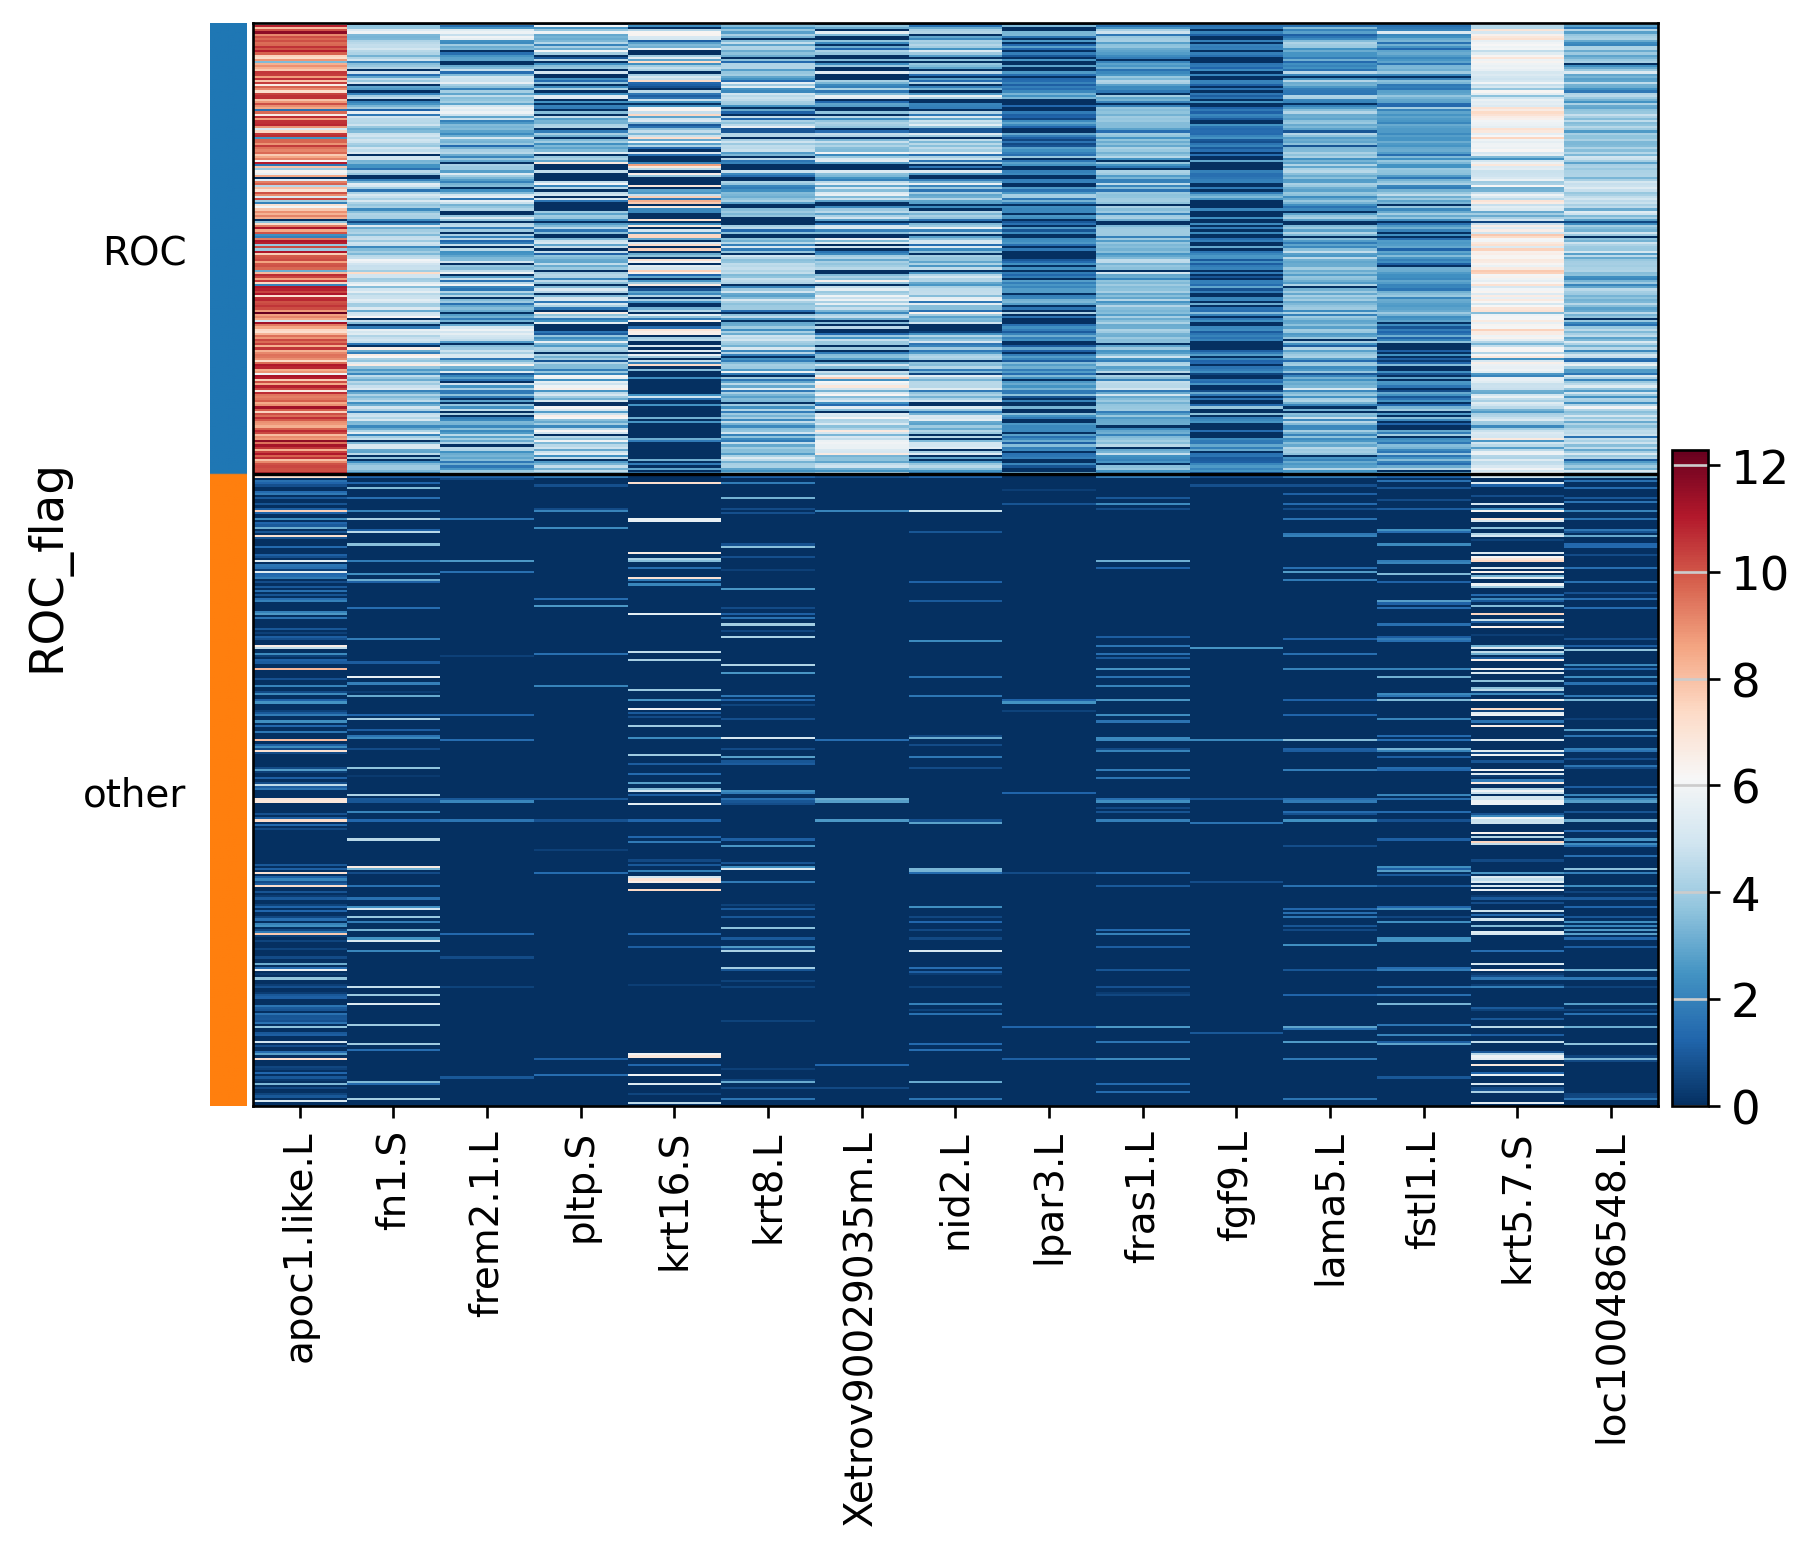

In [136]:
#@title Figure 2: Gene Expression Heatmap
# Select top markers
top_markers = logreg_top.head(20)['names'].tolist()

# Create a subset for visualization
roc_cells = adata[adata.obs['ROC_flag'] == 'ROC'].copy()
other_cells = adata[adata.obs['ROC_flag'] == 'other'].copy()

# Sample for balance (so heatmap isn't overwhelmed)
n_sample = min(300, other_cells.n_obs)
other_sample = other_cells[np.random.choice(other_cells.n_obs, n_sample, replace=False)]

# Combine for heatmap
vis_data = ad.concat([roc_cells, other_sample])

# Generate heatmap
sc.pl.heatmap(vis_data,
              var_names=top_markers[:15],  # Top 15 genes
              groupby='ROC_flag',
              cmap='RdBu_r',
              dendrogram=False,
              figsize=(8, 6),
              show_gene_labels=True,
              show=False)
plt.savefig(f'{OUTPUT_DIR}/gene_expression_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

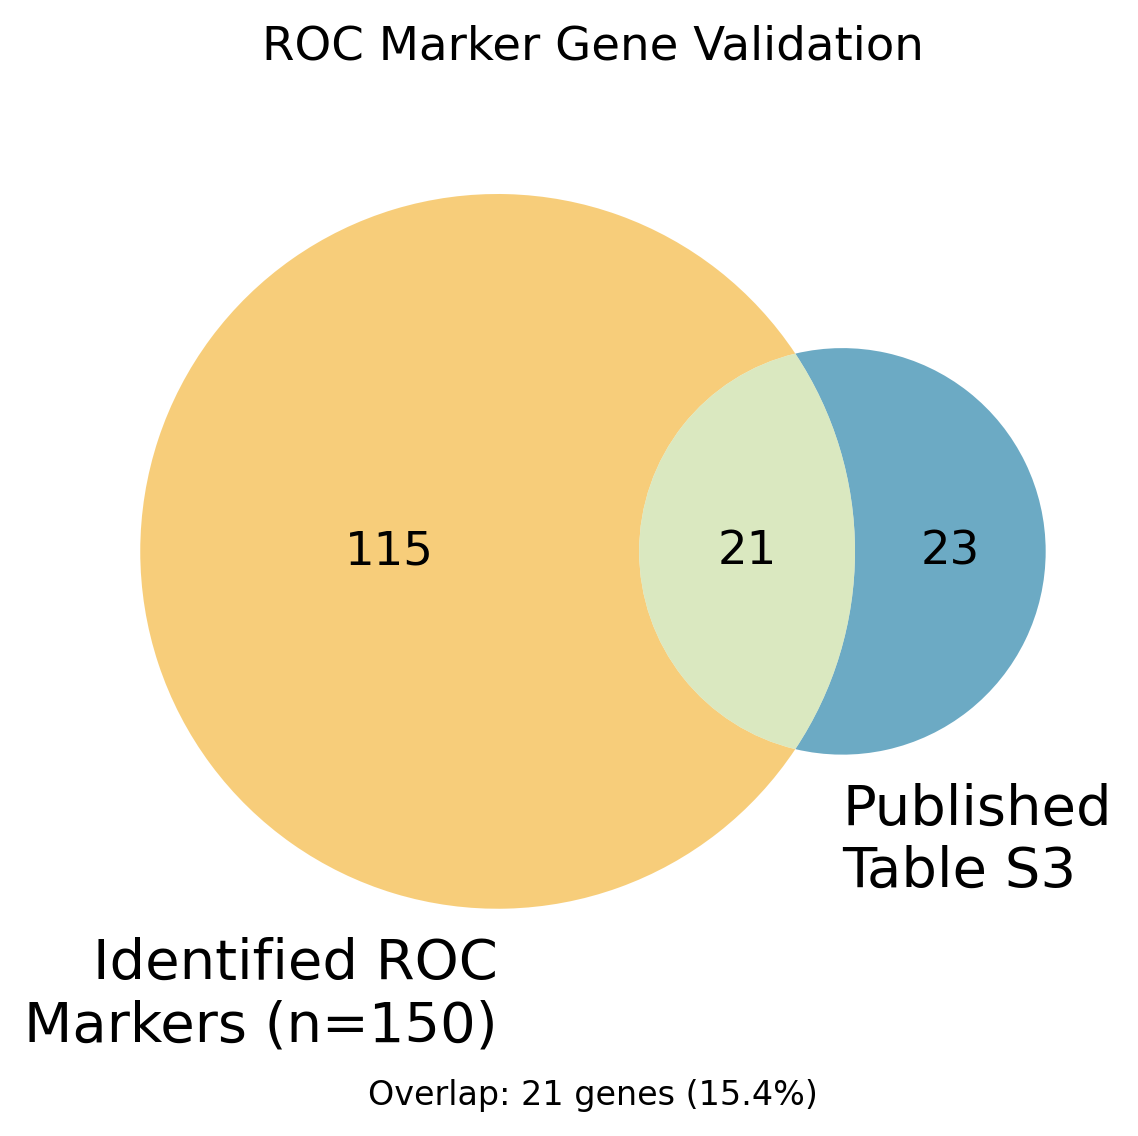

In [137]:
#@title Figure 3: Venn Diagram for Validation
from matplotlib_venn import venn2

# Get gene sets
our_genes = set(map(canon, logreg_df.head(150)["names"]))
table_s3_genes = roc_s3_canon # defined earlier

fig, ax = plt.subplots(figsize=(6, 5))

venn = venn2([our_genes, table_s3_genes],
             ('Identified ROC\nMarkers (n=150)', 'Published\nTable S3'),
             ax=ax,
             set_colors=('#F4B942', '#2E86AB'),
             alpha=0.7)

# Add overlap statistics
overlap = len(our_genes & table_s3_genes)
ax.text(0.5, -0.15,
        f'Overlap: {overlap} genes ({100*overlap/len(our_genes):.1f}%)',
        transform=ax.transAxes, ha='center', fontsize=10)

ax.set_title('ROC Marker Gene Validation', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/figure_venn_validation.png", dpi=300, bbox_inches='tight')
plt.show()


## MI-Checklist & Code Availability
Fill the MI-Checklist scaffold and add your GitHub link in Code Availability.


In [138]:

#@title MI-Checklist scaffold + summary
rows = [
 ("Study design","clinical problem stated"),
 ("Study design","research question stated"),
 ("Data/optimization","data origin described"),
 ("Data/optimization","transformations described (CP10K, Fano HVGs, log2)"),
 ("Modeling","UMAP parameters (cosine, k=20, min_dist=0.5)"),
 ("Modeling","Walktrap on UMAP fuzzy graph (k=10); Leiden on kNN(PCA)"),
 ("Evaluation","silhouette (method-native), ARI, Rand; modularity (Walktrap)"),
 ("Robustness","denoising ×2 & batch integration ×2 impact"),
 ("Reproducibility","Colab + data paths set"),
 ("Code Availability","https://github.com/<your-org>/<repo> (commit <hash>)"),
]
pd.DataFrame(rows, columns=["Section","Item"]).to_csv(f"{OUTPUT_DIR}/MI_CLAIM_scaffold.csv", index=False)

def slurp(p):
    try:
        return json.load(open(p))
    except Exception:
        return {}
summary = {
 "metrics_baseline": slurp(f"{OUTPUT_DIR}/metrics_baseline.json"),
 "impact_denoising": slurp(f"{OUTPUT_DIR}/impact_denoising.json"),
 "impact_batch_integration": slurp(f"{OUTPUT_DIR}/impact_batch_integration.json"),
}
open(f"{OUTPUT_DIR}/summary_auto.json","w").write(json.dumps(summary, indent=2))
print("Wrote MI_CLAIM_scaffold.csv and summary_auto.json in", OUTPUT_DIR)


Wrote MI_CLAIM_scaffold.csv and summary_auto.json in /content/drive/MyDrive/STAT4243/roc_outputs_final
